In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import re
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# gradient boosting machines
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (cross_val_score, train_test_split)
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool, cv

# hyperparameter tuning
from bayes_opt import BayesianOptimization

# to print all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tqdm import tqdm

In [2]:
os.listdir('./data')

['~$zillow_data_dictionary.xlsx',
 'train_2017.csv',
 'properties_2017.csv',
 'properties_2016.csv',
 'train_2016_v2.csv',
 'zillow_data_dictionary.xlsx',
 'sample_submission.csv']

In [3]:
# loading dataset
train_16 = pd.read_csv('./data/train_2016_v2.csv', parse_dates=['transactiondate'])
train_17 = pd.read_csv('./data/train_2017.csv', parse_dates=['transactiondate'])
properties_16 = pd.read_csv('./data/properties_2016.csv')
properties_17 = pd.read_csv('./data/properties_2017.csv')

In [4]:
def reduce_mem_usage(df, verbose=True):
    '''
    reduce memory usage. This function is taken from FabienDaniel from another Kaggle competition
    '''
    df.fillna(np.nan, inplace=True)
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.\
                      format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def get_prop(properties):
    # modify properties dataset, handle in null values
    prop = properties.copy()

    # drop columns of which 99% of values are null
    drop_thresh = prop.shape[0] * 0.01
    prop.dropna(thresh=drop_thresh, axis=1, inplace=True)

    # drop columns if the number of unique values is one
    unique_mask = (prop.nunique() == 1)
    prop.drop(prop.columns[unique_mask], axis=1, inplace=True)
    
    # propertycountylandusecode column has mix of float and str
    prop['propertycountylandusecode'] = prop['propertycountylandusecode'].astype('str')

    # fill in null values
    '''
    Zillow team has built model to predict the sale price of the property and the target they give us is the error
    between their predicted value and the actual value. Our goal is to predict the error they have made, so I believe
    it is better to fill in the null with values that deviate from the actual values instead of filling in median just
    to mimic the situation Zillow team faced when they are doing prediction.
    '''
    for col in prop.columns:
        if prop[col].dtype == 'object':
            prop[col].fillna('NULL', inplace=True)
        else:
            prop[col].fillna(-999, inplace=True)
            
    # put create feature function here if needed
            
    return prop

def get_train(train_set):
    
    train = train_set.copy()
    
    train['month'] = train['transactiondate'].dt.month
    train['month_since_2016'] = (train['transactiondate'].dt.year - 2016) * 12 + train['month']
    train['quarter'] = (train['transactiondate'].dt.month - 1) // 3 + 1
    train.drop('transactiondate', axis=1, inplace=True)
    
    return train

def get_cat_feats(dataset):
    '''
    get categorical feature columns of dataset
    '''
    cat_thresh = 1000    # categorical features if number of unique values under cat_thresh
    cat_feats = ['propertyzoningdesc']
    for col in dataset.columns:
        not_count = (re.search('.*(sqft|cnt|nbr|number|since|year).*', col) is None)
        if not_count and dataset[col].nunique() <= cat_thresh:
            cat_feats.append(col)
    return cat_feats

def convert_cat_columns(dataset, cat_feats):
    '''
    convert categorical feature column data type to string as required by catboost
    '''
    for col in cat_feats:
        if dataset[col].dtype == 'object':
            dataset[col] = dataset[col].astype('str')
        else:
            dataset[col] = dataset[col].astype('int')
        
    return dataset

def bayes_param_opt(X, y, cat_feats, init_points=15, n_iter=25, n_folds=5, random_seed=1, \
                        output_process=False):
    
    # prepare dataset
    dtrain = Pool(data=X, label=y, cat_features= cat_feats)
    
    # define objective function to minimize
    def cat_cv(bagging_fraction, max_depth, lambda_l2, \
                 num_iterations, learning_rate):
        
        params = {'loss_function':'MAE', 'random_seed':1, 'eval_metric':'MAE',
                 'use_best_model':True, 'early_stopping_rounds':20, 'bootstrap_type':'Bernoulli'}
        params['n_estimators'] = int(num_iterations)
        params['learning_rate'] = max(learning_rate, 0)
        params['subsample'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['l2_leaf_reg'] = max(lambda_l2, 0)
#         lgbr = LGBMRegressor(params)
#         cv_result = cross_val_score(estimator=lgbr, X=X, y=y, cv=n_folds, scoring='neg_mean_absolute_error')
        cv_result = cv(dtrain=dtrain, params=params, nfold=n_folds, seed=1, shuffle=True)
        return - cv_result['test-MAE-mean'].min()
    
    optimizer = BayesianOptimization(cat_cv, {
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 15),
                                            'lambda_l2': (0, 5),
                                            'num_iterations':(100, 2000),
                                            'learning_rate':(0.025,0.1),
                                            }, random_state=0)
    
    optimizer.maximize(init_points=init_points, n_iter=n_iter)
    
    return optimizer.max

In [5]:
# prepare training set
prop_16 = get_prop(properties_16)
prop_17 = get_prop(properties_17)
cat_feats = get_cat_feats(prop_16)

transac_16 = get_train(train_16)
df_16 = transac_16.merge(prop_16, how='left', on='parcelid')

transac_17 = get_train(train_17)
df_17 = transac_17.merge(prop_17, how='left', on='parcelid')

train = pd.concat([df_16, df_17], axis=0)

train = convert_cat_columns(train, cat_feats)

# get train feature columns
train_feats = [col for col in train if col not in {'parcelid', 'logerror'}]

# prepare x and y
x = train[train_feats]
y = train['logerror']

In [6]:
print(cat_feats)

['propertyzoningdesc', 'airconditioningtypeid', 'buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip']


In [9]:
# start with a prototype CatBoostRegressor
cat_params = {
        'n_estimators':2000,
        'depth':5,
        'loss_function':'MAE',
        'eval_metric':'MAE',
        'random_seed':1,
        'early_stopping_rounds':50,
        'learning_rate':0.03,
        'l2_leaf_reg':3
            }

dtrain = Pool(data=x, label=y, cat_features=cat_feats_16)
scores = cv(dtrain=dtrain, params=cat_params, nfold=5, seed=1, shuffle=True)

0:	learn: 0.0684194	test: 0.0684189	best: 0.0684189 (0)	total: 372ms	remaining: 12m 23s
1:	learn: 0.0683910	test: 0.0683910	best: 0.0683910 (1)	total: 673ms	remaining: 11m 12s
2:	learn: 0.0683581	test: 0.0683587	best: 0.0683587 (2)	total: 955ms	remaining: 10m 36s
3:	learn: 0.0683304	test: 0.0683306	best: 0.0683306 (3)	total: 1.25s	remaining: 10m 25s
4:	learn: 0.0683035	test: 0.0683043	best: 0.0683043 (4)	total: 1.56s	remaining: 10m 23s
5:	learn: 0.0682764	test: 0.0682784	best: 0.0682784 (5)	total: 1.85s	remaining: 10m 16s
6:	learn: 0.0682517	test: 0.0682550	best: 0.0682550 (6)	total: 2.13s	remaining: 10m 7s
7:	learn: 0.0682282	test: 0.0682322	best: 0.0682322 (7)	total: 2.42s	remaining: 10m 2s
8:	learn: 0.0682070	test: 0.0682109	best: 0.0682109 (8)	total: 2.72s	remaining: 10m 1s
9:	learn: 0.0681862	test: 0.0681905	best: 0.0681905 (9)	total: 3.02s	remaining: 10m 1s
10:	learn: 0.0681664	test: 0.0681712	best: 0.0681712 (10)	total: 3.34s	remaining: 10m 3s
11:	learn: 0.0681467	test: 0.068151

93:	learn: 0.0675429	test: 0.0675982	best: 0.0675982 (93)	total: 30.4s	remaining: 10m 15s
94:	learn: 0.0675391	test: 0.0675946	best: 0.0675946 (94)	total: 30.7s	remaining: 10m 16s
95:	learn: 0.0675355	test: 0.0675921	best: 0.0675921 (95)	total: 31.1s	remaining: 10m 16s
96:	learn: 0.0675331	test: 0.0675904	best: 0.0675904 (96)	total: 31.4s	remaining: 10m 16s
97:	learn: 0.0675303	test: 0.0675879	best: 0.0675879 (97)	total: 31.7s	remaining: 10m 15s
98:	learn: 0.0675270	test: 0.0675855	best: 0.0675855 (98)	total: 32.1s	remaining: 10m 15s
99:	learn: 0.0675244	test: 0.0675829	best: 0.0675829 (99)	total: 32.4s	remaining: 10m 16s
100:	learn: 0.0675212	test: 0.0675800	best: 0.0675800 (100)	total: 32.8s	remaining: 10m 16s
101:	learn: 0.0675175	test: 0.0675772	best: 0.0675772 (101)	total: 33.2s	remaining: 10m 17s
102:	learn: 0.0675153	test: 0.0675756	best: 0.0675756 (102)	total: 33.5s	remaining: 10m 17s
103:	learn: 0.0675126	test: 0.0675730	best: 0.0675730 (103)	total: 33.9s	remaining: 10m 18s
10

183:	learn: 0.0673376	test: 0.0674500	best: 0.0674500 (183)	total: 1m 2s	remaining: 10m 18s
184:	learn: 0.0673363	test: 0.0674494	best: 0.0674494 (184)	total: 1m 3s	remaining: 10m 18s
185:	learn: 0.0673350	test: 0.0674486	best: 0.0674486 (185)	total: 1m 3s	remaining: 10m 18s
186:	learn: 0.0673337	test: 0.0674481	best: 0.0674481 (186)	total: 1m 3s	remaining: 10m 18s
187:	learn: 0.0673316	test: 0.0674470	best: 0.0674470 (187)	total: 1m 4s	remaining: 10m 18s


KeyboardInterrupt: 

In [72]:
test_score = scores['test-MAE-mean'].min()
print('Best cross validation score without parameter tuning is {}'.format(test_score))

Best cross validation score without parameter tuning is 0.06743764002106459


In [97]:
opt_result = bayes_param_opt(x, y, cat_feats_16)

|   iter    |  target   | baggin... | lambda_l2 | learni... | max_depth | num_it... |
-------------------------------------------------------------------------------------
0:	learn: 0.0683469	test: 0.0683641	best: 0.0683641 (0)	total: 719ms	remaining: 10m 48s
1:	learn: 0.0682449	test: 0.0682873	best: 0.0682873 (1)	total: 1.53s	remaining: 11m 29s
2:	learn: 0.0681517	test: 0.0682190	best: 0.0682190 (2)	total: 2.36s	remaining: 11m 48s
3:	learn: 0.0680701	test: 0.0681598	best: 0.0681598 (3)	total: 3.17s	remaining: 11m 52s
4:	learn: 0.0680034	test: 0.0681087	best: 0.0681087 (4)	total: 3.87s	remaining: 11m 35s
5:	learn: 0.0679221	test: 0.0680519	best: 0.0680519 (5)	total: 4.6s	remaining: 11m 28s
6:	learn: 0.0678717	test: 0.0680144	best: 0.0680144 (6)	total: 5.18s	remaining: 11m 3s
7:	learn: 0.0678015	test: 0.0679706	best: 0.0679706 (7)	total: 5.97s	remaining: 11m 8s
8:	learn: 0.0677528	test: 0.0679365	best: 0.0679365 (8)	total: 6.76s	remaining: 11m 12s
9:	learn: 0.0676965	test: 0.0679080	bes

90:	learn: 0.0655293	test: 0.0673929	best: 0.0673920 (86)	total: 1m 19s	remaining: 11m 54s
91:	learn: 0.0655149	test: 0.0673899	best: 0.0673899 (91)	total: 1m 20s	remaining: 11m 53s
92:	learn: 0.0654937	test: 0.0673880	best: 0.0673880 (92)	total: 1m 21s	remaining: 11m 52s
93:	learn: 0.0654868	test: 0.0673875	best: 0.0673875 (93)	total: 1m 22s	remaining: 11m 51s
94:	learn: 0.0654726	test: 0.0673861	best: 0.0673861 (94)	total: 1m 23s	remaining: 11m 50s
95:	learn: 0.0654598	test: 0.0673846	best: 0.0673846 (95)	total: 1m 24s	remaining: 11m 49s
96:	learn: 0.0654388	test: 0.0673832	best: 0.0673832 (96)	total: 1m 25s	remaining: 11m 49s
97:	learn: 0.0654277	test: 0.0673831	best: 0.0673831 (97)	total: 1m 26s	remaining: 11m 48s
98:	learn: 0.0654141	test: 0.0673794	best: 0.0673794 (98)	total: 1m 27s	remaining: 11m 48s
99:	learn: 0.0654032	test: 0.0673783	best: 0.0673783 (99)	total: 1m 28s	remaining: 11m 47s
100:	learn: 0.0653841	test: 0.0673780	best: 0.0673780 (100)	total: 1m 29s	remaining: 11m 4

179:	learn: 0.0640954	test: 0.0673459	best: 0.0673459 (179)	total: 2m 43s	remaining: 10m 59s
180:	learn: 0.0640777	test: 0.0673471	best: 0.0673459 (179)	total: 2m 44s	remaining: 10m 58s
181:	learn: 0.0640540	test: 0.0673451	best: 0.0673451 (181)	total: 2m 45s	remaining: 10m 58s
182:	learn: 0.0640350	test: 0.0673438	best: 0.0673438 (182)	total: 2m 46s	remaining: 10m 57s
183:	learn: 0.0640119	test: 0.0673434	best: 0.0673434 (183)	total: 2m 47s	remaining: 10m 56s
184:	learn: 0.0639893	test: 0.0673440	best: 0.0673434 (183)	total: 2m 48s	remaining: 10m 55s
185:	learn: 0.0639751	test: 0.0673433	best: 0.0673433 (185)	total: 2m 49s	remaining: 10m 55s
186:	learn: 0.0639590	test: 0.0673426	best: 0.0673426 (186)	total: 2m 50s	remaining: 10m 54s
187:	learn: 0.0639348	test: 0.0673452	best: 0.0673426 (186)	total: 2m 51s	remaining: 10m 53s
188:	learn: 0.0639172	test: 0.0673476	best: 0.0673426 (186)	total: 2m 52s	remaining: 10m 53s
189:	learn: 0.0639045	test: 0.0673481	best: 0.0673426 (186)	total: 2m 

14:	learn: 0.0657104	test: 0.0677979	best: 0.0677979 (14)	total: 1m 6s	remaining: 16m 12s
15:	learn: 0.0655501	test: 0.0677886	best: 0.0677886 (15)	total: 1m 11s	remaining: 16m 12s
16:	learn: 0.0653637	test: 0.0677782	best: 0.0677782 (16)	total: 1m 16s	remaining: 16m 14s
17:	learn: 0.0652510	test: 0.0677644	best: 0.0677644 (17)	total: 1m 20s	remaining: 16m 5s
18:	learn: 0.0650875	test: 0.0677530	best: 0.0677530 (18)	total: 1m 25s	remaining: 16m 7s
19:	learn: 0.0649440	test: 0.0677455	best: 0.0677455 (19)	total: 1m 30s	remaining: 16m 7s
20:	learn: 0.0648003	test: 0.0677396	best: 0.0677396 (20)	total: 1m 35s	remaining: 16m 7s
21:	learn: 0.0646456	test: 0.0677277	best: 0.0677277 (21)	total: 1m 40s	remaining: 16m 5s
22:	learn: 0.0645897	test: 0.0677190	best: 0.0677190 (22)	total: 1m 43s	remaining: 15m 47s
23:	learn: 0.0644585	test: 0.0677129	best: 0.0677129 (23)	total: 1m 47s	remaining: 15m 44s
24:	learn: 0.0643482	test: 0.0677019	best: 0.0677019 (24)	total: 1m 53s	remaining: 15m 46s
25:	l

47:	learn: 0.0633147	test: 0.0676061	best: 0.0676025 (45)	total: 2m 9s	remaining: 1h 16m 32s
48:	learn: 0.0632336	test: 0.0676036	best: 0.0676025 (45)	total: 2m 12s	remaining: 1h 16m 41s
49:	learn: 0.0631431	test: 0.0676019	best: 0.0676019 (49)	total: 2m 14s	remaining: 1h 16m 30s
50:	learn: 0.0630396	test: 0.0676070	best: 0.0676019 (49)	total: 2m 17s	remaining: 1h 16m 38s
51:	learn: 0.0629837	test: 0.0676053	best: 0.0676019 (49)	total: 2m 20s	remaining: 1h 16m 44s
52:	learn: 0.0629065	test: 0.0676081	best: 0.0676019 (49)	total: 2m 23s	remaining: 1h 16m 53s
53:	learn: 0.0628531	test: 0.0676087	best: 0.0676019 (49)	total: 2m 26s	remaining: 1h 16m 41s
54:	learn: 0.0627779	test: 0.0676004	best: 0.0676004 (54)	total: 2m 28s	remaining: 1h 16m 27s
55:	learn: 0.0627106	test: 0.0675989	best: 0.0675989 (55)	total: 2m 31s	remaining: 1h 16m 30s
56:	learn: 0.0626507	test: 0.0675968	best: 0.0675968 (56)	total: 2m 34s	remaining: 1h 16m 31s
57:	learn: 0.0625823	test: 0.0676024	best: 0.0675968 (56)	tot

58:	learn: 0.0634445	test: 0.0675617	best: 0.0675564 (56)	total: 2m 43s	remaining: 12m 13s
59:	learn: 0.0634070	test: 0.0675603	best: 0.0675564 (56)	total: 2m 46s	remaining: 12m 12s
60:	learn: 0.0633418	test: 0.0675515	best: 0.0675515 (60)	total: 2m 49s	remaining: 12m 11s
61:	learn: 0.0632802	test: 0.0675467	best: 0.0675467 (61)	total: 2m 53s	remaining: 12m 11s
62:	learn: 0.0632165	test: 0.0675478	best: 0.0675467 (61)	total: 2m 56s	remaining: 12m 10s
63:	learn: 0.0631659	test: 0.0675442	best: 0.0675442 (63)	total: 2m 59s	remaining: 12m 7s
64:	learn: 0.0631244	test: 0.0675435	best: 0.0675435 (64)	total: 3m 2s	remaining: 12m 5s
65:	learn: 0.0630816	test: 0.0675431	best: 0.0675431 (65)	total: 3m 4s	remaining: 12m
66:	learn: 0.0630442	test: 0.0675402	best: 0.0675402 (66)	total: 3m 7s	remaining: 11m 58s
67:	learn: 0.0629956	test: 0.0675384	best: 0.0675384 (67)	total: 3m 10s	remaining: 11m 56s
68:	learn: 0.0629512	test: 0.0675398	best: 0.0675384 (67)	total: 3m 13s	remaining: 11m 53s
69:	lear

60:	learn: 0.0657082	test: 0.0674220	best: 0.0674196 (53)	total: 55s	remaining: 12m 25s
61:	learn: 0.0656966	test: 0.0674207	best: 0.0674196 (53)	total: 55.8s	remaining: 12m 22s
62:	learn: 0.0656697	test: 0.0674176	best: 0.0674176 (62)	total: 56.8s	remaining: 12m 22s
63:	learn: 0.0656531	test: 0.0674161	best: 0.0674161 (63)	total: 57.8s	remaining: 12m 23s
64:	learn: 0.0656409	test: 0.0674136	best: 0.0674136 (64)	total: 58.6s	remaining: 12m 21s
65:	learn: 0.0656161	test: 0.0674117	best: 0.0674117 (65)	total: 59.5s	remaining: 12m 20s
66:	learn: 0.0655957	test: 0.0674111	best: 0.0674111 (66)	total: 1m	remaining: 12m 20s
67:	learn: 0.0655731	test: 0.0674096	best: 0.0674096 (67)	total: 1m 1s	remaining: 12m 18s
68:	learn: 0.0655551	test: 0.0674074	best: 0.0674074 (68)	total: 1m 2s	remaining: 12m 19s
69:	learn: 0.0655389	test: 0.0674044	best: 0.0674044 (69)	total: 1m 3s	remaining: 12m 19s
70:	learn: 0.0655222	test: 0.0674030	best: 0.0674030 (70)	total: 1m 4s	remaining: 12m 19s
71:	learn: 0.06

1:	learn: 0.0682409	test: 0.0683081	best: 0.0683081 (1)	total: 1.23s	remaining: 1m 21s
2:	learn: 0.0681415	test: 0.0682471	best: 0.0682471 (2)	total: 1.64s	remaining: 1m 12s
3:	learn: 0.0680801	test: 0.0681974	best: 0.0681974 (3)	total: 2.04s	remaining: 1m 6s
4:	learn: 0.0679973	test: 0.0681463	best: 0.0681463 (4)	total: 2.52s	remaining: 1m 5s
5:	learn: 0.0679380	test: 0.0681016	best: 0.0681016 (5)	total: 2.82s	remaining: 1m
6:	learn: 0.0678921	test: 0.0680689	best: 0.0680689 (6)	total: 3.12s	remaining: 57s
7:	learn: 0.0678261	test: 0.0680267	best: 0.0680267 (7)	total: 3.59s	remaining: 57s
8:	learn: 0.0677632	test: 0.0679924	best: 0.0679924 (8)	total: 4.04s	remaining: 56.6s
9:	learn: 0.0676885	test: 0.0679545	best: 0.0679545 (9)	total: 4.57s	remaining: 57.2s
10:	learn: 0.0676228	test: 0.0679243	best: 0.0679243 (10)	total: 5.03s	remaining: 56.7s
11:	learn: 0.0675637	test: 0.0678916	best: 0.0678916 (11)	total: 5.49s	remaining: 56.3s
12:	learn: 0.0675015	test: 0.0678593	best: 0.0678593 (1

95:	learn: 0.0647238	test: 0.0673795	best: 0.0673795 (95)	total: 57.7s	remaining: 23.4s
96:	learn: 0.0646999	test: 0.0673769	best: 0.0673769 (96)	total: 58.2s	remaining: 22.8s
97:	learn: 0.0646759	test: 0.0673764	best: 0.0673764 (97)	total: 58.8s	remaining: 22.2s
98:	learn: 0.0646575	test: 0.0673768	best: 0.0673764 (97)	total: 59.5s	remaining: 21.6s
99:	learn: 0.0646382	test: 0.0673753	best: 0.0673753 (99)	total: 1m	remaining: 21s
100:	learn: 0.0646156	test: 0.0673765	best: 0.0673753 (99)	total: 1m	remaining: 20.4s
101:	learn: 0.0645918	test: 0.0673744	best: 0.0673744 (101)	total: 1m 1s	remaining: 19.8s
102:	learn: 0.0645679	test: 0.0673747	best: 0.0673744 (101)	total: 1m 1s	remaining: 19.2s
103:	learn: 0.0645503	test: 0.0673736	best: 0.0673736 (103)	total: 1m 2s	remaining: 18.6s
104:	learn: 0.0645384	test: 0.0673743	best: 0.0673736 (103)	total: 1m 3s	remaining: 18s
105:	learn: 0.0645132	test: 0.0673739	best: 0.0673736 (103)	total: 1m 3s	remaining: 17.4s
106:	learn: 0.0644916	test: 0.0

49:	learn: 0.0615288	test: 0.0677385	best: 0.0676989 (38)	total: 3m 59s	remaining: 1h 47m 9s
50:	learn: 0.0614386	test: 0.0677445	best: 0.0676989 (38)	total: 4m 3s	remaining: 1h 46m 57s
51:	learn: 0.0613307	test: 0.0677462	best: 0.0676989 (38)	total: 4m 8s	remaining: 1h 46m 50s
52:	learn: 0.0612535	test: 0.0677469	best: 0.0676989 (38)	total: 4m 12s	remaining: 1h 46m 44s
53:	learn: 0.0611614	test: 0.0677515	best: 0.0676989 (38)	total: 4m 17s	remaining: 1h 46m 36s
54:	learn: 0.0610667	test: 0.0677535	best: 0.0676989 (38)	total: 4m 22s	remaining: 1h 46m 30s
55:	learn: 0.0609853	test: 0.0677603	best: 0.0676989 (38)	total: 4m 27s	remaining: 1h 46m 26s
56:	learn: 0.0608703	test: 0.0677555	best: 0.0676989 (38)	total: 4m 31s	remaining: 1h 46m 17s
57:	learn: 0.0607767	test: 0.0677577	best: 0.0676989 (38)	total: 4m 36s	remaining: 1h 46m 8s
Stopped by overfitting detector  (20 iterations wait)
58:	learn: 0.0607224	test: 0.0677565	best: 0.0676989 (38)	total: 4m 40s	remaining: 1h 45m 43s
|  8      

81:	learn: 0.0671704	test: 0.0674038	best: 0.0674038 (81)	total: 35s	remaining: 9m 7s
82:	learn: 0.0671631	test: 0.0674011	best: 0.0674011 (82)	total: 35.4s	remaining: 9m 7s
83:	learn: 0.0671580	test: 0.0673998	best: 0.0673998 (83)	total: 35.9s	remaining: 9m 7s
84:	learn: 0.0671532	test: 0.0673984	best: 0.0673984 (84)	total: 36.3s	remaining: 9m 7s
85:	learn: 0.0671472	test: 0.0673957	best: 0.0673957 (85)	total: 36.8s	remaining: 9m 7s
86:	learn: 0.0671423	test: 0.0673937	best: 0.0673937 (86)	total: 37.2s	remaining: 9m 6s
87:	learn: 0.0671376	test: 0.0673919	best: 0.0673919 (87)	total: 37.6s	remaining: 9m 6s
88:	learn: 0.0671334	test: 0.0673892	best: 0.0673892 (88)	total: 38.1s	remaining: 9m 6s
89:	learn: 0.0671267	test: 0.0673865	best: 0.0673865 (89)	total: 38.5s	remaining: 9m 5s
90:	learn: 0.0671219	test: 0.0673849	best: 0.0673849 (90)	total: 38.9s	remaining: 9m 4s
91:	learn: 0.0671179	test: 0.0673838	best: 0.0673838 (91)	total: 39.3s	remaining: 9m 4s
92:	learn: 0.0671139	test: 0.06738

172:	learn: 0.0667382	test: 0.0672771	best: 0.0672771 (172)	total: 1m 13s	remaining: 8m 24s
173:	learn: 0.0667331	test: 0.0672756	best: 0.0672756 (173)	total: 1m 13s	remaining: 8m 23s
174:	learn: 0.0667252	test: 0.0672746	best: 0.0672746 (174)	total: 1m 13s	remaining: 8m 23s
175:	learn: 0.0667184	test: 0.0672726	best: 0.0672726 (175)	total: 1m 14s	remaining: 8m 22s
176:	learn: 0.0667120	test: 0.0672713	best: 0.0672713 (176)	total: 1m 14s	remaining: 8m 22s
177:	learn: 0.0667076	test: 0.0672701	best: 0.0672701 (177)	total: 1m 15s	remaining: 8m 21s
178:	learn: 0.0667008	test: 0.0672694	best: 0.0672694 (178)	total: 1m 15s	remaining: 8m 21s
179:	learn: 0.0666925	test: 0.0672699	best: 0.0672694 (178)	total: 1m 16s	remaining: 8m 21s
180:	learn: 0.0666863	test: 0.0672673	best: 0.0672673 (180)	total: 1m 16s	remaining: 8m 20s
181:	learn: 0.0666793	test: 0.0672660	best: 0.0672660 (181)	total: 1m 16s	remaining: 8m 19s
182:	learn: 0.0666717	test: 0.0672629	best: 0.0672629 (182)	total: 1m 17s	remain

262:	learn: 0.0663088	test: 0.0672035	best: 0.0672035 (262)	total: 1m 51s	remaining: 7m 46s
263:	learn: 0.0663058	test: 0.0672033	best: 0.0672033 (263)	total: 1m 51s	remaining: 7m 45s
264:	learn: 0.0663014	test: 0.0672029	best: 0.0672029 (264)	total: 1m 52s	remaining: 7m 45s
265:	learn: 0.0662975	test: 0.0672018	best: 0.0672018 (265)	total: 1m 52s	remaining: 7m 44s
266:	learn: 0.0662920	test: 0.0672011	best: 0.0672011 (266)	total: 1m 52s	remaining: 7m 44s
267:	learn: 0.0662881	test: 0.0671994	best: 0.0671994 (267)	total: 1m 53s	remaining: 7m 43s
268:	learn: 0.0662849	test: 0.0671985	best: 0.0671985 (268)	total: 1m 53s	remaining: 7m 43s
269:	learn: 0.0662822	test: 0.0671990	best: 0.0671985 (268)	total: 1m 54s	remaining: 7m 43s
270:	learn: 0.0662796	test: 0.0671989	best: 0.0671985 (268)	total: 1m 54s	remaining: 7m 43s
271:	learn: 0.0662748	test: 0.0671993	best: 0.0671985 (268)	total: 1m 55s	remaining: 7m 43s
272:	learn: 0.0662720	test: 0.0671991	best: 0.0671985 (268)	total: 1m 55s	remain

352:	learn: 0.0660187	test: 0.0671694	best: 0.0671694 (352)	total: 2m 30s	remaining: 7m 10s
353:	learn: 0.0660159	test: 0.0671695	best: 0.0671694 (352)	total: 2m 30s	remaining: 7m 10s
354:	learn: 0.0660128	test: 0.0671692	best: 0.0671692 (354)	total: 2m 31s	remaining: 7m 10s
355:	learn: 0.0660097	test: 0.0671688	best: 0.0671688 (355)	total: 2m 31s	remaining: 7m 9s
356:	learn: 0.0660063	test: 0.0671673	best: 0.0671673 (356)	total: 2m 31s	remaining: 7m 9s
357:	learn: 0.0660026	test: 0.0671671	best: 0.0671671 (357)	total: 2m 32s	remaining: 7m 8s
358:	learn: 0.0659999	test: 0.0671671	best: 0.0671671 (358)	total: 2m 32s	remaining: 7m 8s
359:	learn: 0.0659960	test: 0.0671668	best: 0.0671668 (359)	total: 2m 33s	remaining: 7m 8s
360:	learn: 0.0659929	test: 0.0671657	best: 0.0671657 (360)	total: 2m 33s	remaining: 7m 7s
361:	learn: 0.0659891	test: 0.0671650	best: 0.0671650 (361)	total: 2m 34s	remaining: 7m 7s
362:	learn: 0.0659855	test: 0.0671644	best: 0.0671644 (362)	total: 2m 34s	remaining: 7m

21:	learn: 0.0678115	test: 0.0678948	best: 0.0678948 (21)	total: 12.5s	remaining: 7m 15s
22:	learn: 0.0677963	test: 0.0678817	best: 0.0678817 (22)	total: 13s	remaining: 7m 15s
23:	learn: 0.0677783	test: 0.0678674	best: 0.0678674 (23)	total: 13.6s	remaining: 7m 15s
24:	learn: 0.0677588	test: 0.0678521	best: 0.0678521 (24)	total: 14.2s	remaining: 7m 15s
25:	learn: 0.0677422	test: 0.0678391	best: 0.0678391 (25)	total: 14.8s	remaining: 7m 16s
26:	learn: 0.0677233	test: 0.0678254	best: 0.0678254 (26)	total: 15.4s	remaining: 7m 17s
27:	learn: 0.0677067	test: 0.0678133	best: 0.0678133 (27)	total: 16.1s	remaining: 7m 17s
28:	learn: 0.0676912	test: 0.0678011	best: 0.0678011 (28)	total: 16.7s	remaining: 7m 18s
29:	learn: 0.0676745	test: 0.0677904	best: 0.0677904 (29)	total: 17.3s	remaining: 7m 19s
30:	learn: 0.0676566	test: 0.0677788	best: 0.0677788 (30)	total: 17.9s	remaining: 7m 19s
31:	learn: 0.0676392	test: 0.0677685	best: 0.0677685 (31)	total: 18.6s	remaining: 7m 20s
32:	learn: 0.0676270	te

114:	learn: 0.0669485	test: 0.0674305	best: 0.0674305 (114)	total: 1m 19s	remaining: 7m 47s
115:	learn: 0.0669431	test: 0.0674292	best: 0.0674292 (115)	total: 1m 20s	remaining: 7m 46s
116:	learn: 0.0669359	test: 0.0674266	best: 0.0674266 (116)	total: 1m 20s	remaining: 7m 45s
117:	learn: 0.0669295	test: 0.0674247	best: 0.0674247 (117)	total: 1m 21s	remaining: 7m 44s
118:	learn: 0.0669260	test: 0.0674237	best: 0.0674237 (118)	total: 1m 22s	remaining: 7m 43s
119:	learn: 0.0669214	test: 0.0674222	best: 0.0674222 (119)	total: 1m 22s	remaining: 7m 43s
120:	learn: 0.0669172	test: 0.0674204	best: 0.0674204 (120)	total: 1m 23s	remaining: 7m 42s
121:	learn: 0.0669096	test: 0.0674197	best: 0.0674197 (121)	total: 1m 24s	remaining: 7m 41s
122:	learn: 0.0669050	test: 0.0674190	best: 0.0674190 (122)	total: 1m 24s	remaining: 7m 41s
123:	learn: 0.0669000	test: 0.0674162	best: 0.0674162 (123)	total: 1m 25s	remaining: 7m 40s
124:	learn: 0.0668938	test: 0.0674144	best: 0.0674144 (124)	total: 1m 26s	remain

204:	learn: 0.0665343	test: 0.0673276	best: 0.0673276 (204)	total: 2m 27s	remaining: 7m 1s
205:	learn: 0.0665304	test: 0.0673270	best: 0.0673270 (205)	total: 2m 28s	remaining: 7m
206:	learn: 0.0665286	test: 0.0673265	best: 0.0673265 (206)	total: 2m 28s	remaining: 7m
207:	learn: 0.0665250	test: 0.0673259	best: 0.0673259 (207)	total: 2m 29s	remaining: 6m 59s
208:	learn: 0.0665218	test: 0.0673256	best: 0.0673256 (208)	total: 2m 30s	remaining: 6m 59s
209:	learn: 0.0665191	test: 0.0673256	best: 0.0673256 (209)	total: 2m 31s	remaining: 6m 58s
210:	learn: 0.0665158	test: 0.0673245	best: 0.0673245 (210)	total: 2m 31s	remaining: 6m 57s
211:	learn: 0.0665111	test: 0.0673232	best: 0.0673232 (211)	total: 2m 32s	remaining: 6m 56s
212:	learn: 0.0665075	test: 0.0673232	best: 0.0673232 (212)	total: 2m 33s	remaining: 6m 56s
213:	learn: 0.0665043	test: 0.0673232	best: 0.0673232 (212)	total: 2m 34s	remaining: 6m 56s
214:	learn: 0.0665012	test: 0.0673233	best: 0.0673232 (212)	total: 2m 34s	remaining: 6m 5

294:	learn: 0.0662165	test: 0.0672750	best: 0.0672746 (291)	total: 3m 35s	remaining: 6m 1s
295:	learn: 0.0662128	test: 0.0672748	best: 0.0672746 (291)	total: 3m 36s	remaining: 6m 1s
296:	learn: 0.0662103	test: 0.0672744	best: 0.0672744 (296)	total: 3m 36s	remaining: 6m
297:	learn: 0.0662068	test: 0.0672736	best: 0.0672736 (297)	total: 3m 37s	remaining: 5m 59s
298:	learn: 0.0662030	test: 0.0672729	best: 0.0672729 (298)	total: 3m 38s	remaining: 5m 59s
299:	learn: 0.0661983	test: 0.0672722	best: 0.0672722 (299)	total: 3m 39s	remaining: 5m 58s
300:	learn: 0.0661929	test: 0.0672706	best: 0.0672706 (300)	total: 3m 40s	remaining: 5m 58s
301:	learn: 0.0661892	test: 0.0672703	best: 0.0672703 (301)	total: 3m 40s	remaining: 5m 57s
302:	learn: 0.0661868	test: 0.0672696	best: 0.0672696 (302)	total: 3m 41s	remaining: 5m 56s
303:	learn: 0.0661820	test: 0.0672684	best: 0.0672684 (303)	total: 3m 42s	remaining: 5m 56s
304:	learn: 0.0661783	test: 0.0672673	best: 0.0672673 (304)	total: 3m 43s	remaining: 5

384:	learn: 0.0657806	test: 0.0672222	best: 0.0672222 (384)	total: 4m 44s	remaining: 5m
385:	learn: 0.0657753	test: 0.0672210	best: 0.0672210 (385)	total: 4m 45s	remaining: 4m 59s
386:	learn: 0.0657721	test: 0.0672207	best: 0.0672207 (386)	total: 4m 46s	remaining: 4m 58s
387:	learn: 0.0657674	test: 0.0672200	best: 0.0672200 (387)	total: 4m 46s	remaining: 4m 57s
388:	learn: 0.0657607	test: 0.0672190	best: 0.0672190 (388)	total: 4m 47s	remaining: 4m 56s
389:	learn: 0.0657559	test: 0.0672179	best: 0.0672179 (389)	total: 4m 47s	remaining: 4m 56s
390:	learn: 0.0657486	test: 0.0672170	best: 0.0672170 (390)	total: 4m 48s	remaining: 4m 55s
391:	learn: 0.0657419	test: 0.0672177	best: 0.0672170 (390)	total: 4m 49s	remaining: 4m 54s
392:	learn: 0.0657345	test: 0.0672167	best: 0.0672167 (392)	total: 4m 49s	remaining: 4m 53s
393:	learn: 0.0657278	test: 0.0672167	best: 0.0672167 (393)	total: 4m 50s	remaining: 4m 52s
394:	learn: 0.0657237	test: 0.0672169	best: 0.0672167 (393)	total: 4m 51s	remaining:

474:	learn: 0.0653240	test: 0.0671716	best: 0.0671716 (474)	total: 5m 41s	remaining: 3m 47s
475:	learn: 0.0653193	test: 0.0671714	best: 0.0671714 (475)	total: 5m 42s	remaining: 3m 46s
476:	learn: 0.0653131	test: 0.0671712	best: 0.0671712 (476)	total: 5m 42s	remaining: 3m 45s
477:	learn: 0.0653091	test: 0.0671712	best: 0.0671712 (476)	total: 5m 43s	remaining: 3m 44s
478:	learn: 0.0653034	test: 0.0671709	best: 0.0671709 (478)	total: 5m 44s	remaining: 3m 44s
479:	learn: 0.0652998	test: 0.0671707	best: 0.0671707 (479)	total: 5m 44s	remaining: 3m 43s
480:	learn: 0.0652959	test: 0.0671706	best: 0.0671706 (480)	total: 5m 45s	remaining: 3m 42s
481:	learn: 0.0652917	test: 0.0671704	best: 0.0671704 (481)	total: 5m 45s	remaining: 3m 41s
482:	learn: 0.0652880	test: 0.0671698	best: 0.0671698 (482)	total: 5m 46s	remaining: 3m 41s
483:	learn: 0.0652831	test: 0.0671701	best: 0.0671698 (482)	total: 5m 47s	remaining: 3m 40s
484:	learn: 0.0652798	test: 0.0671701	best: 0.0671698 (482)	total: 5m 47s	remain

564:	learn: 0.0649752	test: 0.0671436	best: 0.0671436 (564)	total: 6m 38s	remaining: 2m 39s
565:	learn: 0.0649714	test: 0.0671422	best: 0.0671422 (565)	total: 6m 39s	remaining: 2m 38s
566:	learn: 0.0649677	test: 0.0671422	best: 0.0671422 (566)	total: 6m 39s	remaining: 2m 37s
567:	learn: 0.0649607	test: 0.0671428	best: 0.0671422 (566)	total: 6m 40s	remaining: 2m 37s
568:	learn: 0.0649567	test: 0.0671422	best: 0.0671422 (568)	total: 6m 41s	remaining: 2m 36s
569:	learn: 0.0649529	test: 0.0671418	best: 0.0671418 (569)	total: 6m 41s	remaining: 2m 35s
570:	learn: 0.0649490	test: 0.0671407	best: 0.0671407 (570)	total: 6m 42s	remaining: 2m 34s
571:	learn: 0.0649450	test: 0.0671404	best: 0.0671404 (571)	total: 6m 42s	remaining: 2m 34s
572:	learn: 0.0649416	test: 0.0671396	best: 0.0671396 (572)	total: 6m 43s	remaining: 2m 33s
573:	learn: 0.0649391	test: 0.0671397	best: 0.0671396 (572)	total: 6m 44s	remaining: 2m 32s
574:	learn: 0.0649367	test: 0.0671395	best: 0.0671395 (574)	total: 6m 44s	remain

654:	learn: 0.0646697	test: 0.0671232	best: 0.0671225 (653)	total: 7m 35s	remaining: 1m 34s
655:	learn: 0.0646679	test: 0.0671235	best: 0.0671225 (653)	total: 7m 36s	remaining: 1m 33s
656:	learn: 0.0646655	test: 0.0671232	best: 0.0671225 (653)	total: 7m 36s	remaining: 1m 33s
657:	learn: 0.0646641	test: 0.0671231	best: 0.0671225 (653)	total: 7m 37s	remaining: 1m 32s
658:	learn: 0.0646589	test: 0.0671227	best: 0.0671225 (653)	total: 7m 38s	remaining: 1m 31s
659:	learn: 0.0646556	test: 0.0671227	best: 0.0671225 (653)	total: 7m 38s	remaining: 1m 31s
660:	learn: 0.0646511	test: 0.0671222	best: 0.0671222 (660)	total: 7m 39s	remaining: 1m 30s
661:	learn: 0.0646489	test: 0.0671221	best: 0.0671221 (661)	total: 7m 39s	remaining: 1m 29s
662:	learn: 0.0646455	test: 0.0671220	best: 0.0671220 (662)	total: 7m 40s	remaining: 1m 28s
663:	learn: 0.0646427	test: 0.0671221	best: 0.0671220 (662)	total: 7m 41s	remaining: 1m 28s
664:	learn: 0.0646403	test: 0.0671213	best: 0.0671213 (664)	total: 7m 41s	remain

22:	learn: 0.0675274	test: 0.0676038	best: 0.0676038 (22)	total: 9.73s	remaining: 3m 20s
23:	learn: 0.0675172	test: 0.0675957	best: 0.0675957 (23)	total: 10.1s	remaining: 3m 19s
24:	learn: 0.0675036	test: 0.0675854	best: 0.0675854 (24)	total: 10.6s	remaining: 3m 18s
25:	learn: 0.0674820	test: 0.0675727	best: 0.0675727 (25)	total: 11s	remaining: 3m 18s
26:	learn: 0.0674721	test: 0.0675649	best: 0.0675649 (26)	total: 11.4s	remaining: 3m 17s
27:	learn: 0.0674570	test: 0.0675542	best: 0.0675542 (27)	total: 11.8s	remaining: 3m 17s
28:	learn: 0.0674436	test: 0.0675453	best: 0.0675453 (28)	total: 12.2s	remaining: 3m 16s
29:	learn: 0.0674334	test: 0.0675383	best: 0.0675383 (29)	total: 12.6s	remaining: 3m 16s
30:	learn: 0.0674231	test: 0.0675318	best: 0.0675318 (30)	total: 13s	remaining: 3m 15s
31:	learn: 0.0674136	test: 0.0675262	best: 0.0675262 (31)	total: 13.5s	remaining: 3m 15s
32:	learn: 0.0674001	test: 0.0675177	best: 0.0675177 (32)	total: 13.9s	remaining: 3m 15s
33:	learn: 0.0673919	test

115:	learn: 0.0668836	test: 0.0673034	best: 0.0673034 (115)	total: 50.3s	remaining: 2m 44s
116:	learn: 0.0668776	test: 0.0673013	best: 0.0673013 (116)	total: 50.8s	remaining: 2m 44s
117:	learn: 0.0668697	test: 0.0673031	best: 0.0673013 (116)	total: 51.2s	remaining: 2m 44s
118:	learn: 0.0668621	test: 0.0673016	best: 0.0673013 (116)	total: 51.7s	remaining: 2m 43s
119:	learn: 0.0668533	test: 0.0672990	best: 0.0672990 (119)	total: 52.1s	remaining: 2m 43s
120:	learn: 0.0668428	test: 0.0672944	best: 0.0672944 (120)	total: 52.5s	remaining: 2m 42s
121:	learn: 0.0668356	test: 0.0672934	best: 0.0672934 (121)	total: 52.9s	remaining: 2m 42s
122:	learn: 0.0668272	test: 0.0672909	best: 0.0672909 (122)	total: 53.4s	remaining: 2m 41s
123:	learn: 0.0668196	test: 0.0672883	best: 0.0672883 (123)	total: 53.8s	remaining: 2m 41s
124:	learn: 0.0668106	test: 0.0672854	best: 0.0672854 (124)	total: 54.2s	remaining: 2m 40s
125:	learn: 0.0668020	test: 0.0672842	best: 0.0672842 (125)	total: 54.6s	remaining: 2m 40s

205:	learn: 0.0662855	test: 0.0672024	best: 0.0672024 (205)	total: 1m 29s	remaining: 2m 6s
206:	learn: 0.0662806	test: 0.0672018	best: 0.0672018 (206)	total: 1m 30s	remaining: 2m 5s
207:	learn: 0.0662753	test: 0.0672002	best: 0.0672002 (207)	total: 1m 30s	remaining: 2m 5s
208:	learn: 0.0662705	test: 0.0671993	best: 0.0671993 (208)	total: 1m 30s	remaining: 2m 4s
209:	learn: 0.0662652	test: 0.0672003	best: 0.0671993 (208)	total: 1m 31s	remaining: 2m 4s
210:	learn: 0.0662599	test: 0.0672020	best: 0.0671993 (208)	total: 1m 31s	remaining: 2m 4s
211:	learn: 0.0662552	test: 0.0672015	best: 0.0671993 (208)	total: 1m 32s	remaining: 2m 3s
212:	learn: 0.0662507	test: 0.0671999	best: 0.0671993 (208)	total: 1m 32s	remaining: 2m 3s
213:	learn: 0.0662449	test: 0.0672007	best: 0.0671993 (208)	total: 1m 33s	remaining: 2m 2s
214:	learn: 0.0662401	test: 0.0672012	best: 0.0671993 (208)	total: 1m 33s	remaining: 2m 2s
215:	learn: 0.0662366	test: 0.0672003	best: 0.0671993 (208)	total: 1m 34s	remaining: 2m 2s

295:	learn: 0.0658840	test: 0.0671684	best: 0.0671673 (291)	total: 2m 9s	remaining: 1m 27s
296:	learn: 0.0658792	test: 0.0671670	best: 0.0671670 (296)	total: 2m 10s	remaining: 1m 27s
297:	learn: 0.0658759	test: 0.0671672	best: 0.0671670 (296)	total: 2m 10s	remaining: 1m 26s
298:	learn: 0.0658730	test: 0.0671677	best: 0.0671670 (296)	total: 2m 11s	remaining: 1m 26s
299:	learn: 0.0658694	test: 0.0671687	best: 0.0671670 (296)	total: 2m 11s	remaining: 1m 26s
300:	learn: 0.0658654	test: 0.0671693	best: 0.0671670 (296)	total: 2m 12s	remaining: 1m 25s
301:	learn: 0.0658622	test: 0.0671693	best: 0.0671670 (296)	total: 2m 12s	remaining: 1m 25s
302:	learn: 0.0658578	test: 0.0671688	best: 0.0671670 (296)	total: 2m 13s	remaining: 1m 24s
303:	learn: 0.0658555	test: 0.0671688	best: 0.0671670 (296)	total: 2m 13s	remaining: 1m 24s
304:	learn: 0.0658530	test: 0.0671684	best: 0.0671670 (296)	total: 2m 13s	remaining: 1m 23s
305:	learn: 0.0658495	test: 0.0671680	best: 0.0671670 (296)	total: 2m 14s	remaini

53:	learn: 0.0667677	test: 0.0675294	best: 0.0675294 (53)	total: 46.1s	remaining: 7m 15s
54:	learn: 0.0667467	test: 0.0675222	best: 0.0675222 (54)	total: 47s	remaining: 7m 15s
55:	learn: 0.0667277	test: 0.0675186	best: 0.0675186 (55)	total: 47.9s	remaining: 7m 14s
56:	learn: 0.0667080	test: 0.0675129	best: 0.0675129 (56)	total: 48.8s	remaining: 7m 14s
57:	learn: 0.0666869	test: 0.0675077	best: 0.0675077 (57)	total: 49.7s	remaining: 7m 13s
58:	learn: 0.0666644	test: 0.0675030	best: 0.0675030 (58)	total: 50.6s	remaining: 7m 12s
59:	learn: 0.0666422	test: 0.0674980	best: 0.0674980 (59)	total: 51.5s	remaining: 7m 12s
60:	learn: 0.0666302	test: 0.0674949	best: 0.0674949 (60)	total: 52.3s	remaining: 7m 11s
61:	learn: 0.0666150	test: 0.0674912	best: 0.0674912 (61)	total: 53.3s	remaining: 7m 11s
62:	learn: 0.0665908	test: 0.0674859	best: 0.0674859 (62)	total: 54.3s	remaining: 7m 11s
63:	learn: 0.0665777	test: 0.0674843	best: 0.0674843 (63)	total: 55.2s	remaining: 7m 11s
64:	learn: 0.0665641	te

144:	learn: 0.0655127	test: 0.0673312	best: 0.0673312 (144)	total: 2m 8s	remaining: 6m 12s
145:	learn: 0.0654958	test: 0.0673256	best: 0.0673256 (145)	total: 2m 9s	remaining: 6m 11s
146:	learn: 0.0654860	test: 0.0673237	best: 0.0673237 (146)	total: 2m 10s	remaining: 6m 10s
147:	learn: 0.0654739	test: 0.0673218	best: 0.0673218 (147)	total: 2m 11s	remaining: 6m 9s
148:	learn: 0.0654658	test: 0.0673222	best: 0.0673218 (147)	total: 2m 12s	remaining: 6m 8s
149:	learn: 0.0654531	test: 0.0673211	best: 0.0673211 (149)	total: 2m 13s	remaining: 6m 7s
150:	learn: 0.0654454	test: 0.0673195	best: 0.0673195 (150)	total: 2m 14s	remaining: 6m 7s
151:	learn: 0.0654372	test: 0.0673188	best: 0.0673188 (151)	total: 2m 15s	remaining: 6m 7s
152:	learn: 0.0654273	test: 0.0673171	best: 0.0673171 (152)	total: 2m 16s	remaining: 6m 6s
153:	learn: 0.0654202	test: 0.0673162	best: 0.0673162 (153)	total: 2m 17s	remaining: 6m 5s
154:	learn: 0.0654128	test: 0.0673156	best: 0.0673156 (154)	total: 2m 18s	remaining: 6m 4

234:	learn: 0.0646853	test: 0.0672744	best: 0.0672741 (233)	total: 3m 30s	remaining: 4m 55s
235:	learn: 0.0646766	test: 0.0672740	best: 0.0672740 (235)	total: 3m 31s	remaining: 4m 54s
236:	learn: 0.0646638	test: 0.0672740	best: 0.0672740 (235)	total: 3m 32s	remaining: 4m 53s
237:	learn: 0.0646554	test: 0.0672743	best: 0.0672740 (235)	total: 3m 33s	remaining: 4m 52s
238:	learn: 0.0646434	test: 0.0672737	best: 0.0672737 (238)	total: 3m 34s	remaining: 4m 51s
239:	learn: 0.0646343	test: 0.0672719	best: 0.0672719 (239)	total: 3m 35s	remaining: 4m 51s
240:	learn: 0.0646283	test: 0.0672719	best: 0.0672719 (239)	total: 3m 36s	remaining: 4m 50s
241:	learn: 0.0646195	test: 0.0672738	best: 0.0672719 (239)	total: 3m 37s	remaining: 4m 49s
242:	learn: 0.0646080	test: 0.0672728	best: 0.0672719 (239)	total: 3m 38s	remaining: 4m 48s
243:	learn: 0.0645984	test: 0.0672748	best: 0.0672719 (239)	total: 3m 39s	remaining: 4m 47s
244:	learn: 0.0645921	test: 0.0672747	best: 0.0672719 (239)	total: 3m 40s	remain

7:	learn: 0.0679964	test: 0.0680153	best: 0.0680153 (7)	total: 3.21s	remaining: 3m 6s
8:	learn: 0.0679596	test: 0.0679797	best: 0.0679797 (8)	total: 3.59s	remaining: 3m 5s
9:	learn: 0.0679277	test: 0.0679520	best: 0.0679520 (9)	total: 3.96s	remaining: 3m 3s
10:	learn: 0.0678960	test: 0.0679227	best: 0.0679227 (10)	total: 4.34s	remaining: 3m 2s
11:	learn: 0.0678638	test: 0.0678929	best: 0.0678929 (11)	total: 4.73s	remaining: 3m 1s
12:	learn: 0.0678328	test: 0.0678657	best: 0.0678657 (12)	total: 5.14s	remaining: 3m 1s
13:	learn: 0.0678086	test: 0.0678457	best: 0.0678457 (13)	total: 5.52s	remaining: 3m 1s
14:	learn: 0.0677807	test: 0.0678188	best: 0.0678188 (14)	total: 5.91s	remaining: 3m
15:	learn: 0.0677592	test: 0.0677992	best: 0.0677992 (15)	total: 6.3s	remaining: 2m 59s
16:	learn: 0.0677400	test: 0.0677824	best: 0.0677824 (16)	total: 6.69s	remaining: 2m 59s
17:	learn: 0.0677188	test: 0.0677663	best: 0.0677663 (17)	total: 7.08s	remaining: 2m 59s
18:	learn: 0.0677048	test: 0.0677526	be

100:	learn: 0.0671210	test: 0.0673928	best: 0.0673928 (100)	total: 42.4s	remaining: 2m 36s
101:	learn: 0.0671169	test: 0.0673913	best: 0.0673913 (101)	total: 42.8s	remaining: 2m 35s
102:	learn: 0.0671126	test: 0.0673908	best: 0.0673908 (102)	total: 43.3s	remaining: 2m 35s
103:	learn: 0.0671082	test: 0.0673887	best: 0.0673887 (103)	total: 43.7s	remaining: 2m 35s
104:	learn: 0.0671047	test: 0.0673877	best: 0.0673877 (104)	total: 44.2s	remaining: 2m 34s
105:	learn: 0.0671005	test: 0.0673865	best: 0.0673865 (105)	total: 44.6s	remaining: 2m 34s
106:	learn: 0.0670961	test: 0.0673858	best: 0.0673858 (106)	total: 45s	remaining: 2m 34s
107:	learn: 0.0670921	test: 0.0673840	best: 0.0673840 (107)	total: 45.5s	remaining: 2m 33s
108:	learn: 0.0670886	test: 0.0673827	best: 0.0673827 (108)	total: 45.9s	remaining: 2m 33s
109:	learn: 0.0670834	test: 0.0673794	best: 0.0673794 (109)	total: 46.4s	remaining: 2m 33s
110:	learn: 0.0670793	test: 0.0673795	best: 0.0673794 (109)	total: 46.8s	remaining: 2m 32s
1

191:	learn: 0.0666948	test: 0.0672661	best: 0.0672661 (191)	total: 1m 21s	remaining: 1m 58s
192:	learn: 0.0666888	test: 0.0672641	best: 0.0672641 (192)	total: 1m 21s	remaining: 1m 58s
193:	learn: 0.0666835	test: 0.0672633	best: 0.0672633 (193)	total: 1m 21s	remaining: 1m 57s
194:	learn: 0.0666754	test: 0.0672596	best: 0.0672596 (194)	total: 1m 22s	remaining: 1m 57s
195:	learn: 0.0666702	test: 0.0672610	best: 0.0672596 (194)	total: 1m 22s	remaining: 1m 56s
196:	learn: 0.0666640	test: 0.0672598	best: 0.0672596 (194)	total: 1m 23s	remaining: 1m 56s
197:	learn: 0.0666589	test: 0.0672583	best: 0.0672583 (197)	total: 1m 23s	remaining: 1m 56s
198:	learn: 0.0666527	test: 0.0672580	best: 0.0672580 (198)	total: 1m 24s	remaining: 1m 55s
199:	learn: 0.0666457	test: 0.0672572	best: 0.0672572 (199)	total: 1m 24s	remaining: 1m 55s
200:	learn: 0.0666392	test: 0.0672562	best: 0.0672562 (200)	total: 1m 24s	remaining: 1m 54s
201:	learn: 0.0666335	test: 0.0672557	best: 0.0672557 (201)	total: 1m 25s	remain

281:	learn: 0.0662823	test: 0.0671868	best: 0.0671868 (281)	total: 1m 59s	remaining: 1m 20s
282:	learn: 0.0662785	test: 0.0671866	best: 0.0671866 (282)	total: 1m 59s	remaining: 1m 20s
283:	learn: 0.0662742	test: 0.0671856	best: 0.0671856 (283)	total: 2m	remaining: 1m 20s
284:	learn: 0.0662704	test: 0.0671855	best: 0.0671855 (284)	total: 2m	remaining: 1m 19s
285:	learn: 0.0662670	test: 0.0671857	best: 0.0671855 (284)	total: 2m 1s	remaining: 1m 19s
286:	learn: 0.0662644	test: 0.0671861	best: 0.0671855 (284)	total: 2m 1s	remaining: 1m 18s
287:	learn: 0.0662608	test: 0.0671859	best: 0.0671855 (284)	total: 2m 1s	remaining: 1m 18s
288:	learn: 0.0662576	test: 0.0671850	best: 0.0671850 (288)	total: 2m 2s	remaining: 1m 17s
289:	learn: 0.0662552	test: 0.0671843	best: 0.0671843 (289)	total: 2m 2s	remaining: 1m 17s
290:	learn: 0.0662515	test: 0.0671892	best: 0.0671843 (289)	total: 2m 3s	remaining: 1m 17s
291:	learn: 0.0662464	test: 0.0671885	best: 0.0671843 (289)	total: 2m 3s	remaining: 1m 16s
292

372:	learn: 0.0659705	test: 0.0671500	best: 0.0671500 (372)	total: 2m 37s	remaining: 42.2s
373:	learn: 0.0659670	test: 0.0671503	best: 0.0671500 (372)	total: 2m 37s	remaining: 41.8s
374:	learn: 0.0659629	test: 0.0671498	best: 0.0671498 (374)	total: 2m 38s	remaining: 41.4s
375:	learn: 0.0659589	test: 0.0671480	best: 0.0671480 (375)	total: 2m 38s	remaining: 40.9s
376:	learn: 0.0659553	test: 0.0671479	best: 0.0671479 (376)	total: 2m 39s	remaining: 40.5s
377:	learn: 0.0659534	test: 0.0671480	best: 0.0671479 (376)	total: 2m 39s	remaining: 40.1s
378:	learn: 0.0659495	test: 0.0671467	best: 0.0671467 (378)	total: 2m 39s	remaining: 39.7s
379:	learn: 0.0659465	test: 0.0671462	best: 0.0671462 (379)	total: 2m 40s	remaining: 39.3s
380:	learn: 0.0659435	test: 0.0671461	best: 0.0671461 (380)	total: 2m 40s	remaining: 38.8s
381:	learn: 0.0659415	test: 0.0671459	best: 0.0671459 (381)	total: 2m 41s	remaining: 38.4s
382:	learn: 0.0659392	test: 0.0671455	best: 0.0671455 (382)	total: 2m 41s	remaining: 38s
3

463:	learn: 0.0657143	test: 0.0671274	best: 0.0671261 (450)	total: 3m 17s	remaining: 3.83s
464:	learn: 0.0657116	test: 0.0671274	best: 0.0671261 (450)	total: 3m 17s	remaining: 3.4s
465:	learn: 0.0657085	test: 0.0671264	best: 0.0671261 (450)	total: 3m 18s	remaining: 2.98s
466:	learn: 0.0657052	test: 0.0671260	best: 0.0671260 (466)	total: 3m 18s	remaining: 2.55s
467:	learn: 0.0657024	test: 0.0671263	best: 0.0671260 (466)	total: 3m 19s	remaining: 2.13s
468:	learn: 0.0656993	test: 0.0671258	best: 0.0671258 (468)	total: 3m 19s	remaining: 1.7s
469:	learn: 0.0656970	test: 0.0671254	best: 0.0671254 (469)	total: 3m 20s	remaining: 1.28s
470:	learn: 0.0656953	test: 0.0671250	best: 0.0671250 (470)	total: 3m 20s	remaining: 852ms
471:	learn: 0.0656919	test: 0.0671245	best: 0.0671245 (471)	total: 3m 21s	remaining: 426ms
472:	learn: 0.0656896	test: 0.0671243	best: 0.0671243 (472)	total: 3m 21s	remaining: 0us
|  13       | -0.06712  |  0.8318   |  0.5519   |  0.07422  |  6.382    |  473.5    |
0:	learn

80:	learn: 0.0642771	test: 0.0674917	best: 0.0674917 (80)	total: 3m 16s	remaining: 8m 6s
81:	learn: 0.0642407	test: 0.0674889	best: 0.0674889 (81)	total: 3m 18s	remaining: 8m 4s
82:	learn: 0.0642065	test: 0.0674878	best: 0.0674878 (82)	total: 3m 21s	remaining: 8m 3s
83:	learn: 0.0641684	test: 0.0674865	best: 0.0674865 (83)	total: 3m 24s	remaining: 8m 1s
84:	learn: 0.0641163	test: 0.0674846	best: 0.0674846 (84)	total: 3m 26s	remaining: 7m 59s
85:	learn: 0.0640826	test: 0.0674831	best: 0.0674831 (85)	total: 3m 29s	remaining: 7m 56s
86:	learn: 0.0640347	test: 0.0674800	best: 0.0674800 (86)	total: 3m 31s	remaining: 7m 54s
87:	learn: 0.0640136	test: 0.0674777	best: 0.0674777 (87)	total: 3m 34s	remaining: 7m 52s
88:	learn: 0.0639743	test: 0.0674718	best: 0.0674718 (88)	total: 3m 36s	remaining: 7m 50s
89:	learn: 0.0639618	test: 0.0674696	best: 0.0674696 (89)	total: 3m 38s	remaining: 7m 46s
90:	learn: 0.0639389	test: 0.0674699	best: 0.0674696 (89)	total: 3m 40s	remaining: 7m 42s
91:	learn: 0.0

171:	learn: 0.0616208	test: 0.0673967	best: 0.0673967 (171)	total: 7m 13s	remaining: 4m 37s
172:	learn: 0.0615976	test: 0.0673960	best: 0.0673960 (172)	total: 7m 15s	remaining: 4m 34s
173:	learn: 0.0615783	test: 0.0673954	best: 0.0673954 (173)	total: 7m 18s	remaining: 4m 32s
174:	learn: 0.0615607	test: 0.0673958	best: 0.0673954 (173)	total: 7m 20s	remaining: 4m 29s
175:	learn: 0.0615250	test: 0.0673973	best: 0.0673954 (173)	total: 7m 23s	remaining: 4m 26s
176:	learn: 0.0615115	test: 0.0673968	best: 0.0673954 (173)	total: 7m 24s	remaining: 4m 23s
177:	learn: 0.0614821	test: 0.0673954	best: 0.0673954 (177)	total: 7m 27s	remaining: 4m 21s
178:	learn: 0.0614527	test: 0.0673947	best: 0.0673947 (178)	total: 7m 30s	remaining: 4m 19s
179:	learn: 0.0614276	test: 0.0673958	best: 0.0673947 (178)	total: 7m 33s	remaining: 4m 16s
180:	learn: 0.0614083	test: 0.0673944	best: 0.0673944 (180)	total: 7m 35s	remaining: 4m 14s
181:	learn: 0.0613918	test: 0.0673940	best: 0.0673940 (181)	total: 7m 38s	remain

2:	learn: 0.0679884	test: 0.0681355	best: 0.0681355 (2)	total: 3.27s	remaining: 27m 13s
3:	learn: 0.0678753	test: 0.0680740	best: 0.0680740 (3)	total: 4.06s	remaining: 25m 23s
4:	learn: 0.0677422	test: 0.0679986	best: 0.0679986 (4)	total: 5.24s	remaining: 26m 10s
5:	learn: 0.0676158	test: 0.0679333	best: 0.0679333 (5)	total: 6.5s	remaining: 27m 2s
6:	learn: 0.0675028	test: 0.0678906	best: 0.0678906 (6)	total: 7.8s	remaining: 27m 49s
7:	learn: 0.0674036	test: 0.0678442	best: 0.0678442 (7)	total: 9.15s	remaining: 28m 31s
8:	learn: 0.0672978	test: 0.0678078	best: 0.0678078 (8)	total: 10.5s	remaining: 29m 10s
9:	learn: 0.0672241	test: 0.0677806	best: 0.0677806 (9)	total: 11.9s	remaining: 29m 43s
10:	learn: 0.0671341	test: 0.0677556	best: 0.0677556 (10)	total: 13s	remaining: 29m 28s
11:	learn: 0.0670491	test: 0.0677276	best: 0.0677276 (11)	total: 14.4s	remaining: 29m 49s
12:	learn: 0.0669713	test: 0.0676986	best: 0.0676986 (12)	total: 15.7s	remaining: 29m 59s
13:	learn: 0.0668899	test: 0.06

94:	learn: 0.0637383	test: 0.0674058	best: 0.0674047 (92)	total: 1m 55s	remaining: 28m 31s
95:	learn: 0.0637206	test: 0.0674045	best: 0.0674045 (95)	total: 1m 56s	remaining: 28m 27s
96:	learn: 0.0636901	test: 0.0674027	best: 0.0674027 (96)	total: 1m 57s	remaining: 28m 27s
97:	learn: 0.0636619	test: 0.0674049	best: 0.0674027 (96)	total: 1m 58s	remaining: 28m 27s
98:	learn: 0.0636471	test: 0.0674040	best: 0.0674027 (96)	total: 2m	remaining: 28m 24s
99:	learn: 0.0636117	test: 0.0674045	best: 0.0674027 (96)	total: 2m 1s	remaining: 28m 22s
100:	learn: 0.0635976	test: 0.0674026	best: 0.0674026 (100)	total: 2m 2s	remaining: 28m 21s
101:	learn: 0.0635736	test: 0.0674060	best: 0.0674026 (100)	total: 2m 3s	remaining: 28m 22s
102:	learn: 0.0635412	test: 0.0674050	best: 0.0674026 (100)	total: 2m 5s	remaining: 28m 21s
103:	learn: 0.0635024	test: 0.0674036	best: 0.0674026 (100)	total: 2m 6s	remaining: 28m 20s
104:	learn: 0.0634843	test: 0.0674046	best: 0.0674026 (100)	total: 2m 7s	remaining: 28m 19s

48:	learn: 0.0674478	test: 0.0675539	best: 0.0675539 (48)	total: 20.3s	remaining: 13m 28s
49:	learn: 0.0674395	test: 0.0675486	best: 0.0675486 (49)	total: 20.7s	remaining: 13m 28s
50:	learn: 0.0674332	test: 0.0675443	best: 0.0675443 (50)	total: 21.2s	remaining: 13m 28s
51:	learn: 0.0674269	test: 0.0675397	best: 0.0675397 (51)	total: 21.6s	remaining: 13m 29s
52:	learn: 0.0674186	test: 0.0675337	best: 0.0675337 (52)	total: 22.1s	remaining: 13m 29s
53:	learn: 0.0674108	test: 0.0675280	best: 0.0675280 (53)	total: 22.5s	remaining: 13m 29s
54:	learn: 0.0674062	test: 0.0675257	best: 0.0675257 (54)	total: 22.9s	remaining: 13m 28s
55:	learn: 0.0673967	test: 0.0675202	best: 0.0675202 (55)	total: 23.3s	remaining: 13m 27s
56:	learn: 0.0673908	test: 0.0675170	best: 0.0675170 (56)	total: 23.8s	remaining: 13m 29s
57:	learn: 0.0673854	test: 0.0675137	best: 0.0675137 (57)	total: 24.2s	remaining: 13m 29s
58:	learn: 0.0673804	test: 0.0675100	best: 0.0675100 (58)	total: 24.6s	remaining: 13m 29s
59:	learn:

139:	learn: 0.0670569	test: 0.0673557	best: 0.0673557 (139)	total: 1m	remaining: 13m 21s
140:	learn: 0.0670553	test: 0.0673551	best: 0.0673551 (140)	total: 1m	remaining: 13m 21s
141:	learn: 0.0670519	test: 0.0673533	best: 0.0673533 (141)	total: 1m 1s	remaining: 13m 21s
142:	learn: 0.0670479	test: 0.0673516	best: 0.0673516 (142)	total: 1m 1s	remaining: 13m 22s
143:	learn: 0.0670447	test: 0.0673504	best: 0.0673504 (143)	total: 1m 2s	remaining: 13m 22s
144:	learn: 0.0670412	test: 0.0673490	best: 0.0673490 (144)	total: 1m 2s	remaining: 13m 22s
145:	learn: 0.0670370	test: 0.0673476	best: 0.0673476 (145)	total: 1m 3s	remaining: 13m 21s
146:	learn: 0.0670344	test: 0.0673468	best: 0.0673468 (146)	total: 1m 3s	remaining: 13m 21s
147:	learn: 0.0670302	test: 0.0673454	best: 0.0673454 (147)	total: 1m 3s	remaining: 13m 20s
148:	learn: 0.0670270	test: 0.0673447	best: 0.0673447 (148)	total: 1m 4s	remaining: 13m 19s
149:	learn: 0.0670252	test: 0.0673443	best: 0.0673443 (149)	total: 1m 4s	remaining: 13

228:	learn: 0.0667071	test: 0.0672620	best: 0.0672620 (228)	total: 1m 39s	remaining: 12m 51s
229:	learn: 0.0667026	test: 0.0672611	best: 0.0672611 (229)	total: 1m 40s	remaining: 12m 51s
230:	learn: 0.0666988	test: 0.0672602	best: 0.0672602 (230)	total: 1m 40s	remaining: 12m 50s
231:	learn: 0.0666943	test: 0.0672589	best: 0.0672589 (231)	total: 1m 41s	remaining: 12m 50s
232:	learn: 0.0666893	test: 0.0672569	best: 0.0672569 (232)	total: 1m 41s	remaining: 12m 49s
233:	learn: 0.0666852	test: 0.0672572	best: 0.0672569 (232)	total: 1m 42s	remaining: 12m 49s
234:	learn: 0.0666810	test: 0.0672569	best: 0.0672569 (232)	total: 1m 42s	remaining: 12m 49s
235:	learn: 0.0666755	test: 0.0672545	best: 0.0672545 (235)	total: 1m 43s	remaining: 12m 49s
236:	learn: 0.0666700	test: 0.0672540	best: 0.0672540 (236)	total: 1m 43s	remaining: 12m 49s
237:	learn: 0.0666632	test: 0.0672536	best: 0.0672536 (237)	total: 1m 44s	remaining: 12m 50s
238:	learn: 0.0666597	test: 0.0672531	best: 0.0672531 (238)	total: 1m 

317:	learn: 0.0663351	test: 0.0671988	best: 0.0671988 (317)	total: 2m 21s	remaining: 12m 25s
318:	learn: 0.0663317	test: 0.0671985	best: 0.0671985 (318)	total: 2m 21s	remaining: 12m 25s
319:	learn: 0.0663282	test: 0.0671973	best: 0.0671973 (319)	total: 2m 21s	remaining: 12m 24s
320:	learn: 0.0663251	test: 0.0671967	best: 0.0671967 (320)	total: 2m 22s	remaining: 12m 24s
321:	learn: 0.0663224	test: 0.0671963	best: 0.0671963 (321)	total: 2m 22s	remaining: 12m 23s
322:	learn: 0.0663187	test: 0.0671954	best: 0.0671954 (322)	total: 2m 23s	remaining: 12m 23s
323:	learn: 0.0663139	test: 0.0671944	best: 0.0671944 (323)	total: 2m 23s	remaining: 12m 22s
324:	learn: 0.0663095	test: 0.0671939	best: 0.0671939 (324)	total: 2m 24s	remaining: 12m 21s
325:	learn: 0.0663069	test: 0.0671931	best: 0.0671931 (325)	total: 2m 24s	remaining: 12m 21s
326:	learn: 0.0663041	test: 0.0671926	best: 0.0671926 (326)	total: 2m 24s	remaining: 12m 20s
327:	learn: 0.0663013	test: 0.0671923	best: 0.0671923 (327)	total: 2m 

406:	learn: 0.0660483	test: 0.0671588	best: 0.0671588 (406)	total: 3m 1s	remaining: 11m 48s
407:	learn: 0.0660458	test: 0.0671589	best: 0.0671588 (406)	total: 3m 1s	remaining: 11m 48s
408:	learn: 0.0660432	test: 0.0671583	best: 0.0671583 (408)	total: 3m 2s	remaining: 11m 47s
409:	learn: 0.0660407	test: 0.0671579	best: 0.0671579 (409)	total: 3m 2s	remaining: 11m 47s
410:	learn: 0.0660385	test: 0.0671579	best: 0.0671579 (410)	total: 3m 3s	remaining: 11m 47s
411:	learn: 0.0660341	test: 0.0671575	best: 0.0671575 (411)	total: 3m 3s	remaining: 11m 46s
412:	learn: 0.0660314	test: 0.0671572	best: 0.0671572 (412)	total: 3m 3s	remaining: 11m 46s
413:	learn: 0.0660290	test: 0.0671572	best: 0.0671572 (413)	total: 3m 4s	remaining: 11m 45s
414:	learn: 0.0660274	test: 0.0671568	best: 0.0671568 (414)	total: 3m 4s	remaining: 11m 45s
415:	learn: 0.0660245	test: 0.0671568	best: 0.0671568 (415)	total: 3m 5s	remaining: 11m 45s
416:	learn: 0.0660207	test: 0.0671555	best: 0.0671555 (416)	total: 3m 5s	remaini

39:	learn: 0.0676381	test: 0.0676732	best: 0.0676732 (39)	total: 13.4s	remaining: 10m 56s
40:	learn: 0.0676323	test: 0.0676687	best: 0.0676687 (40)	total: 13.7s	remaining: 10m 55s
41:	learn: 0.0676255	test: 0.0676627	best: 0.0676627 (41)	total: 14.1s	remaining: 10m 55s
42:	learn: 0.0676200	test: 0.0676579	best: 0.0676579 (42)	total: 14.4s	remaining: 10m 57s
43:	learn: 0.0676140	test: 0.0676536	best: 0.0676536 (43)	total: 14.8s	remaining: 10m 57s
44:	learn: 0.0676072	test: 0.0676483	best: 0.0676483 (44)	total: 15.1s	remaining: 10m 57s
45:	learn: 0.0676010	test: 0.0676432	best: 0.0676432 (45)	total: 15.5s	remaining: 10m 57s
46:	learn: 0.0675965	test: 0.0676398	best: 0.0676398 (46)	total: 15.8s	remaining: 10m 58s
47:	learn: 0.0675892	test: 0.0676356	best: 0.0676356 (47)	total: 16.2s	remaining: 10m 58s
48:	learn: 0.0675829	test: 0.0676306	best: 0.0676306 (48)	total: 16.5s	remaining: 10m 58s
49:	learn: 0.0675761	test: 0.0676257	best: 0.0676257 (49)	total: 16.9s	remaining: 10m 58s
50:	learn:

131:	learn: 0.0672837	test: 0.0674224	best: 0.0674224 (131)	total: 45.5s	remaining: 10m 43s
132:	learn: 0.0672814	test: 0.0674215	best: 0.0674215 (132)	total: 45.8s	remaining: 10m 43s
133:	learn: 0.0672791	test: 0.0674206	best: 0.0674206 (133)	total: 46.2s	remaining: 10m 42s
134:	learn: 0.0672758	test: 0.0674175	best: 0.0674175 (134)	total: 46.5s	remaining: 10m 42s
135:	learn: 0.0672725	test: 0.0674152	best: 0.0674152 (135)	total: 46.9s	remaining: 10m 42s
136:	learn: 0.0672705	test: 0.0674142	best: 0.0674142 (136)	total: 47.2s	remaining: 10m 41s
137:	learn: 0.0672687	test: 0.0674135	best: 0.0674135 (137)	total: 47.5s	remaining: 10m 40s
138:	learn: 0.0672666	test: 0.0674119	best: 0.0674119 (138)	total: 47.9s	remaining: 10m 40s
139:	learn: 0.0672649	test: 0.0674111	best: 0.0674111 (139)	total: 48.2s	remaining: 10m 39s
140:	learn: 0.0672632	test: 0.0674100	best: 0.0674100 (140)	total: 48.5s	remaining: 10m 39s
141:	learn: 0.0672598	test: 0.0674087	best: 0.0674087 (141)	total: 48.9s	remaini

221:	learn: 0.0670904	test: 0.0673321	best: 0.0673321 (221)	total: 1m 16s	remaining: 10m 9s
222:	learn: 0.0670861	test: 0.0673313	best: 0.0673313 (222)	total: 1m 16s	remaining: 10m 9s
223:	learn: 0.0670838	test: 0.0673306	best: 0.0673306 (223)	total: 1m 16s	remaining: 10m 8s
224:	learn: 0.0670804	test: 0.0673288	best: 0.0673288 (224)	total: 1m 17s	remaining: 10m 8s
225:	learn: 0.0670775	test: 0.0673269	best: 0.0673269 (225)	total: 1m 17s	remaining: 10m 8s
226:	learn: 0.0670748	test: 0.0673259	best: 0.0673259 (226)	total: 1m 17s	remaining: 10m 7s
227:	learn: 0.0670727	test: 0.0673251	best: 0.0673251 (227)	total: 1m 18s	remaining: 10m 7s
228:	learn: 0.0670694	test: 0.0673238	best: 0.0673238 (228)	total: 1m 18s	remaining: 10m 6s
229:	learn: 0.0670671	test: 0.0673231	best: 0.0673231 (229)	total: 1m 18s	remaining: 10m 6s
230:	learn: 0.0670647	test: 0.0673227	best: 0.0673227 (230)	total: 1m 19s	remaining: 10m 6s
231:	learn: 0.0670629	test: 0.0673225	best: 0.0673225 (231)	total: 1m 19s	remain

311:	learn: 0.0668440	test: 0.0672470	best: 0.0672470 (311)	total: 1m 46s	remaining: 9m 38s
312:	learn: 0.0668418	test: 0.0672463	best: 0.0672463 (312)	total: 1m 47s	remaining: 9m 37s
313:	learn: 0.0668396	test: 0.0672454	best: 0.0672454 (313)	total: 1m 47s	remaining: 9m 37s
314:	learn: 0.0668370	test: 0.0672445	best: 0.0672445 (314)	total: 1m 47s	remaining: 9m 36s
315:	learn: 0.0668332	test: 0.0672433	best: 0.0672433 (315)	total: 1m 48s	remaining: 9m 36s
316:	learn: 0.0668306	test: 0.0672423	best: 0.0672423 (316)	total: 1m 48s	remaining: 9m 35s
317:	learn: 0.0668267	test: 0.0672401	best: 0.0672401 (317)	total: 1m 48s	remaining: 9m 35s
318:	learn: 0.0668245	test: 0.0672402	best: 0.0672401 (317)	total: 1m 49s	remaining: 9m 35s
319:	learn: 0.0668219	test: 0.0672393	best: 0.0672393 (319)	total: 1m 49s	remaining: 9m 34s
320:	learn: 0.0668193	test: 0.0672393	best: 0.0672393 (319)	total: 1m 49s	remaining: 9m 34s
321:	learn: 0.0668170	test: 0.0672387	best: 0.0672387 (321)	total: 1m 50s	remain

401:	learn: 0.0666531	test: 0.0671998	best: 0.0671998 (399)	total: 2m 17s	remaining: 9m 6s
402:	learn: 0.0666514	test: 0.0671995	best: 0.0671995 (402)	total: 2m 18s	remaining: 9m 6s
403:	learn: 0.0666501	test: 0.0671994	best: 0.0671994 (403)	total: 2m 18s	remaining: 9m 6s
404:	learn: 0.0666482	test: 0.0671990	best: 0.0671990 (404)	total: 2m 18s	remaining: 9m 5s
405:	learn: 0.0666464	test: 0.0671986	best: 0.0671986 (405)	total: 2m 19s	remaining: 9m 5s
406:	learn: 0.0666446	test: 0.0671986	best: 0.0671986 (406)	total: 2m 19s	remaining: 9m 5s
407:	learn: 0.0666428	test: 0.0671980	best: 0.0671980 (407)	total: 2m 19s	remaining: 9m 4s
408:	learn: 0.0666404	test: 0.0671978	best: 0.0671978 (408)	total: 2m 20s	remaining: 9m 4s
409:	learn: 0.0666380	test: 0.0671969	best: 0.0671969 (409)	total: 2m 20s	remaining: 9m 4s
410:	learn: 0.0666361	test: 0.0671965	best: 0.0671965 (410)	total: 2m 20s	remaining: 9m 3s
411:	learn: 0.0666343	test: 0.0671960	best: 0.0671960 (411)	total: 2m 21s	remaining: 9m 3s

491:	learn: 0.0664966	test: 0.0671687	best: 0.0671674 (484)	total: 2m 48s	remaining: 8m 36s
492:	learn: 0.0664953	test: 0.0671683	best: 0.0671674 (484)	total: 2m 48s	remaining: 8m 36s
493:	learn: 0.0664936	test: 0.0671684	best: 0.0671674 (484)	total: 2m 49s	remaining: 8m 35s
494:	learn: 0.0664919	test: 0.0671677	best: 0.0671674 (484)	total: 2m 49s	remaining: 8m 35s
495:	learn: 0.0664893	test: 0.0671673	best: 0.0671673 (495)	total: 2m 49s	remaining: 8m 35s
496:	learn: 0.0664881	test: 0.0671674	best: 0.0671673 (495)	total: 2m 50s	remaining: 8m 34s
497:	learn: 0.0664862	test: 0.0671681	best: 0.0671673 (495)	total: 2m 50s	remaining: 8m 34s
498:	learn: 0.0664852	test: 0.0671679	best: 0.0671673 (495)	total: 2m 51s	remaining: 8m 34s
499:	learn: 0.0664832	test: 0.0671677	best: 0.0671673 (495)	total: 2m 51s	remaining: 8m 33s
500:	learn: 0.0664816	test: 0.0671674	best: 0.0671673 (495)	total: 2m 51s	remaining: 8m 33s
501:	learn: 0.0664797	test: 0.0671673	best: 0.0671673 (501)	total: 2m 52s	remain

581:	learn: 0.0663627	test: 0.0671513	best: 0.0671513 (581)	total: 3m 19s	remaining: 8m 6s
582:	learn: 0.0663616	test: 0.0671513	best: 0.0671513 (582)	total: 3m 20s	remaining: 8m 6s
583:	learn: 0.0663601	test: 0.0671511	best: 0.0671511 (583)	total: 3m 20s	remaining: 8m 5s
584:	learn: 0.0663584	test: 0.0671507	best: 0.0671507 (584)	total: 3m 20s	remaining: 8m 5s
585:	learn: 0.0663571	test: 0.0671506	best: 0.0671506 (585)	total: 3m 21s	remaining: 8m 5s
586:	learn: 0.0663557	test: 0.0671503	best: 0.0671503 (586)	total: 3m 21s	remaining: 8m 4s
587:	learn: 0.0663548	test: 0.0671500	best: 0.0671500 (587)	total: 3m 21s	remaining: 8m 4s
588:	learn: 0.0663537	test: 0.0671499	best: 0.0671499 (588)	total: 3m 22s	remaining: 8m 4s
589:	learn: 0.0663523	test: 0.0671499	best: 0.0671499 (588)	total: 3m 22s	remaining: 8m 3s
590:	learn: 0.0663515	test: 0.0671497	best: 0.0671497 (590)	total: 3m 23s	remaining: 8m 3s
591:	learn: 0.0663500	test: 0.0671492	best: 0.0671492 (591)	total: 3m 23s	remaining: 8m 3s

671:	learn: 0.0662410	test: 0.0671392	best: 0.0671380 (666)	total: 3m 51s	remaining: 7m 36s
672:	learn: 0.0662398	test: 0.0671396	best: 0.0671380 (666)	total: 3m 51s	remaining: 7m 36s
673:	learn: 0.0662384	test: 0.0671391	best: 0.0671380 (666)	total: 3m 51s	remaining: 7m 35s
674:	learn: 0.0662373	test: 0.0671388	best: 0.0671380 (666)	total: 3m 52s	remaining: 7m 35s
675:	learn: 0.0662360	test: 0.0671388	best: 0.0671380 (666)	total: 3m 52s	remaining: 7m 35s
676:	learn: 0.0662347	test: 0.0671387	best: 0.0671380 (666)	total: 3m 52s	remaining: 7m 34s
677:	learn: 0.0662333	test: 0.0671377	best: 0.0671377 (677)	total: 3m 53s	remaining: 7m 34s
678:	learn: 0.0662319	test: 0.0671372	best: 0.0671372 (678)	total: 3m 53s	remaining: 7m 34s
679:	learn: 0.0662300	test: 0.0671376	best: 0.0671372 (678)	total: 3m 54s	remaining: 7m 33s
680:	learn: 0.0662286	test: 0.0671371	best: 0.0671371 (680)	total: 3m 54s	remaining: 7m 33s
681:	learn: 0.0662270	test: 0.0671366	best: 0.0671366 (681)	total: 3m 54s	remain

761:	learn: 0.0661273	test: 0.0671300	best: 0.0671300 (761)	total: 4m 22s	remaining: 7m 6s
762:	learn: 0.0661256	test: 0.0671304	best: 0.0671300 (761)	total: 4m 22s	remaining: 7m 5s
763:	learn: 0.0661245	test: 0.0671304	best: 0.0671300 (761)	total: 4m 23s	remaining: 7m 5s
764:	learn: 0.0661234	test: 0.0671302	best: 0.0671300 (761)	total: 4m 23s	remaining: 7m 5s
765:	learn: 0.0661223	test: 0.0671302	best: 0.0671300 (761)	total: 4m 23s	remaining: 7m 4s
766:	learn: 0.0661216	test: 0.0671301	best: 0.0671300 (761)	total: 4m 24s	remaining: 7m 4s
767:	learn: 0.0661206	test: 0.0671299	best: 0.0671299 (767)	total: 4m 24s	remaining: 7m 4s
768:	learn: 0.0661193	test: 0.0671304	best: 0.0671299 (767)	total: 4m 24s	remaining: 7m 3s
769:	learn: 0.0661176	test: 0.0671302	best: 0.0671299 (767)	total: 4m 25s	remaining: 7m 3s
770:	learn: 0.0661166	test: 0.0671303	best: 0.0671299 (767)	total: 4m 25s	remaining: 7m 2s
771:	learn: 0.0661156	test: 0.0671302	best: 0.0671299 (767)	total: 4m 25s	remaining: 7m 2s

39:	learn: 0.0674947	test: 0.0675568	best: 0.0675568 (39)	total: 13s	remaining: 10m 38s
40:	learn: 0.0674869	test: 0.0675523	best: 0.0675523 (40)	total: 13.4s	remaining: 10m 38s
41:	learn: 0.0674784	test: 0.0675461	best: 0.0675461 (41)	total: 13.7s	remaining: 10m 39s
42:	learn: 0.0674724	test: 0.0675426	best: 0.0675426 (42)	total: 14.1s	remaining: 10m 40s
43:	learn: 0.0674670	test: 0.0675400	best: 0.0675400 (43)	total: 14.4s	remaining: 10m 41s
44:	learn: 0.0674608	test: 0.0675348	best: 0.0675348 (44)	total: 14.8s	remaining: 10m 40s
45:	learn: 0.0674516	test: 0.0675298	best: 0.0675298 (45)	total: 15.1s	remaining: 10m 40s
46:	learn: 0.0674439	test: 0.0675240	best: 0.0675240 (46)	total: 15.5s	remaining: 10m 42s
47:	learn: 0.0674390	test: 0.0675204	best: 0.0675204 (47)	total: 15.8s	remaining: 10m 42s
48:	learn: 0.0674341	test: 0.0675169	best: 0.0675169 (48)	total: 16.2s	remaining: 10m 43s
49:	learn: 0.0674289	test: 0.0675124	best: 0.0675124 (49)	total: 16.6s	remaining: 10m 45s
50:	learn: 0

130:	learn: 0.0671061	test: 0.0673501	best: 0.0673501 (130)	total: 44.3s	remaining: 10m 31s
131:	learn: 0.0671029	test: 0.0673483	best: 0.0673483 (131)	total: 44.6s	remaining: 10m 31s
132:	learn: 0.0670982	test: 0.0673474	best: 0.0673474 (132)	total: 44.9s	remaining: 10m 30s
133:	learn: 0.0670952	test: 0.0673468	best: 0.0673468 (133)	total: 45.3s	remaining: 10m 30s
134:	learn: 0.0670910	test: 0.0673452	best: 0.0673452 (134)	total: 45.6s	remaining: 10m 29s
135:	learn: 0.0670865	test: 0.0673426	best: 0.0673426 (135)	total: 46s	remaining: 10m 29s
136:	learn: 0.0670817	test: 0.0673406	best: 0.0673406 (136)	total: 46.3s	remaining: 10m 29s
137:	learn: 0.0670752	test: 0.0673377	best: 0.0673377 (137)	total: 46.7s	remaining: 10m 29s
138:	learn: 0.0670704	test: 0.0673347	best: 0.0673347 (138)	total: 47s	remaining: 10m 28s
139:	learn: 0.0670673	test: 0.0673349	best: 0.0673347 (138)	total: 47.3s	remaining: 10m 28s
140:	learn: 0.0670627	test: 0.0673333	best: 0.0673333 (140)	total: 47.6s	remaining: 

220:	learn: 0.0667277	test: 0.0672407	best: 0.0672407 (220)	total: 1m 14s	remaining: 10m 2s
221:	learn: 0.0667251	test: 0.0672405	best: 0.0672405 (221)	total: 1m 15s	remaining: 10m 2s
222:	learn: 0.0667225	test: 0.0672395	best: 0.0672395 (222)	total: 1m 15s	remaining: 10m 1s
223:	learn: 0.0667188	test: 0.0672384	best: 0.0672384 (223)	total: 1m 15s	remaining: 10m 1s
224:	learn: 0.0667155	test: 0.0672370	best: 0.0672370 (224)	total: 1m 16s	remaining: 10m 1s
225:	learn: 0.0667113	test: 0.0672364	best: 0.0672364 (225)	total: 1m 16s	remaining: 10m 1s
226:	learn: 0.0667089	test: 0.0672359	best: 0.0672359 (226)	total: 1m 16s	remaining: 10m
227:	learn: 0.0667053	test: 0.0672338	best: 0.0672338 (227)	total: 1m 17s	remaining: 10m
228:	learn: 0.0667024	test: 0.0672335	best: 0.0672335 (228)	total: 1m 17s	remaining: 10m
229:	learn: 0.0666993	test: 0.0672316	best: 0.0672316 (229)	total: 1m 17s	remaining: 9m 59s
230:	learn: 0.0666952	test: 0.0672312	best: 0.0672312 (230)	total: 1m 18s	remaining: 9m 5

310:	learn: 0.0664593	test: 0.0671940	best: 0.0671940 (310)	total: 1m 45s	remaining: 9m 34s
311:	learn: 0.0664563	test: 0.0671935	best: 0.0671935 (311)	total: 1m 46s	remaining: 9m 34s
312:	learn: 0.0664542	test: 0.0671936	best: 0.0671935 (311)	total: 1m 46s	remaining: 9m 33s
313:	learn: 0.0664515	test: 0.0671937	best: 0.0671935 (311)	total: 1m 46s	remaining: 9m 33s
314:	learn: 0.0664488	test: 0.0671937	best: 0.0671935 (311)	total: 1m 47s	remaining: 9m 33s
315:	learn: 0.0664456	test: 0.0671934	best: 0.0671934 (315)	total: 1m 47s	remaining: 9m 33s
316:	learn: 0.0664426	test: 0.0671926	best: 0.0671926 (316)	total: 1m 47s	remaining: 9m 32s
317:	learn: 0.0664405	test: 0.0671955	best: 0.0671926 (316)	total: 1m 48s	remaining: 9m 32s
318:	learn: 0.0664388	test: 0.0671950	best: 0.0671926 (316)	total: 1m 48s	remaining: 9m 32s
319:	learn: 0.0664363	test: 0.0671943	best: 0.0671926 (316)	total: 1m 49s	remaining: 9m 31s
320:	learn: 0.0664338	test: 0.0671913	best: 0.0671913 (320)	total: 1m 49s	remain

400:	learn: 0.0662499	test: 0.0671730	best: 0.0671730 (400)	total: 2m 17s	remaining: 9m 6s
401:	learn: 0.0662488	test: 0.0671729	best: 0.0671729 (401)	total: 2m 17s	remaining: 9m 6s
402:	learn: 0.0662468	test: 0.0671725	best: 0.0671725 (402)	total: 2m 17s	remaining: 9m 5s
403:	learn: 0.0662447	test: 0.0671726	best: 0.0671725 (402)	total: 2m 18s	remaining: 9m 5s
404:	learn: 0.0662425	test: 0.0671723	best: 0.0671723 (404)	total: 2m 18s	remaining: 9m 5s
405:	learn: 0.0662401	test: 0.0671724	best: 0.0671723 (404)	total: 2m 18s	remaining: 9m 4s
406:	learn: 0.0662386	test: 0.0671724	best: 0.0671723 (404)	total: 2m 19s	remaining: 9m 4s
407:	learn: 0.0662375	test: 0.0671726	best: 0.0671723 (404)	total: 2m 19s	remaining: 9m 4s
408:	learn: 0.0662353	test: 0.0671728	best: 0.0671723 (404)	total: 2m 19s	remaining: 9m 3s
409:	learn: 0.0662331	test: 0.0671724	best: 0.0671723 (404)	total: 2m 20s	remaining: 9m 3s
410:	learn: 0.0662309	test: 0.0671710	best: 0.0671710 (410)	total: 2m 20s	remaining: 9m 3s

490:	learn: 0.0660875	test: 0.0671575	best: 0.0671575 (490)	total: 2m 48s	remaining: 8m 37s
491:	learn: 0.0660860	test: 0.0671572	best: 0.0671572 (491)	total: 2m 48s	remaining: 8m 37s
492:	learn: 0.0660834	test: 0.0671566	best: 0.0671566 (492)	total: 2m 49s	remaining: 8m 37s
493:	learn: 0.0660819	test: 0.0671563	best: 0.0671563 (493)	total: 2m 49s	remaining: 8m 36s
494:	learn: 0.0660808	test: 0.0671566	best: 0.0671563 (493)	total: 2m 49s	remaining: 8m 36s
495:	learn: 0.0660794	test: 0.0671567	best: 0.0671563 (493)	total: 2m 50s	remaining: 8m 36s
496:	learn: 0.0660781	test: 0.0671567	best: 0.0671563 (493)	total: 2m 50s	remaining: 8m 35s
497:	learn: 0.0660756	test: 0.0671561	best: 0.0671561 (497)	total: 2m 50s	remaining: 8m 35s
498:	learn: 0.0660742	test: 0.0671559	best: 0.0671559 (498)	total: 2m 51s	remaining: 8m 35s
499:	learn: 0.0660729	test: 0.0671560	best: 0.0671559 (498)	total: 2m 51s	remaining: 8m 34s
500:	learn: 0.0660715	test: 0.0671560	best: 0.0671559 (498)	total: 2m 52s	remain

2:	learn: 0.0677079	test: 0.0682384	best: 0.0682384 (2)	total: 20.3s	remaining: 3h 45m 26s
3:	learn: 0.0674381	test: 0.0681842	best: 0.0681842 (3)	total: 28.6s	remaining: 3h 57m 53s
4:	learn: 0.0671842	test: 0.0681216	best: 0.0681216 (4)	total: 37s	remaining: 4h 5m 28s
5:	learn: 0.0669776	test: 0.0680791	best: 0.0680791 (5)	total: 43.7s	remaining: 4h 1m 47s
6:	learn: 0.0667528	test: 0.0680416	best: 0.0680416 (6)	total: 52.2s	remaining: 4h 7m 28s
7:	learn: 0.0665148	test: 0.0680132	best: 0.0680132 (7)	total: 59.6s	remaining: 4h 6m 58s
8:	learn: 0.0662931	test: 0.0679952	best: 0.0679952 (8)	total: 1m 8s	remaining: 4h 10m 44s
9:	learn: 0.0661457	test: 0.0679634	best: 0.0679634 (9)	total: 1m 15s	remaining: 4h 10m 16s
10:	learn: 0.0659300	test: 0.0679422	best: 0.0679422 (10)	total: 1m 24s	remaining: 4h 14m 6s
11:	learn: 0.0657518	test: 0.0679222	best: 0.0679222 (11)	total: 1m 31s	remaining: 4h 13m 18s
12:	learn: 0.0655367	test: 0.0679140	best: 0.0679140 (12)	total: 1m 37s	remaining: 4h 9m 1

24:	learn: 0.0677136	test: 0.0677463	best: 0.0677463 (24)	total: 3.77s	remaining: 11.6s
25:	learn: 0.0677039	test: 0.0677383	best: 0.0677383 (25)	total: 3.91s	remaining: 11.4s
26:	learn: 0.0676933	test: 0.0677292	best: 0.0677292 (26)	total: 4.06s	remaining: 11.3s
27:	learn: 0.0676836	test: 0.0677212	best: 0.0677212 (27)	total: 4.21s	remaining: 11.1s
28:	learn: 0.0676730	test: 0.0677104	best: 0.0677104 (28)	total: 4.35s	remaining: 11s
29:	learn: 0.0676644	test: 0.0677012	best: 0.0677012 (29)	total: 4.49s	remaining: 10.8s
30:	learn: 0.0676542	test: 0.0676925	best: 0.0676925 (30)	total: 4.65s	remaining: 10.6s
31:	learn: 0.0676458	test: 0.0676857	best: 0.0676857 (31)	total: 4.79s	remaining: 10.5s
32:	learn: 0.0676375	test: 0.0676783	best: 0.0676783 (32)	total: 4.93s	remaining: 10.3s
33:	learn: 0.0676299	test: 0.0676727	best: 0.0676727 (33)	total: 5.09s	remaining: 10.2s
34:	learn: 0.0676217	test: 0.0676669	best: 0.0676669 (34)	total: 5.24s	remaining: 10s
35:	learn: 0.0676149	test: 0.0676616

14:	learn: 0.0677409	test: 0.0677687	best: 0.0677687 (14)	total: 4.74s	remaining: 10m 27s
15:	learn: 0.0677189	test: 0.0677481	best: 0.0677481 (15)	total: 5.08s	remaining: 10m 29s
16:	learn: 0.0676980	test: 0.0677313	best: 0.0677313 (16)	total: 5.42s	remaining: 10m 31s
17:	learn: 0.0676816	test: 0.0677153	best: 0.0677153 (17)	total: 5.76s	remaining: 10m 33s
18:	learn: 0.0676681	test: 0.0677033	best: 0.0677033 (18)	total: 6.12s	remaining: 10m 37s
19:	learn: 0.0676486	test: 0.0676872	best: 0.0676872 (19)	total: 6.46s	remaining: 10m 39s
20:	learn: 0.0676321	test: 0.0676731	best: 0.0676731 (20)	total: 6.83s	remaining: 10m 43s
21:	learn: 0.0676190	test: 0.0676610	best: 0.0676610 (21)	total: 7.21s	remaining: 10m 47s
22:	learn: 0.0676053	test: 0.0676490	best: 0.0676490 (22)	total: 7.57s	remaining: 10m 49s
23:	learn: 0.0675933	test: 0.0676400	best: 0.0676400 (23)	total: 7.95s	remaining: 10m 53s
24:	learn: 0.0675829	test: 0.0676303	best: 0.0676303 (24)	total: 8.29s	remaining: 10m 54s
25:	learn:

106:	learn: 0.0671312	test: 0.0673494	best: 0.0673494 (106)	total: 37s	remaining: 10m 53s
107:	learn: 0.0671270	test: 0.0673476	best: 0.0673476 (107)	total: 37.3s	remaining: 10m 52s
108:	learn: 0.0671226	test: 0.0673472	best: 0.0673472 (108)	total: 37.6s	remaining: 10m 52s
109:	learn: 0.0671182	test: 0.0673464	best: 0.0673464 (109)	total: 38s	remaining: 10m 52s
110:	learn: 0.0671145	test: 0.0673438	best: 0.0673438 (110)	total: 38.4s	remaining: 10m 52s
111:	learn: 0.0671108	test: 0.0673431	best: 0.0673431 (111)	total: 38.7s	remaining: 10m 51s
112:	learn: 0.0671062	test: 0.0673405	best: 0.0673405 (112)	total: 39s	remaining: 10m 51s
113:	learn: 0.0671024	test: 0.0673381	best: 0.0673381 (113)	total: 39.4s	remaining: 10m 51s
114:	learn: 0.0670985	test: 0.0673368	best: 0.0673368 (114)	total: 39.7s	remaining: 10m 50s
115:	learn: 0.0670923	test: 0.0673339	best: 0.0673339 (115)	total: 40.1s	remaining: 10m 50s
116:	learn: 0.0670890	test: 0.0673331	best: 0.0673331 (116)	total: 40.4s	remaining: 10

196:	learn: 0.0667173	test: 0.0672264	best: 0.0672264 (196)	total: 1m 9s	remaining: 10m 31s
197:	learn: 0.0667141	test: 0.0672253	best: 0.0672253 (197)	total: 1m 9s	remaining: 10m 30s
198:	learn: 0.0667095	test: 0.0672250	best: 0.0672250 (198)	total: 1m 9s	remaining: 10m 30s
199:	learn: 0.0667049	test: 0.0672232	best: 0.0672232 (199)	total: 1m 10s	remaining: 10m 29s
200:	learn: 0.0667026	test: 0.0672225	best: 0.0672225 (200)	total: 1m 10s	remaining: 10m 29s
201:	learn: 0.0666999	test: 0.0672221	best: 0.0672221 (201)	total: 1m 10s	remaining: 10m 28s
202:	learn: 0.0666962	test: 0.0672216	best: 0.0672216 (202)	total: 1m 11s	remaining: 10m 28s
203:	learn: 0.0666942	test: 0.0672215	best: 0.0672215 (203)	total: 1m 11s	remaining: 10m 27s
204:	learn: 0.0666914	test: 0.0672211	best: 0.0672211 (204)	total: 1m 11s	remaining: 10m 27s
205:	learn: 0.0666892	test: 0.0672207	best: 0.0672207 (205)	total: 1m 12s	remaining: 10m 27s
206:	learn: 0.0666844	test: 0.0672179	best: 0.0672179 (206)	total: 1m 12s

285:	learn: 0.0664375	test: 0.0671705	best: 0.0671705 (285)	total: 1m 40s	remaining: 9m 59s
286:	learn: 0.0664348	test: 0.0671703	best: 0.0671703 (286)	total: 1m 40s	remaining: 9m 59s
287:	learn: 0.0664313	test: 0.0671701	best: 0.0671701 (287)	total: 1m 40s	remaining: 9m 59s
288:	learn: 0.0664290	test: 0.0671693	best: 0.0671693 (288)	total: 1m 41s	remaining: 9m 58s
289:	learn: 0.0664249	test: 0.0671672	best: 0.0671672 (289)	total: 1m 41s	remaining: 9m 58s
290:	learn: 0.0664210	test: 0.0671660	best: 0.0671660 (290)	total: 1m 41s	remaining: 9m 58s
291:	learn: 0.0664179	test: 0.0671654	best: 0.0671654 (291)	total: 1m 42s	remaining: 9m 57s
292:	learn: 0.0664148	test: 0.0671652	best: 0.0671652 (292)	total: 1m 42s	remaining: 9m 57s
293:	learn: 0.0664117	test: 0.0671649	best: 0.0671649 (293)	total: 1m 43s	remaining: 9m 56s
294:	learn: 0.0664090	test: 0.0671642	best: 0.0671642 (294)	total: 1m 43s	remaining: 9m 56s
295:	learn: 0.0664067	test: 0.0671637	best: 0.0671637 (295)	total: 1m 43s	remain

38:	learn: 0.0675297	test: 0.0675873	best: 0.0675873 (38)	total: 12.8s	remaining: 10m 44s
39:	learn: 0.0675222	test: 0.0675819	best: 0.0675819 (39)	total: 13.2s	remaining: 10m 45s
40:	learn: 0.0675138	test: 0.0675740	best: 0.0675740 (40)	total: 13.6s	remaining: 10m 47s
41:	learn: 0.0675061	test: 0.0675692	best: 0.0675692 (41)	total: 13.9s	remaining: 10m 49s
42:	learn: 0.0675005	test: 0.0675641	best: 0.0675641 (42)	total: 14.3s	remaining: 10m 51s
43:	learn: 0.0674933	test: 0.0675571	best: 0.0675571 (43)	total: 14.7s	remaining: 10m 52s
44:	learn: 0.0674887	test: 0.0675526	best: 0.0675526 (44)	total: 15s	remaining: 10m 52s
45:	learn: 0.0674804	test: 0.0675458	best: 0.0675458 (45)	total: 15.4s	remaining: 10m 53s
46:	learn: 0.0674747	test: 0.0675407	best: 0.0675407 (46)	total: 15.8s	remaining: 10m 54s
47:	learn: 0.0674702	test: 0.0675383	best: 0.0675383 (47)	total: 16.1s	remaining: 10m 54s
48:	learn: 0.0674644	test: 0.0675336	best: 0.0675336 (48)	total: 16.4s	remaining: 10m 54s
49:	learn: 0

129:	learn: 0.0671709	test: 0.0673587	best: 0.0673587 (129)	total: 44.2s	remaining: 10m 35s
130:	learn: 0.0671674	test: 0.0673574	best: 0.0673574 (130)	total: 44.6s	remaining: 10m 35s
131:	learn: 0.0671627	test: 0.0673559	best: 0.0673559 (131)	total: 44.9s	remaining: 10m 35s
132:	learn: 0.0671595	test: 0.0673548	best: 0.0673548 (132)	total: 45.3s	remaining: 10m 35s
133:	learn: 0.0671572	test: 0.0673534	best: 0.0673534 (133)	total: 45.6s	remaining: 10m 34s
134:	learn: 0.0671512	test: 0.0673512	best: 0.0673512 (134)	total: 45.9s	remaining: 10m 33s
135:	learn: 0.0671484	test: 0.0673504	best: 0.0673504 (135)	total: 46.2s	remaining: 10m 33s
136:	learn: 0.0671443	test: 0.0673488	best: 0.0673488 (136)	total: 46.6s	remaining: 10m 33s
137:	learn: 0.0671430	test: 0.0673485	best: 0.0673485 (137)	total: 46.9s	remaining: 10m 32s
138:	learn: 0.0671411	test: 0.0673475	best: 0.0673475 (138)	total: 47.3s	remaining: 10m 32s
139:	learn: 0.0671387	test: 0.0673474	best: 0.0673474 (139)	total: 47.6s	remaini

219:	learn: 0.0668054	test: 0.0672341	best: 0.0672341 (219)	total: 1m 14s	remaining: 10m 5s
220:	learn: 0.0668016	test: 0.0672331	best: 0.0672331 (220)	total: 1m 15s	remaining: 10m 5s
221:	learn: 0.0667987	test: 0.0672327	best: 0.0672327 (221)	total: 1m 15s	remaining: 10m 4s
222:	learn: 0.0667947	test: 0.0672301	best: 0.0672301 (222)	total: 1m 15s	remaining: 10m 4s
223:	learn: 0.0667918	test: 0.0672299	best: 0.0672299 (223)	total: 1m 16s	remaining: 10m 4s
224:	learn: 0.0667877	test: 0.0672295	best: 0.0672295 (224)	total: 1m 16s	remaining: 10m 3s
225:	learn: 0.0667855	test: 0.0672284	best: 0.0672284 (225)	total: 1m 16s	remaining: 10m 3s
226:	learn: 0.0667823	test: 0.0672273	best: 0.0672273 (226)	total: 1m 17s	remaining: 10m 3s
227:	learn: 0.0667783	test: 0.0672256	best: 0.0672256 (227)	total: 1m 17s	remaining: 10m 2s
228:	learn: 0.0667750	test: 0.0672252	best: 0.0672252 (228)	total: 1m 17s	remaining: 10m 2s
229:	learn: 0.0667728	test: 0.0672241	best: 0.0672241 (229)	total: 1m 18s	remain

309:	learn: 0.0665436	test: 0.0671718	best: 0.0671718 (309)	total: 1m 46s	remaining: 9m 38s
310:	learn: 0.0665416	test: 0.0671713	best: 0.0671713 (310)	total: 1m 46s	remaining: 9m 38s
311:	learn: 0.0665368	test: 0.0671708	best: 0.0671708 (311)	total: 1m 46s	remaining: 9m 37s
312:	learn: 0.0665339	test: 0.0671707	best: 0.0671707 (312)	total: 1m 47s	remaining: 9m 37s
313:	learn: 0.0665313	test: 0.0671708	best: 0.0671707 (312)	total: 1m 47s	remaining: 9m 37s
314:	learn: 0.0665275	test: 0.0671701	best: 0.0671701 (314)	total: 1m 47s	remaining: 9m 37s
315:	learn: 0.0665258	test: 0.0671702	best: 0.0671701 (314)	total: 1m 48s	remaining: 9m 36s
316:	learn: 0.0665241	test: 0.0671697	best: 0.0671697 (316)	total: 1m 48s	remaining: 9m 36s
317:	learn: 0.0665215	test: 0.0671698	best: 0.0671697 (316)	total: 1m 48s	remaining: 9m 36s
318:	learn: 0.0665189	test: 0.0671696	best: 0.0671696 (318)	total: 1m 49s	remaining: 9m 35s
319:	learn: 0.0665163	test: 0.0671687	best: 0.0671687 (319)	total: 1m 49s	remain

399:	learn: 0.0663490	test: 0.0671427	best: 0.0671425 (398)	total: 2m 17s	remaining: 9m 10s
400:	learn: 0.0663469	test: 0.0671424	best: 0.0671424 (400)	total: 2m 17s	remaining: 9m 9s
401:	learn: 0.0663452	test: 0.0671420	best: 0.0671420 (401)	total: 2m 18s	remaining: 9m 9s
402:	learn: 0.0663433	test: 0.0671415	best: 0.0671415 (402)	total: 2m 18s	remaining: 9m 8s
403:	learn: 0.0663414	test: 0.0671406	best: 0.0671406 (403)	total: 2m 18s	remaining: 9m 8s
404:	learn: 0.0663394	test: 0.0671404	best: 0.0671404 (404)	total: 2m 19s	remaining: 9m 8s
405:	learn: 0.0663382	test: 0.0671398	best: 0.0671398 (405)	total: 2m 19s	remaining: 9m 8s
406:	learn: 0.0663367	test: 0.0671392	best: 0.0671392 (406)	total: 2m 20s	remaining: 9m 7s
407:	learn: 0.0663355	test: 0.0671388	best: 0.0671388 (407)	total: 2m 20s	remaining: 9m 7s
408:	learn: 0.0663338	test: 0.0671385	best: 0.0671385 (408)	total: 2m 20s	remaining: 9m 7s
409:	learn: 0.0663317	test: 0.0671390	best: 0.0671385 (408)	total: 2m 21s	remaining: 9m 6

489:	learn: 0.0661841	test: 0.0671190	best: 0.0671190 (489)	total: 2m 49s	remaining: 8m 40s
490:	learn: 0.0661825	test: 0.0671188	best: 0.0671188 (490)	total: 2m 49s	remaining: 8m 40s
491:	learn: 0.0661806	test: 0.0671186	best: 0.0671186 (491)	total: 2m 49s	remaining: 8m 39s
492:	learn: 0.0661795	test: 0.0671188	best: 0.0671186 (491)	total: 2m 50s	remaining: 8m 39s
493:	learn: 0.0661775	test: 0.0671187	best: 0.0671186 (491)	total: 2m 50s	remaining: 8m 39s
494:	learn: 0.0661759	test: 0.0671183	best: 0.0671183 (494)	total: 2m 50s	remaining: 8m 38s
495:	learn: 0.0661746	test: 0.0671183	best: 0.0671183 (495)	total: 2m 51s	remaining: 8m 38s
496:	learn: 0.0661726	test: 0.0671186	best: 0.0671183 (495)	total: 2m 51s	remaining: 8m 38s
497:	learn: 0.0661704	test: 0.0671182	best: 0.0671182 (497)	total: 2m 51s	remaining: 8m 37s
498:	learn: 0.0661686	test: 0.0671181	best: 0.0671181 (498)	total: 2m 52s	remaining: 8m 37s
499:	learn: 0.0661669	test: 0.0671172	best: 0.0671172 (499)	total: 2m 52s	remain

579:	learn: 0.0660450	test: 0.0671052	best: 0.0671043 (571)	total: 3m 20s	remaining: 8m 10s
580:	learn: 0.0660441	test: 0.0671054	best: 0.0671043 (571)	total: 3m 20s	remaining: 8m 10s
581:	learn: 0.0660430	test: 0.0671052	best: 0.0671043 (571)	total: 3m 21s	remaining: 8m 10s
582:	learn: 0.0660420	test: 0.0671056	best: 0.0671043 (571)	total: 3m 21s	remaining: 8m 9s
583:	learn: 0.0660403	test: 0.0671052	best: 0.0671043 (571)	total: 3m 21s	remaining: 8m 9s
584:	learn: 0.0660392	test: 0.0671052	best: 0.0671043 (571)	total: 3m 22s	remaining: 8m 9s
585:	learn: 0.0660371	test: 0.0671053	best: 0.0671043 (571)	total: 3m 22s	remaining: 8m 8s
586:	learn: 0.0660356	test: 0.0671049	best: 0.0671043 (571)	total: 3m 23s	remaining: 8m 8s
587:	learn: 0.0660346	test: 0.0671059	best: 0.0671043 (571)	total: 3m 23s	remaining: 8m 8s
588:	learn: 0.0660326	test: 0.0671058	best: 0.0671043 (571)	total: 3m 23s	remaining: 8m 7s
589:	learn: 0.0660316	test: 0.0671055	best: 0.0671043 (571)	total: 3m 24s	remaining: 8m

76:	learn: 0.0674598	test: 0.0675274	best: 0.0675274 (76)	total: 26.2s	remaining: 10m 54s
77:	learn: 0.0674553	test: 0.0675241	best: 0.0675241 (77)	total: 26.6s	remaining: 10m 54s
78:	learn: 0.0674514	test: 0.0675210	best: 0.0675210 (78)	total: 26.9s	remaining: 10m 53s
79:	learn: 0.0674480	test: 0.0675185	best: 0.0675185 (79)	total: 27.3s	remaining: 10m 53s
80:	learn: 0.0674435	test: 0.0675152	best: 0.0675152 (80)	total: 27.6s	remaining: 10m 53s
81:	learn: 0.0674398	test: 0.0675121	best: 0.0675121 (81)	total: 28s	remaining: 10m 53s
82:	learn: 0.0674368	test: 0.0675102	best: 0.0675102 (82)	total: 28.3s	remaining: 10m 52s
83:	learn: 0.0674327	test: 0.0675073	best: 0.0675073 (83)	total: 28.7s	remaining: 10m 52s
84:	learn: 0.0674284	test: 0.0675041	best: 0.0675041 (84)	total: 29s	remaining: 10m 52s
85:	learn: 0.0674245	test: 0.0675018	best: 0.0675018 (85)	total: 29.4s	remaining: 10m 53s
86:	learn: 0.0674208	test: 0.0674989	best: 0.0674989 (86)	total: 29.8s	remaining: 10m 54s
87:	learn: 0.0

166:	learn: 0.0672283	test: 0.0673863	best: 0.0673863 (166)	total: 58.8s	remaining: 10m 44s
167:	learn: 0.0672264	test: 0.0673853	best: 0.0673853 (167)	total: 59.2s	remaining: 10m 44s
168:	learn: 0.0672240	test: 0.0673846	best: 0.0673846 (168)	total: 59.5s	remaining: 10m 44s
169:	learn: 0.0672226	test: 0.0673838	best: 0.0673838 (169)	total: 59.9s	remaining: 10m 44s
170:	learn: 0.0672212	test: 0.0673834	best: 0.0673834 (170)	total: 1m	remaining: 10m 44s
171:	learn: 0.0672190	test: 0.0673826	best: 0.0673826 (171)	total: 1m	remaining: 10m 43s
172:	learn: 0.0672169	test: 0.0673819	best: 0.0673819 (172)	total: 1m 1s	remaining: 10m 43s
173:	learn: 0.0672146	test: 0.0673811	best: 0.0673811 (173)	total: 1m 1s	remaining: 10m 43s
174:	learn: 0.0672127	test: 0.0673804	best: 0.0673804 (174)	total: 1m 1s	remaining: 10m 43s
175:	learn: 0.0672100	test: 0.0673794	best: 0.0673794 (175)	total: 1m 2s	remaining: 10m 42s
176:	learn: 0.0672085	test: 0.0673780	best: 0.0673780 (176)	total: 1m 2s	remaining: 10

255:	learn: 0.0670339	test: 0.0673083	best: 0.0673083 (255)	total: 1m 31s	remaining: 10m 25s
256:	learn: 0.0670312	test: 0.0673072	best: 0.0673072 (256)	total: 1m 32s	remaining: 10m 25s
257:	learn: 0.0670282	test: 0.0673060	best: 0.0673060 (257)	total: 1m 32s	remaining: 10m 24s
258:	learn: 0.0670246	test: 0.0673062	best: 0.0673060 (257)	total: 1m 32s	remaining: 10m 24s
259:	learn: 0.0670222	test: 0.0673058	best: 0.0673058 (259)	total: 1m 33s	remaining: 10m 23s
260:	learn: 0.0670197	test: 0.0673050	best: 0.0673050 (260)	total: 1m 33s	remaining: 10m 23s
261:	learn: 0.0670168	test: 0.0673041	best: 0.0673041 (261)	total: 1m 34s	remaining: 10m 23s
262:	learn: 0.0670143	test: 0.0673031	best: 0.0673031 (262)	total: 1m 34s	remaining: 10m 22s
263:	learn: 0.0670114	test: 0.0673024	best: 0.0673024 (263)	total: 1m 34s	remaining: 10m 22s
264:	learn: 0.0670084	test: 0.0673014	best: 0.0673014 (264)	total: 1m 35s	remaining: 10m 21s
265:	learn: 0.0670059	test: 0.0673008	best: 0.0673008 (265)	total: 1m 

344:	learn: 0.0668027	test: 0.0672393	best: 0.0672393 (344)	total: 2m 2s	remaining: 9m 49s
345:	learn: 0.0668007	test: 0.0672389	best: 0.0672389 (345)	total: 2m 3s	remaining: 9m 48s
346:	learn: 0.0667987	test: 0.0672388	best: 0.0672388 (346)	total: 2m 3s	remaining: 9m 48s
347:	learn: 0.0667958	test: 0.0672381	best: 0.0672381 (347)	total: 2m 4s	remaining: 9m 47s
348:	learn: 0.0667940	test: 0.0672378	best: 0.0672378 (348)	total: 2m 4s	remaining: 9m 47s
349:	learn: 0.0667919	test: 0.0672368	best: 0.0672368 (349)	total: 2m 4s	remaining: 9m 47s
350:	learn: 0.0667893	test: 0.0672362	best: 0.0672362 (350)	total: 2m 5s	remaining: 9m 46s
351:	learn: 0.0667858	test: 0.0672351	best: 0.0672351 (351)	total: 2m 5s	remaining: 9m 46s
352:	learn: 0.0667844	test: 0.0672347	best: 0.0672347 (352)	total: 2m 5s	remaining: 9m 45s
353:	learn: 0.0667825	test: 0.0672343	best: 0.0672343 (353)	total: 2m 6s	remaining: 9m 45s
354:	learn: 0.0667803	test: 0.0672338	best: 0.0672338 (354)	total: 2m 6s	remaining: 9m 45s

434:	learn: 0.0666334	test: 0.0671988	best: 0.0671988 (434)	total: 2m 34s	remaining: 9m 15s
435:	learn: 0.0666316	test: 0.0671986	best: 0.0671986 (435)	total: 2m 34s	remaining: 9m 15s
436:	learn: 0.0666302	test: 0.0671980	best: 0.0671980 (436)	total: 2m 35s	remaining: 9m 14s
437:	learn: 0.0666285	test: 0.0671969	best: 0.0671969 (437)	total: 2m 35s	remaining: 9m 14s
438:	learn: 0.0666263	test: 0.0671963	best: 0.0671963 (438)	total: 2m 36s	remaining: 9m 14s
439:	learn: 0.0666251	test: 0.0671962	best: 0.0671962 (439)	total: 2m 36s	remaining: 9m 13s
440:	learn: 0.0666230	test: 0.0671960	best: 0.0671960 (440)	total: 2m 36s	remaining: 9m 13s
441:	learn: 0.0666209	test: 0.0671957	best: 0.0671957 (441)	total: 2m 37s	remaining: 9m 13s
442:	learn: 0.0666187	test: 0.0671955	best: 0.0671955 (442)	total: 2m 37s	remaining: 9m 12s
443:	learn: 0.0666170	test: 0.0671952	best: 0.0671952 (443)	total: 2m 37s	remaining: 9m 12s
444:	learn: 0.0666153	test: 0.0671949	best: 0.0671949 (444)	total: 2m 38s	remain

524:	learn: 0.0664870	test: 0.0671712	best: 0.0671712 (524)	total: 3m 6s	remaining: 8m 43s
525:	learn: 0.0664855	test: 0.0671715	best: 0.0671712 (524)	total: 3m 6s	remaining: 8m 43s
526:	learn: 0.0664835	test: 0.0671707	best: 0.0671707 (526)	total: 3m 7s	remaining: 8m 42s
527:	learn: 0.0664822	test: 0.0671705	best: 0.0671705 (527)	total: 3m 7s	remaining: 8m 42s
528:	learn: 0.0664810	test: 0.0671704	best: 0.0671704 (528)	total: 3m 7s	remaining: 8m 41s
529:	learn: 0.0664795	test: 0.0671699	best: 0.0671699 (529)	total: 3m 8s	remaining: 8m 41s
530:	learn: 0.0664784	test: 0.0671698	best: 0.0671698 (530)	total: 3m 8s	remaining: 8m 41s
531:	learn: 0.0664773	test: 0.0671699	best: 0.0671698 (530)	total: 3m 8s	remaining: 8m 40s
532:	learn: 0.0664765	test: 0.0671698	best: 0.0671698 (532)	total: 3m 9s	remaining: 8m 40s
533:	learn: 0.0664749	test: 0.0671700	best: 0.0671698 (532)	total: 3m 9s	remaining: 8m 39s
534:	learn: 0.0664737	test: 0.0671698	best: 0.0671698 (534)	total: 3m 10s	remaining: 8m 39

614:	learn: 0.0663746	test: 0.0671602	best: 0.0671601 (602)	total: 3m 38s	remaining: 8m 10s
615:	learn: 0.0663740	test: 0.0671600	best: 0.0671600 (615)	total: 3m 38s	remaining: 8m 10s
616:	learn: 0.0663726	test: 0.0671598	best: 0.0671598 (616)	total: 3m 38s	remaining: 8m 9s
617:	learn: 0.0663718	test: 0.0671593	best: 0.0671593 (617)	total: 3m 39s	remaining: 8m 9s
618:	learn: 0.0663712	test: 0.0671593	best: 0.0671593 (617)	total: 3m 39s	remaining: 8m 9s
619:	learn: 0.0663697	test: 0.0671592	best: 0.0671592 (619)	total: 3m 39s	remaining: 8m 8s
620:	learn: 0.0663684	test: 0.0671589	best: 0.0671589 (620)	total: 3m 40s	remaining: 8m 8s
621:	learn: 0.0663677	test: 0.0671588	best: 0.0671588 (621)	total: 3m 40s	remaining: 8m 8s
622:	learn: 0.0663654	test: 0.0671581	best: 0.0671581 (622)	total: 3m 40s	remaining: 8m 7s
623:	learn: 0.0663642	test: 0.0671581	best: 0.0671581 (623)	total: 3m 41s	remaining: 8m 7s
624:	learn: 0.0663634	test: 0.0671582	best: 0.0671581 (623)	total: 3m 41s	remaining: 8m 

704:	learn: 0.0662814	test: 0.0671493	best: 0.0671493 (704)	total: 4m 10s	remaining: 7m 38s
705:	learn: 0.0662802	test: 0.0671494	best: 0.0671493 (704)	total: 4m 10s	remaining: 7m 38s
706:	learn: 0.0662793	test: 0.0671494	best: 0.0671493 (704)	total: 4m 10s	remaining: 7m 37s
707:	learn: 0.0662773	test: 0.0671497	best: 0.0671493 (704)	total: 4m 11s	remaining: 7m 37s
708:	learn: 0.0662765	test: 0.0671495	best: 0.0671493 (704)	total: 4m 11s	remaining: 7m 37s
709:	learn: 0.0662749	test: 0.0671497	best: 0.0671493 (704)	total: 4m 11s	remaining: 7m 36s
710:	learn: 0.0662738	test: 0.0671495	best: 0.0671493 (704)	total: 4m 12s	remaining: 7m 36s
711:	learn: 0.0662729	test: 0.0671493	best: 0.0671493 (711)	total: 4m 12s	remaining: 7m 36s
712:	learn: 0.0662721	test: 0.0671494	best: 0.0671493 (711)	total: 4m 12s	remaining: 7m 35s
713:	learn: 0.0662713	test: 0.0671493	best: 0.0671493 (711)	total: 4m 13s	remaining: 7m 35s
714:	learn: 0.0662701	test: 0.0671492	best: 0.0671492 (714)	total: 4m 13s	remain

794:	learn: 0.0661947	test: 0.0671411	best: 0.0671411 (794)	total: 4m 42s	remaining: 7m 7s
795:	learn: 0.0661930	test: 0.0671409	best: 0.0671409 (795)	total: 4m 42s	remaining: 7m 6s
796:	learn: 0.0661920	test: 0.0671409	best: 0.0671409 (795)	total: 4m 42s	remaining: 7m 6s
797:	learn: 0.0661911	test: 0.0671408	best: 0.0671408 (797)	total: 4m 43s	remaining: 7m 6s
798:	learn: 0.0661894	test: 0.0671406	best: 0.0671406 (798)	total: 4m 43s	remaining: 7m 5s
799:	learn: 0.0661886	test: 0.0671406	best: 0.0671406 (799)	total: 4m 44s	remaining: 7m 5s
800:	learn: 0.0661879	test: 0.0671406	best: 0.0671406 (799)	total: 4m 44s	remaining: 7m 5s
801:	learn: 0.0661865	test: 0.0671403	best: 0.0671403 (801)	total: 4m 44s	remaining: 7m 4s
802:	learn: 0.0661857	test: 0.0671401	best: 0.0671401 (802)	total: 4m 45s	remaining: 7m 4s
803:	learn: 0.0661848	test: 0.0671399	best: 0.0671399 (803)	total: 4m 45s	remaining: 7m 3s
804:	learn: 0.0661841	test: 0.0671397	best: 0.0671397 (804)	total: 4m 45s	remaining: 7m 3s

884:	learn: 0.0661118	test: 0.0671353	best: 0.0671352 (872)	total: 5m 14s	remaining: 6m 35s
885:	learn: 0.0661108	test: 0.0671352	best: 0.0671352 (885)	total: 5m 14s	remaining: 6m 35s
886:	learn: 0.0661096	test: 0.0671350	best: 0.0671350 (886)	total: 5m 15s	remaining: 6m 34s
887:	learn: 0.0661087	test: 0.0671350	best: 0.0671350 (887)	total: 5m 15s	remaining: 6m 34s
888:	learn: 0.0661077	test: 0.0671351	best: 0.0671350 (887)	total: 5m 15s	remaining: 6m 33s
889:	learn: 0.0661070	test: 0.0671351	best: 0.0671350 (887)	total: 5m 16s	remaining: 6m 33s
890:	learn: 0.0661061	test: 0.0671348	best: 0.0671348 (890)	total: 5m 16s	remaining: 6m 33s
891:	learn: 0.0661052	test: 0.0671348	best: 0.0671348 (891)	total: 5m 16s	remaining: 6m 32s
892:	learn: 0.0661042	test: 0.0671348	best: 0.0671348 (892)	total: 5m 17s	remaining: 6m 32s
893:	learn: 0.0661035	test: 0.0671350	best: 0.0671348 (892)	total: 5m 17s	remaining: 6m 32s
894:	learn: 0.0661028	test: 0.0671349	best: 0.0671348 (892)	total: 5m 17s	remain

974:	learn: 0.0660314	test: 0.0671266	best: 0.0671266 (974)	total: 5m 46s	remaining: 6m 3s
975:	learn: 0.0660300	test: 0.0671266	best: 0.0671266 (975)	total: 5m 46s	remaining: 6m 3s
976:	learn: 0.0660290	test: 0.0671264	best: 0.0671264 (976)	total: 5m 47s	remaining: 6m 2s
977:	learn: 0.0660285	test: 0.0671265	best: 0.0671264 (976)	total: 5m 47s	remaining: 6m 2s
978:	learn: 0.0660277	test: 0.0671264	best: 0.0671264 (976)	total: 5m 47s	remaining: 6m 2s
979:	learn: 0.0660269	test: 0.0671265	best: 0.0671264 (976)	total: 5m 48s	remaining: 6m 1s
980:	learn: 0.0660262	test: 0.0671264	best: 0.0671264 (976)	total: 5m 48s	remaining: 6m 1s
981:	learn: 0.0660252	test: 0.0671265	best: 0.0671264 (976)	total: 5m 49s	remaining: 6m 1s
982:	learn: 0.0660246	test: 0.0671265	best: 0.0671264 (976)	total: 5m 49s	remaining: 6m
983:	learn: 0.0660237	test: 0.0671264	best: 0.0671264 (976)	total: 5m 49s	remaining: 6m
984:	learn: 0.0660226	test: 0.0671263	best: 0.0671263 (984)	total: 5m 50s	remaining: 6m
985:	lea

1063:	learn: 0.0659580	test: 0.0671203	best: 0.0671201 (1057)	total: 6m 18s	remaining: 5m 31s
1064:	learn: 0.0659571	test: 0.0671202	best: 0.0671201 (1057)	total: 6m 18s	remaining: 5m 31s
1065:	learn: 0.0659560	test: 0.0671204	best: 0.0671201 (1057)	total: 6m 18s	remaining: 5m 31s
1066:	learn: 0.0659554	test: 0.0671203	best: 0.0671201 (1057)	total: 6m 19s	remaining: 5m 30s
1067:	learn: 0.0659550	test: 0.0671203	best: 0.0671201 (1057)	total: 6m 19s	remaining: 5m 30s
1068:	learn: 0.0659544	test: 0.0671209	best: 0.0671201 (1057)	total: 6m 19s	remaining: 5m 30s
1069:	learn: 0.0659537	test: 0.0671210	best: 0.0671201 (1057)	total: 6m 20s	remaining: 5m 29s
1070:	learn: 0.0659529	test: 0.0671210	best: 0.0671201 (1057)	total: 6m 20s	remaining: 5m 29s
1071:	learn: 0.0659519	test: 0.0671211	best: 0.0671201 (1057)	total: 6m 20s	remaining: 5m 29s
1072:	learn: 0.0659512	test: 0.0671212	best: 0.0671201 (1057)	total: 6m 21s	remaining: 5m 28s
1073:	learn: 0.0659505	test: 0.0671209	best: 0.0671201 (1057

76:	learn: 0.0672533	test: 0.0674164	best: 0.0674164 (76)	total: 11.7s	remaining: 3.48s
77:	learn: 0.0672489	test: 0.0674151	best: 0.0674151 (77)	total: 11.8s	remaining: 3.33s
78:	learn: 0.0672438	test: 0.0674120	best: 0.0674120 (78)	total: 12s	remaining: 3.18s
79:	learn: 0.0672392	test: 0.0674102	best: 0.0674102 (79)	total: 12.1s	remaining: 3.03s
80:	learn: 0.0672348	test: 0.0674085	best: 0.0674085 (80)	total: 12.3s	remaining: 2.88s
81:	learn: 0.0672294	test: 0.0674055	best: 0.0674055 (81)	total: 12.5s	remaining: 2.73s
82:	learn: 0.0672264	test: 0.0674040	best: 0.0674040 (82)	total: 12.6s	remaining: 2.59s
83:	learn: 0.0672229	test: 0.0674028	best: 0.0674028 (83)	total: 12.8s	remaining: 2.44s
84:	learn: 0.0672194	test: 0.0674011	best: 0.0674011 (84)	total: 12.9s	remaining: 2.28s
85:	learn: 0.0672152	test: 0.0673995	best: 0.0673995 (85)	total: 13.1s	remaining: 2.13s
86:	learn: 0.0672119	test: 0.0673986	best: 0.0673986 (86)	total: 13.3s	remaining: 1.98s
87:	learn: 0.0672069	test: 0.06739

65:	learn: 0.0620532	test: 0.0675900	best: 0.0675900 (65)	total: 8m 16s	remaining: 4h 2m 21s
66:	learn: 0.0619866	test: 0.0675887	best: 0.0675887 (66)	total: 8m 23s	remaining: 4h 1m 54s
67:	learn: 0.0619197	test: 0.0675848	best: 0.0675848 (67)	total: 8m 32s	remaining: 4h 2m 22s
68:	learn: 0.0618452	test: 0.0675814	best: 0.0675814 (68)	total: 8m 40s	remaining: 4h 2m 44s
69:	learn: 0.0617730	test: 0.0675767	best: 0.0675767 (69)	total: 8m 49s	remaining: 4h 3m 8s
70:	learn: 0.0617095	test: 0.0675741	best: 0.0675741 (70)	total: 8m 56s	remaining: 4h 2m 51s
71:	learn: 0.0616448	test: 0.0675916	best: 0.0675741 (70)	total: 9m 5s	remaining: 4h 3m 15s
72:	learn: 0.0615443	test: 0.0675900	best: 0.0675741 (70)	total: 9m 13s	remaining: 4h 3m 32s
73:	learn: 0.0614721	test: 0.0675920	best: 0.0675741 (70)	total: 9m 22s	remaining: 4h 3m 56s
74:	learn: 0.0614282	test: 0.0675911	best: 0.0675741 (70)	total: 9m 27s	remaining: 4h 2m 44s
75:	learn: 0.0613532	test: 0.0675906	best: 0.0675741 (70)	total: 9m 36s	

10:	learn: 0.0681628	test: 0.0681713	best: 0.0681713 (10)	total: 1.69s	remaining: 13.7s
11:	learn: 0.0681449	test: 0.0681541	best: 0.0681541 (11)	total: 1.83s	remaining: 13.4s
12:	learn: 0.0681260	test: 0.0681363	best: 0.0681363 (12)	total: 1.98s	remaining: 13.2s
13:	learn: 0.0681070	test: 0.0681182	best: 0.0681182 (13)	total: 2.12s	remaining: 13s
14:	learn: 0.0680900	test: 0.0681013	best: 0.0681013 (14)	total: 2.27s	remaining: 12.9s
15:	learn: 0.0680723	test: 0.0680846	best: 0.0680846 (15)	total: 2.41s	remaining: 12.7s
16:	learn: 0.0680558	test: 0.0680686	best: 0.0680686 (16)	total: 2.56s	remaining: 12.5s
17:	learn: 0.0680412	test: 0.0680540	best: 0.0680540 (17)	total: 2.71s	remaining: 12.3s
18:	learn: 0.0680264	test: 0.0680400	best: 0.0680400 (18)	total: 2.85s	remaining: 12.2s
19:	learn: 0.0680117	test: 0.0680257	best: 0.0680257 (19)	total: 3s	remaining: 12s
20:	learn: 0.0679983	test: 0.0680128	best: 0.0680128 (20)	total: 3.14s	remaining: 11.8s
21:	learn: 0.0679856	test: 0.0680009	be

3:	learn: 0.0683417	test: 0.0683451	best: 0.0683451 (3)	total: 1.24s	remaining: 10m 16s
4:	learn: 0.0683168	test: 0.0683201	best: 0.0683201 (4)	total: 1.52s	remaining: 10m 5s
5:	learn: 0.0682946	test: 0.0682985	best: 0.0682985 (5)	total: 1.78s	remaining: 9m 51s
6:	learn: 0.0682703	test: 0.0682752	best: 0.0682752 (6)	total: 2.08s	remaining: 9m 52s
7:	learn: 0.0682476	test: 0.0682531	best: 0.0682531 (7)	total: 2.36s	remaining: 9m 47s
8:	learn: 0.0682287	test: 0.0682343	best: 0.0682343 (8)	total: 2.62s	remaining: 9m 39s
9:	learn: 0.0682088	test: 0.0682139	best: 0.0682139 (9)	total: 2.93s	remaining: 9m 42s
10:	learn: 0.0681888	test: 0.0681944	best: 0.0681944 (10)	total: 3.24s	remaining: 9m 45s
11:	learn: 0.0681706	test: 0.0681767	best: 0.0681767 (11)	total: 3.53s	remaining: 9m 43s
12:	learn: 0.0681534	test: 0.0681594	best: 0.0681594 (12)	total: 3.8s	remaining: 9m 39s
13:	learn: 0.0681366	test: 0.0681425	best: 0.0681425 (13)	total: 4.09s	remaining: 9m 40s
14:	learn: 0.0681214	test: 0.068127

95:	learn: 0.0675697	test: 0.0676166	best: 0.0676166 (95)	total: 31.3s	remaining: 10m 19s
96:	learn: 0.0675662	test: 0.0676140	best: 0.0676140 (96)	total: 31.6s	remaining: 10m 19s
97:	learn: 0.0675639	test: 0.0676120	best: 0.0676120 (97)	total: 31.9s	remaining: 10m 19s
98:	learn: 0.0675614	test: 0.0676097	best: 0.0676097 (98)	total: 32.3s	remaining: 10m 18s
99:	learn: 0.0675582	test: 0.0676072	best: 0.0676072 (99)	total: 32.6s	remaining: 10m 19s
100:	learn: 0.0675538	test: 0.0676036	best: 0.0676036 (100)	total: 33s	remaining: 10m 18s
101:	learn: 0.0675513	test: 0.0676016	best: 0.0676016 (101)	total: 33.3s	remaining: 10m 19s
102:	learn: 0.0675481	test: 0.0675989	best: 0.0675989 (102)	total: 33.7s	remaining: 10m 19s
103:	learn: 0.0675449	test: 0.0675966	best: 0.0675966 (103)	total: 34s	remaining: 10m 19s
104:	learn: 0.0675416	test: 0.0675940	best: 0.0675940 (104)	total: 34.4s	remaining: 10m 19s
105:	learn: 0.0675394	test: 0.0675923	best: 0.0675923 (105)	total: 34.7s	remaining: 10m 19s
10

186:	learn: 0.0673719	test: 0.0674659	best: 0.0674659 (186)	total: 1m 1s	remaining: 9m 59s
187:	learn: 0.0673702	test: 0.0674651	best: 0.0674651 (187)	total: 1m 2s	remaining: 9m 59s
188:	learn: 0.0673687	test: 0.0674639	best: 0.0674639 (188)	total: 1m 2s	remaining: 9m 59s
189:	learn: 0.0673670	test: 0.0674627	best: 0.0674627 (189)	total: 1m 2s	remaining: 9m 58s
190:	learn: 0.0673653	test: 0.0674615	best: 0.0674615 (190)	total: 1m 3s	remaining: 9m 58s
191:	learn: 0.0673637	test: 0.0674611	best: 0.0674611 (191)	total: 1m 3s	remaining: 9m 58s
192:	learn: 0.0673622	test: 0.0674599	best: 0.0674599 (192)	total: 1m 3s	remaining: 9m 57s
193:	learn: 0.0673609	test: 0.0674591	best: 0.0674591 (193)	total: 1m 4s	remaining: 9m 57s
194:	learn: 0.0673597	test: 0.0674581	best: 0.0674581 (194)	total: 1m 4s	remaining: 9m 57s
195:	learn: 0.0673586	test: 0.0674574	best: 0.0674574 (195)	total: 1m 4s	remaining: 9m 57s
196:	learn: 0.0673570	test: 0.0674561	best: 0.0674561 (196)	total: 1m 5s	remaining: 9m 57s

276:	learn: 0.0672580	test: 0.0673998	best: 0.0673998 (276)	total: 1m 32s	remaining: 9m 33s
277:	learn: 0.0672567	test: 0.0673991	best: 0.0673991 (277)	total: 1m 32s	remaining: 9m 33s
278:	learn: 0.0672555	test: 0.0673988	best: 0.0673988 (278)	total: 1m 33s	remaining: 9m 33s
279:	learn: 0.0672543	test: 0.0673983	best: 0.0673983 (279)	total: 1m 33s	remaining: 9m 33s
280:	learn: 0.0672533	test: 0.0673980	best: 0.0673980 (280)	total: 1m 33s	remaining: 9m 32s
281:	learn: 0.0672521	test: 0.0673974	best: 0.0673974 (281)	total: 1m 34s	remaining: 9m 32s
282:	learn: 0.0672510	test: 0.0673968	best: 0.0673968 (282)	total: 1m 34s	remaining: 9m 32s
283:	learn: 0.0672501	test: 0.0673961	best: 0.0673961 (283)	total: 1m 34s	remaining: 9m 31s
284:	learn: 0.0672489	test: 0.0673957	best: 0.0673957 (284)	total: 1m 35s	remaining: 9m 31s
285:	learn: 0.0672474	test: 0.0673955	best: 0.0673955 (285)	total: 1m 35s	remaining: 9m 30s
286:	learn: 0.0672458	test: 0.0673947	best: 0.0673947 (286)	total: 1m 35s	remain

366:	learn: 0.0671601	test: 0.0673572	best: 0.0673572 (366)	total: 2m 2s	remaining: 9m 5s
367:	learn: 0.0671586	test: 0.0673567	best: 0.0673567 (367)	total: 2m 3s	remaining: 9m 5s
368:	learn: 0.0671571	test: 0.0673556	best: 0.0673556 (368)	total: 2m 3s	remaining: 9m 4s
369:	learn: 0.0671559	test: 0.0673554	best: 0.0673554 (369)	total: 2m 3s	remaining: 9m 4s
370:	learn: 0.0671546	test: 0.0673546	best: 0.0673546 (370)	total: 2m 4s	remaining: 9m 3s
371:	learn: 0.0671535	test: 0.0673543	best: 0.0673543 (371)	total: 2m 4s	remaining: 9m 3s
372:	learn: 0.0671525	test: 0.0673541	best: 0.0673541 (372)	total: 2m 4s	remaining: 9m 3s
373:	learn: 0.0671516	test: 0.0673538	best: 0.0673538 (373)	total: 2m 5s	remaining: 9m 2s
374:	learn: 0.0671505	test: 0.0673532	best: 0.0673532 (374)	total: 2m 5s	remaining: 9m 2s
375:	learn: 0.0671495	test: 0.0673526	best: 0.0673526 (375)	total: 2m 5s	remaining: 9m 2s
376:	learn: 0.0671482	test: 0.0673519	best: 0.0673519 (376)	total: 2m 6s	remaining: 9m 1s
377:	learn

456:	learn: 0.0670349	test: 0.0673080	best: 0.0673080 (456)	total: 2m 33s	remaining: 8m 36s
457:	learn: 0.0670330	test: 0.0673077	best: 0.0673077 (457)	total: 2m 33s	remaining: 8m 36s
458:	learn: 0.0670311	test: 0.0673072	best: 0.0673072 (458)	total: 2m 33s	remaining: 8m 35s
459:	learn: 0.0670295	test: 0.0673065	best: 0.0673065 (459)	total: 2m 34s	remaining: 8m 35s
460:	learn: 0.0670279	test: 0.0673061	best: 0.0673061 (460)	total: 2m 34s	remaining: 8m 35s
461:	learn: 0.0670261	test: 0.0673053	best: 0.0673053 (461)	total: 2m 34s	remaining: 8m 34s
462:	learn: 0.0670245	test: 0.0673046	best: 0.0673046 (462)	total: 2m 35s	remaining: 8m 34s
463:	learn: 0.0670221	test: 0.0673035	best: 0.0673035 (463)	total: 2m 35s	remaining: 8m 34s
464:	learn: 0.0670205	test: 0.0673027	best: 0.0673027 (464)	total: 2m 35s	remaining: 8m 33s
465:	learn: 0.0670195	test: 0.0673024	best: 0.0673024 (465)	total: 2m 36s	remaining: 8m 33s
466:	learn: 0.0670179	test: 0.0673018	best: 0.0673018 (466)	total: 2m 36s	remain

546:	learn: 0.0668922	test: 0.0672596	best: 0.0672596 (546)	total: 3m 3s	remaining: 8m 6s
547:	learn: 0.0668910	test: 0.0672592	best: 0.0672592 (547)	total: 3m 3s	remaining: 8m 5s
548:	learn: 0.0668894	test: 0.0672597	best: 0.0672592 (547)	total: 3m 3s	remaining: 8m 5s
549:	learn: 0.0668881	test: 0.0672592	best: 0.0672592 (549)	total: 3m 4s	remaining: 8m 5s
550:	learn: 0.0668864	test: 0.0672584	best: 0.0672584 (550)	total: 3m 4s	remaining: 8m 4s
551:	learn: 0.0668852	test: 0.0672578	best: 0.0672578 (551)	total: 3m 4s	remaining: 8m 4s
552:	learn: 0.0668841	test: 0.0672576	best: 0.0672576 (552)	total: 3m 5s	remaining: 8m 4s
553:	learn: 0.0668830	test: 0.0672569	best: 0.0672569 (553)	total: 3m 5s	remaining: 8m 3s
554:	learn: 0.0668821	test: 0.0672569	best: 0.0672569 (554)	total: 3m 6s	remaining: 8m 3s
555:	learn: 0.0668806	test: 0.0672563	best: 0.0672563 (555)	total: 3m 6s	remaining: 8m 3s
556:	learn: 0.0668792	test: 0.0672556	best: 0.0672556 (556)	total: 3m 6s	remaining: 8m 3s
557:	learn

636:	learn: 0.0667774	test: 0.0672266	best: 0.0672264 (635)	total: 3m 33s	remaining: 7m 36s
637:	learn: 0.0667760	test: 0.0672259	best: 0.0672259 (637)	total: 3m 33s	remaining: 7m 35s
638:	learn: 0.0667746	test: 0.0672253	best: 0.0672253 (638)	total: 3m 34s	remaining: 7m 35s
639:	learn: 0.0667736	test: 0.0672249	best: 0.0672249 (639)	total: 3m 34s	remaining: 7m 35s
640:	learn: 0.0667724	test: 0.0672244	best: 0.0672244 (640)	total: 3m 34s	remaining: 7m 34s
641:	learn: 0.0667714	test: 0.0672242	best: 0.0672242 (641)	total: 3m 35s	remaining: 7m 34s
642:	learn: 0.0667705	test: 0.0672238	best: 0.0672238 (642)	total: 3m 35s	remaining: 7m 34s
643:	learn: 0.0667695	test: 0.0672231	best: 0.0672231 (643)	total: 3m 35s	remaining: 7m 33s
644:	learn: 0.0667678	test: 0.0672229	best: 0.0672229 (644)	total: 3m 36s	remaining: 7m 33s
645:	learn: 0.0667670	test: 0.0672227	best: 0.0672227 (645)	total: 3m 36s	remaining: 7m 33s
646:	learn: 0.0667658	test: 0.0672226	best: 0.0672226 (646)	total: 3m 36s	remain

726:	learn: 0.0666789	test: 0.0672018	best: 0.0672018 (726)	total: 4m 4s	remaining: 7m 8s
727:	learn: 0.0666778	test: 0.0672015	best: 0.0672015 (727)	total: 4m 5s	remaining: 7m 7s
728:	learn: 0.0666765	test: 0.0672015	best: 0.0672015 (727)	total: 4m 5s	remaining: 7m 7s
729:	learn: 0.0666759	test: 0.0672013	best: 0.0672013 (729)	total: 4m 5s	remaining: 7m 7s
730:	learn: 0.0666747	test: 0.0672010	best: 0.0672010 (730)	total: 4m 6s	remaining: 7m 6s
731:	learn: 0.0666735	test: 0.0672008	best: 0.0672008 (731)	total: 4m 6s	remaining: 7m 6s
732:	learn: 0.0666725	test: 0.0672006	best: 0.0672006 (732)	total: 4m 6s	remaining: 7m 6s
733:	learn: 0.0666718	test: 0.0672006	best: 0.0672006 (733)	total: 4m 7s	remaining: 7m 5s
734:	learn: 0.0666706	test: 0.0672001	best: 0.0672001 (734)	total: 4m 7s	remaining: 7m 5s
735:	learn: 0.0666697	test: 0.0671999	best: 0.0671999 (735)	total: 4m 8s	remaining: 7m 5s
736:	learn: 0.0666686	test: 0.0671998	best: 0.0671998 (736)	total: 4m 8s	remaining: 7m 5s
737:	learn

816:	learn: 0.0665884	test: 0.0671821	best: 0.0671821 (816)	total: 4m 35s	remaining: 6m 38s
817:	learn: 0.0665875	test: 0.0671821	best: 0.0671821 (817)	total: 4m 36s	remaining: 6m 38s
818:	learn: 0.0665868	test: 0.0671821	best: 0.0671821 (817)	total: 4m 36s	remaining: 6m 38s
819:	learn: 0.0665858	test: 0.0671820	best: 0.0671820 (819)	total: 4m 36s	remaining: 6m 37s
820:	learn: 0.0665853	test: 0.0671820	best: 0.0671820 (819)	total: 4m 37s	remaining: 6m 37s
821:	learn: 0.0665837	test: 0.0671814	best: 0.0671814 (821)	total: 4m 37s	remaining: 6m 37s
822:	learn: 0.0665828	test: 0.0671812	best: 0.0671812 (822)	total: 4m 37s	remaining: 6m 36s
823:	learn: 0.0665818	test: 0.0671810	best: 0.0671810 (823)	total: 4m 38s	remaining: 6m 36s
824:	learn: 0.0665810	test: 0.0671809	best: 0.0671809 (824)	total: 4m 38s	remaining: 6m 36s
825:	learn: 0.0665803	test: 0.0671808	best: 0.0671808 (825)	total: 4m 38s	remaining: 6m 35s
826:	learn: 0.0665794	test: 0.0671807	best: 0.0671807 (826)	total: 4m 39s	remain

906:	learn: 0.0665037	test: 0.0671647	best: 0.0671647 (906)	total: 5m 6s	remaining: 6m 8s
907:	learn: 0.0665029	test: 0.0671644	best: 0.0671644 (907)	total: 5m 6s	remaining: 6m 8s
908:	learn: 0.0665023	test: 0.0671642	best: 0.0671642 (908)	total: 5m 7s	remaining: 6m 8s
909:	learn: 0.0665014	test: 0.0671640	best: 0.0671640 (909)	total: 5m 7s	remaining: 6m 7s
910:	learn: 0.0665008	test: 0.0671639	best: 0.0671639 (910)	total: 5m 8s	remaining: 6m 7s
911:	learn: 0.0665001	test: 0.0671639	best: 0.0671639 (911)	total: 5m 8s	remaining: 6m 7s
912:	learn: 0.0664992	test: 0.0671638	best: 0.0671638 (912)	total: 5m 8s	remaining: 6m 6s
913:	learn: 0.0664984	test: 0.0671635	best: 0.0671635 (913)	total: 5m 9s	remaining: 6m 6s
914:	learn: 0.0664974	test: 0.0671634	best: 0.0671634 (914)	total: 5m 9s	remaining: 6m 6s
915:	learn: 0.0664968	test: 0.0671632	best: 0.0671632 (915)	total: 5m 9s	remaining: 6m 5s
916:	learn: 0.0664958	test: 0.0671630	best: 0.0671630 (916)	total: 5m 10s	remaining: 6m 5s
917:	lear

996:	learn: 0.0664299	test: 0.0671483	best: 0.0671483 (996)	total: 5m 37s	remaining: 5m 38s
997:	learn: 0.0664292	test: 0.0671485	best: 0.0671483 (996)	total: 5m 37s	remaining: 5m 38s
998:	learn: 0.0664287	test: 0.0671485	best: 0.0671483 (996)	total: 5m 38s	remaining: 5m 38s
999:	learn: 0.0664275	test: 0.0671484	best: 0.0671483 (996)	total: 5m 38s	remaining: 5m 37s
1000:	learn: 0.0664268	test: 0.0671484	best: 0.0671483 (996)	total: 5m 38s	remaining: 5m 37s
1001:	learn: 0.0664260	test: 0.0671481	best: 0.0671481 (1001)	total: 5m 39s	remaining: 5m 37s
1002:	learn: 0.0664252	test: 0.0671479	best: 0.0671479 (1002)	total: 5m 39s	remaining: 5m 36s
1003:	learn: 0.0664245	test: 0.0671478	best: 0.0671478 (1003)	total: 5m 40s	remaining: 5m 36s
1004:	learn: 0.0664237	test: 0.0671476	best: 0.0671476 (1004)	total: 5m 40s	remaining: 5m 36s
1005:	learn: 0.0664232	test: 0.0671477	best: 0.0671476 (1004)	total: 5m 40s	remaining: 5m 36s
1006:	learn: 0.0664224	test: 0.0671474	best: 0.0671474 (1006)	total: 

1084:	learn: 0.0663599	test: 0.0671356	best: 0.0671356 (1084)	total: 6m 8s	remaining: 5m 9s
1085:	learn: 0.0663591	test: 0.0671356	best: 0.0671356 (1084)	total: 6m 8s	remaining: 5m 9s
1086:	learn: 0.0663581	test: 0.0671359	best: 0.0671356 (1084)	total: 6m 8s	remaining: 5m 9s
1087:	learn: 0.0663572	test: 0.0671356	best: 0.0671356 (1084)	total: 6m 9s	remaining: 5m 8s
1088:	learn: 0.0663559	test: 0.0671355	best: 0.0671355 (1088)	total: 6m 9s	remaining: 5m 8s
1089:	learn: 0.0663552	test: 0.0671354	best: 0.0671354 (1089)	total: 6m 9s	remaining: 5m 8s
1090:	learn: 0.0663546	test: 0.0671352	best: 0.0671352 (1090)	total: 6m 10s	remaining: 5m 7s
1091:	learn: 0.0663541	test: 0.0671352	best: 0.0671352 (1091)	total: 6m 10s	remaining: 5m 7s
1092:	learn: 0.0663532	test: 0.0671351	best: 0.0671351 (1092)	total: 6m 10s	remaining: 5m 7s
1093:	learn: 0.0663525	test: 0.0671349	best: 0.0671349 (1093)	total: 6m 11s	remaining: 5m 6s
1094:	learn: 0.0663518	test: 0.0671348	best: 0.0671348 (1094)	total: 6m 11s	

1172:	learn: 0.0662934	test: 0.0671270	best: 0.0671270 (1172)	total: 6m 38s	remaining: 4m 40s
1173:	learn: 0.0662927	test: 0.0671271	best: 0.0671270 (1172)	total: 6m 38s	remaining: 4m 39s
1174:	learn: 0.0662921	test: 0.0671271	best: 0.0671270 (1172)	total: 6m 39s	remaining: 4m 39s
1175:	learn: 0.0662912	test: 0.0671269	best: 0.0671269 (1175)	total: 6m 39s	remaining: 4m 39s
1176:	learn: 0.0662904	test: 0.0671267	best: 0.0671267 (1176)	total: 6m 39s	remaining: 4m 38s
1177:	learn: 0.0662900	test: 0.0671266	best: 0.0671266 (1177)	total: 6m 40s	remaining: 4m 38s
1178:	learn: 0.0662894	test: 0.0671266	best: 0.0671266 (1177)	total: 6m 40s	remaining: 4m 38s
1179:	learn: 0.0662887	test: 0.0671267	best: 0.0671266 (1177)	total: 6m 40s	remaining: 4m 37s
1180:	learn: 0.0662881	test: 0.0671265	best: 0.0671265 (1180)	total: 6m 41s	remaining: 4m 37s
1181:	learn: 0.0662875	test: 0.0671267	best: 0.0671265 (1180)	total: 6m 41s	remaining: 4m 37s
1182:	learn: 0.0662868	test: 0.0671266	best: 0.0671265 (1180

1260:	learn: 0.0662294	test: 0.0671203	best: 0.0671203 (1260)	total: 7m 8s	remaining: 4m 10s
1261:	learn: 0.0662287	test: 0.0671201	best: 0.0671201 (1261)	total: 7m 9s	remaining: 4m 10s
1262:	learn: 0.0662280	test: 0.0671200	best: 0.0671200 (1262)	total: 7m 9s	remaining: 4m 10s
1263:	learn: 0.0662273	test: 0.0671200	best: 0.0671200 (1262)	total: 7m 9s	remaining: 4m 9s
1264:	learn: 0.0662267	test: 0.0671200	best: 0.0671200 (1264)	total: 7m 10s	remaining: 4m 9s
1265:	learn: 0.0662257	test: 0.0671198	best: 0.0671198 (1265)	total: 7m 10s	remaining: 4m 8s
1266:	learn: 0.0662250	test: 0.0671197	best: 0.0671197 (1266)	total: 7m 10s	remaining: 4m 8s
1267:	learn: 0.0662242	test: 0.0671197	best: 0.0671197 (1267)	total: 7m 11s	remaining: 4m 8s
1268:	learn: 0.0662235	test: 0.0671197	best: 0.0671197 (1267)	total: 7m 11s	remaining: 4m 7s
1269:	learn: 0.0662230	test: 0.0671197	best: 0.0671197 (1267)	total: 7m 12s	remaining: 4m 7s
1270:	learn: 0.0662221	test: 0.0671197	best: 0.0671197 (1270)	total: 7m

1348:	learn: 0.0661682	test: 0.0671139	best: 0.0671139 (1348)	total: 7m 39s	remaining: 3m 40s
1349:	learn: 0.0661677	test: 0.0671137	best: 0.0671137 (1349)	total: 7m 39s	remaining: 3m 40s
1350:	learn: 0.0661671	test: 0.0671138	best: 0.0671137 (1349)	total: 7m 39s	remaining: 3m 40s
1351:	learn: 0.0661661	test: 0.0671138	best: 0.0671137 (1349)	total: 7m 40s	remaining: 3m 39s
1352:	learn: 0.0661655	test: 0.0671140	best: 0.0671137 (1349)	total: 7m 40s	remaining: 3m 39s
1353:	learn: 0.0661650	test: 0.0671140	best: 0.0671137 (1349)	total: 7m 40s	remaining: 3m 39s
1354:	learn: 0.0661645	test: 0.0671140	best: 0.0671137 (1349)	total: 7m 41s	remaining: 3m 38s
1355:	learn: 0.0661639	test: 0.0671140	best: 0.0671137 (1349)	total: 7m 41s	remaining: 3m 38s
1356:	learn: 0.0661630	test: 0.0671138	best: 0.0671137 (1349)	total: 7m 41s	remaining: 3m 38s
1357:	learn: 0.0661625	test: 0.0671137	best: 0.0671137 (1357)	total: 7m 42s	remaining: 3m 37s
1358:	learn: 0.0661620	test: 0.0671136	best: 0.0671136 (1358

1436:	learn: 0.0661102	test: 0.0671065	best: 0.0671065 (1436)	total: 8m 9s	remaining: 3m 11s
1437:	learn: 0.0661093	test: 0.0671064	best: 0.0671064 (1437)	total: 8m 10s	remaining: 3m 10s
1438:	learn: 0.0661088	test: 0.0671064	best: 0.0671064 (1438)	total: 8m 10s	remaining: 3m 10s
1439:	learn: 0.0661080	test: 0.0671063	best: 0.0671063 (1439)	total: 8m 10s	remaining: 3m 10s
1440:	learn: 0.0661075	test: 0.0671064	best: 0.0671063 (1439)	total: 8m 11s	remaining: 3m 9s
1441:	learn: 0.0661069	test: 0.0671064	best: 0.0671063 (1439)	total: 8m 11s	remaining: 3m 9s
1442:	learn: 0.0661063	test: 0.0671064	best: 0.0671063 (1439)	total: 8m 11s	remaining: 3m 9s
1443:	learn: 0.0661057	test: 0.0671063	best: 0.0671063 (1443)	total: 8m 12s	remaining: 3m 8s
1444:	learn: 0.0661048	test: 0.0671066	best: 0.0671063 (1443)	total: 8m 12s	remaining: 3m 8s
1445:	learn: 0.0661043	test: 0.0671066	best: 0.0671063 (1443)	total: 8m 12s	remaining: 3m 8s
1446:	learn: 0.0661037	test: 0.0671067	best: 0.0671063 (1443)	total

36:	learn: 0.0675771	test: 0.0676302	best: 0.0676302 (36)	total: 12.2s	remaining: 10m 43s
37:	learn: 0.0675704	test: 0.0676247	best: 0.0676247 (37)	total: 12.5s	remaining: 10m 44s
38:	learn: 0.0675635	test: 0.0676188	best: 0.0676188 (38)	total: 12.9s	remaining: 10m 48s
39:	learn: 0.0675562	test: 0.0676130	best: 0.0676130 (39)	total: 13.3s	remaining: 10m 51s
40:	learn: 0.0675502	test: 0.0676074	best: 0.0676074 (40)	total: 13.7s	remaining: 10m 52s
41:	learn: 0.0675428	test: 0.0676013	best: 0.0676013 (41)	total: 14s	remaining: 10m 53s
42:	learn: 0.0675357	test: 0.0675947	best: 0.0675947 (42)	total: 14.4s	remaining: 10m 54s
43:	learn: 0.0675278	test: 0.0675888	best: 0.0675888 (43)	total: 14.7s	remaining: 10m 54s
44:	learn: 0.0675231	test: 0.0675856	best: 0.0675856 (44)	total: 15.1s	remaining: 10m 54s
45:	learn: 0.0675173	test: 0.0675804	best: 0.0675804 (45)	total: 15.5s	remaining: 10m 56s
46:	learn: 0.0675112	test: 0.0675760	best: 0.0675760 (46)	total: 15.8s	remaining: 10m 56s
47:	learn: 0

127:	learn: 0.0672095	test: 0.0673935	best: 0.0673935 (127)	total: 44.2s	remaining: 10m 45s
128:	learn: 0.0672069	test: 0.0673926	best: 0.0673926 (128)	total: 44.6s	remaining: 10m 45s
129:	learn: 0.0672046	test: 0.0673913	best: 0.0673913 (129)	total: 45s	remaining: 10m 45s
130:	learn: 0.0672019	test: 0.0673897	best: 0.0673897 (130)	total: 45.3s	remaining: 10m 45s
131:	learn: 0.0671995	test: 0.0673887	best: 0.0673887 (131)	total: 45.7s	remaining: 10m 46s
132:	learn: 0.0671976	test: 0.0673876	best: 0.0673876 (132)	total: 46.1s	remaining: 10m 46s
133:	learn: 0.0671940	test: 0.0673848	best: 0.0673848 (133)	total: 46.5s	remaining: 10m 46s
134:	learn: 0.0671911	test: 0.0673837	best: 0.0673837 (134)	total: 46.9s	remaining: 10m 46s
135:	learn: 0.0671873	test: 0.0673819	best: 0.0673819 (135)	total: 47.2s	remaining: 10m 46s
136:	learn: 0.0671854	test: 0.0673808	best: 0.0673808 (136)	total: 47.6s	remaining: 10m 46s
137:	learn: 0.0671834	test: 0.0673805	best: 0.0673805 (137)	total: 48s	remaining: 

217:	learn: 0.0669096	test: 0.0672853	best: 0.0672853 (217)	total: 1m 15s	remaining: 10m 19s
218:	learn: 0.0669066	test: 0.0672838	best: 0.0672838 (218)	total: 1m 16s	remaining: 10m 19s
219:	learn: 0.0669025	test: 0.0672821	best: 0.0672821 (219)	total: 1m 16s	remaining: 10m 18s
220:	learn: 0.0668995	test: 0.0672810	best: 0.0672810 (220)	total: 1m 16s	remaining: 10m 18s
221:	learn: 0.0668963	test: 0.0672806	best: 0.0672806 (221)	total: 1m 17s	remaining: 10m 18s
222:	learn: 0.0668937	test: 0.0672801	best: 0.0672801 (222)	total: 1m 17s	remaining: 10m 17s
223:	learn: 0.0668904	test: 0.0672790	best: 0.0672790 (223)	total: 1m 18s	remaining: 10m 17s
224:	learn: 0.0668859	test: 0.0672791	best: 0.0672790 (223)	total: 1m 18s	remaining: 10m 17s
225:	learn: 0.0668816	test: 0.0672786	best: 0.0672786 (225)	total: 1m 18s	remaining: 10m 16s
226:	learn: 0.0668793	test: 0.0672781	best: 0.0672781 (226)	total: 1m 19s	remaining: 10m 16s
227:	learn: 0.0668755	test: 0.0672764	best: 0.0672764 (227)	total: 1m 

306:	learn: 0.0666505	test: 0.0672164	best: 0.0672159 (305)	total: 1m 46s	remaining: 9m 47s
307:	learn: 0.0666482	test: 0.0672154	best: 0.0672154 (307)	total: 1m 47s	remaining: 9m 47s
308:	learn: 0.0666455	test: 0.0672151	best: 0.0672151 (308)	total: 1m 47s	remaining: 9m 47s
309:	learn: 0.0666422	test: 0.0672137	best: 0.0672137 (309)	total: 1m 47s	remaining: 9m 46s
310:	learn: 0.0666403	test: 0.0672133	best: 0.0672133 (310)	total: 1m 48s	remaining: 9m 46s
311:	learn: 0.0666381	test: 0.0672126	best: 0.0672126 (311)	total: 1m 48s	remaining: 9m 46s
312:	learn: 0.0666360	test: 0.0672117	best: 0.0672117 (312)	total: 1m 48s	remaining: 9m 46s
313:	learn: 0.0666338	test: 0.0672109	best: 0.0672109 (313)	total: 1m 49s	remaining: 9m 45s
314:	learn: 0.0666311	test: 0.0672110	best: 0.0672109 (313)	total: 1m 49s	remaining: 9m 45s
315:	learn: 0.0666290	test: 0.0672104	best: 0.0672104 (315)	total: 1m 50s	remaining: 9m 45s
316:	learn: 0.0666266	test: 0.0672101	best: 0.0672101 (316)	total: 1m 50s	remain

396:	learn: 0.0664563	test: 0.0671816	best: 0.0671816 (396)	total: 2m 18s	remaining: 9m 18s
397:	learn: 0.0664539	test: 0.0671808	best: 0.0671808 (397)	total: 2m 18s	remaining: 9m 18s
398:	learn: 0.0664514	test: 0.0671808	best: 0.0671808 (397)	total: 2m 19s	remaining: 9m 17s
399:	learn: 0.0664502	test: 0.0671804	best: 0.0671804 (399)	total: 2m 19s	remaining: 9m 17s
400:	learn: 0.0664476	test: 0.0671800	best: 0.0671800 (400)	total: 2m 19s	remaining: 9m 17s
401:	learn: 0.0664457	test: 0.0671801	best: 0.0671800 (400)	total: 2m 20s	remaining: 9m 16s
402:	learn: 0.0664429	test: 0.0671802	best: 0.0671800 (400)	total: 2m 20s	remaining: 9m 16s
403:	learn: 0.0664409	test: 0.0671800	best: 0.0671800 (400)	total: 2m 20s	remaining: 9m 15s
404:	learn: 0.0664394	test: 0.0671798	best: 0.0671798 (404)	total: 2m 21s	remaining: 9m 15s
405:	learn: 0.0664360	test: 0.0671815	best: 0.0671798 (404)	total: 2m 21s	remaining: 9m 15s
406:	learn: 0.0664345	test: 0.0671808	best: 0.0671798 (404)	total: 2m 22s	remain

486:	learn: 0.0662950	test: 0.0671655	best: 0.0671654 (485)	total: 2m 50s	remaining: 8m 48s
487:	learn: 0.0662934	test: 0.0671660	best: 0.0671654 (485)	total: 2m 50s	remaining: 8m 47s
488:	learn: 0.0662910	test: 0.0671657	best: 0.0671654 (485)	total: 2m 51s	remaining: 8m 47s
489:	learn: 0.0662897	test: 0.0671655	best: 0.0671654 (485)	total: 2m 51s	remaining: 8m 46s
490:	learn: 0.0662880	test: 0.0671654	best: 0.0671654 (490)	total: 2m 51s	remaining: 8m 46s
491:	learn: 0.0662865	test: 0.0671654	best: 0.0671654 (490)	total: 2m 52s	remaining: 8m 46s
492:	learn: 0.0662851	test: 0.0671654	best: 0.0671654 (492)	total: 2m 52s	remaining: 8m 46s
493:	learn: 0.0662832	test: 0.0671653	best: 0.0671653 (493)	total: 2m 52s	remaining: 8m 45s
494:	learn: 0.0662816	test: 0.0671655	best: 0.0671653 (493)	total: 2m 53s	remaining: 8m 45s
495:	learn: 0.0662802	test: 0.0671652	best: 0.0671652 (495)	total: 2m 53s	remaining: 8m 45s
496:	learn: 0.0662788	test: 0.0671650	best: 0.0671650 (496)	total: 2m 53s	remain

576:	learn: 0.0661576	test: 0.0671575	best: 0.0671559 (564)	total: 3m 22s	remaining: 8m 18s
577:	learn: 0.0661566	test: 0.0671573	best: 0.0671559 (564)	total: 3m 23s	remaining: 8m 18s
578:	learn: 0.0661551	test: 0.0671577	best: 0.0671559 (564)	total: 3m 23s	remaining: 8m 18s
579:	learn: 0.0661542	test: 0.0671579	best: 0.0671559 (564)	total: 3m 23s	remaining: 8m 17s
580:	learn: 0.0661533	test: 0.0671579	best: 0.0671559 (564)	total: 3m 24s	remaining: 8m 17s
581:	learn: 0.0661522	test: 0.0671580	best: 0.0671559 (564)	total: 3m 24s	remaining: 8m 17s
582:	learn: 0.0661508	test: 0.0671587	best: 0.0671559 (564)	total: 3m 24s	remaining: 8m 16s
583:	learn: 0.0661493	test: 0.0671582	best: 0.0671559 (564)	total: 3m 25s	remaining: 8m 16s
Stopped by overfitting detector  (20 iterations wait)
584:	learn: 0.0661481	test: 0.0671578	best: 0.0671559 (564)	total: 3m 25s	remaining: 8m 16s
|  28       | -0.06716  |  0.9286   |  0.3053   |  0.06776  |  5.111    |  1.997e+0 |
0:	learn: 0.0683871	test: 0.0683

81:	learn: 0.0673926	test: 0.0674844	best: 0.0674844 (81)	total: 30s	remaining: 11m 42s
82:	learn: 0.0673896	test: 0.0674829	best: 0.0674829 (82)	total: 30.4s	remaining: 11m 41s
83:	learn: 0.0673862	test: 0.0674804	best: 0.0674804 (83)	total: 30.7s	remaining: 11m 40s
84:	learn: 0.0673833	test: 0.0674779	best: 0.0674779 (84)	total: 31.1s	remaining: 11m 40s
85:	learn: 0.0673792	test: 0.0674740	best: 0.0674740 (85)	total: 31.5s	remaining: 11m 39s
86:	learn: 0.0673752	test: 0.0674717	best: 0.0674717 (86)	total: 31.8s	remaining: 11m 38s
87:	learn: 0.0673712	test: 0.0674700	best: 0.0674700 (87)	total: 32.1s	remaining: 11m 37s
88:	learn: 0.0673685	test: 0.0674683	best: 0.0674683 (88)	total: 32.5s	remaining: 11m 36s
89:	learn: 0.0673648	test: 0.0674652	best: 0.0674652 (89)	total: 32.8s	remaining: 11m 36s
90:	learn: 0.0673599	test: 0.0674609	best: 0.0674609 (90)	total: 33.2s	remaining: 11m 36s
91:	learn: 0.0673576	test: 0.0674594	best: 0.0674594 (91)	total: 33.5s	remaining: 11m 35s
92:	learn: 0

172:	learn: 0.0671631	test: 0.0673612	best: 0.0673612 (172)	total: 1m 1s	remaining: 10m 51s
173:	learn: 0.0671605	test: 0.0673596	best: 0.0673596 (173)	total: 1m 2s	remaining: 10m 51s
174:	learn: 0.0671582	test: 0.0673581	best: 0.0673581 (174)	total: 1m 2s	remaining: 10m 51s
175:	learn: 0.0671558	test: 0.0673569	best: 0.0673569 (175)	total: 1m 2s	remaining: 10m 51s
176:	learn: 0.0671533	test: 0.0673557	best: 0.0673557 (176)	total: 1m 3s	remaining: 10m 50s
177:	learn: 0.0671520	test: 0.0673568	best: 0.0673557 (176)	total: 1m 3s	remaining: 10m 50s
178:	learn: 0.0671497	test: 0.0673553	best: 0.0673553 (178)	total: 1m 3s	remaining: 10m 50s
179:	learn: 0.0671472	test: 0.0673542	best: 0.0673542 (179)	total: 1m 4s	remaining: 10m 49s
180:	learn: 0.0671446	test: 0.0673534	best: 0.0673534 (180)	total: 1m 4s	remaining: 10m 49s
181:	learn: 0.0671418	test: 0.0673516	best: 0.0673516 (181)	total: 1m 4s	remaining: 10m 48s
182:	learn: 0.0671396	test: 0.0673505	best: 0.0673505 (182)	total: 1m 5s	remaini

261:	learn: 0.0669018	test: 0.0672644	best: 0.0672644 (261)	total: 1m 32s	remaining: 10m 14s
262:	learn: 0.0668979	test: 0.0672632	best: 0.0672632 (262)	total: 1m 32s	remaining: 10m 13s
263:	learn: 0.0668952	test: 0.0672628	best: 0.0672628 (263)	total: 1m 33s	remaining: 10m 13s
264:	learn: 0.0668931	test: 0.0672619	best: 0.0672619 (264)	total: 1m 33s	remaining: 10m 12s
265:	learn: 0.0668898	test: 0.0672614	best: 0.0672614 (265)	total: 1m 33s	remaining: 10m 11s
266:	learn: 0.0668873	test: 0.0672610	best: 0.0672610 (266)	total: 1m 34s	remaining: 10m 11s
267:	learn: 0.0668841	test: 0.0672606	best: 0.0672606 (267)	total: 1m 34s	remaining: 10m 10s
268:	learn: 0.0668810	test: 0.0672596	best: 0.0672596 (268)	total: 1m 34s	remaining: 10m 10s
269:	learn: 0.0668784	test: 0.0672589	best: 0.0672589 (269)	total: 1m 35s	remaining: 10m 10s
270:	learn: 0.0668760	test: 0.0672585	best: 0.0672585 (270)	total: 1m 35s	remaining: 10m 9s
271:	learn: 0.0668720	test: 0.0672568	best: 0.0672568 (271)	total: 1m 3

351:	learn: 0.0666746	test: 0.0672044	best: 0.0672044 (351)	total: 2m 5s	remaining: 9m 46s
352:	learn: 0.0666726	test: 0.0672037	best: 0.0672037 (352)	total: 2m 5s	remaining: 9m 45s
353:	learn: 0.0666708	test: 0.0672032	best: 0.0672032 (353)	total: 2m 5s	remaining: 9m 45s
354:	learn: 0.0666696	test: 0.0672029	best: 0.0672029 (354)	total: 2m 6s	remaining: 9m 44s
355:	learn: 0.0666675	test: 0.0672018	best: 0.0672018 (355)	total: 2m 6s	remaining: 9m 44s
356:	learn: 0.0666648	test: 0.0672018	best: 0.0672018 (356)	total: 2m 6s	remaining: 9m 44s
357:	learn: 0.0666613	test: 0.0672009	best: 0.0672009 (357)	total: 2m 7s	remaining: 9m 43s
358:	learn: 0.0666589	test: 0.0672014	best: 0.0672009 (357)	total: 2m 7s	remaining: 9m 43s
359:	learn: 0.0666562	test: 0.0672006	best: 0.0672006 (359)	total: 2m 8s	remaining: 9m 42s
360:	learn: 0.0666538	test: 0.0672002	best: 0.0672002 (360)	total: 2m 8s	remaining: 9m 42s
361:	learn: 0.0666519	test: 0.0671996	best: 0.0671996 (361)	total: 2m 8s	remaining: 9m 42s

441:	learn: 0.0665018	test: 0.0671745	best: 0.0671745 (441)	total: 2m 36s	remaining: 9m 12s
442:	learn: 0.0665002	test: 0.0671743	best: 0.0671743 (442)	total: 2m 37s	remaining: 9m 12s
443:	learn: 0.0664982	test: 0.0671747	best: 0.0671743 (442)	total: 2m 37s	remaining: 9m 11s
444:	learn: 0.0664955	test: 0.0671744	best: 0.0671743 (442)	total: 2m 37s	remaining: 9m 11s
445:	learn: 0.0664935	test: 0.0671740	best: 0.0671740 (445)	total: 2m 38s	remaining: 9m 11s
446:	learn: 0.0664916	test: 0.0671739	best: 0.0671739 (446)	total: 2m 38s	remaining: 9m 10s
447:	learn: 0.0664899	test: 0.0671734	best: 0.0671734 (447)	total: 2m 39s	remaining: 9m 10s
448:	learn: 0.0664879	test: 0.0671733	best: 0.0671733 (448)	total: 2m 39s	remaining: 9m 10s
449:	learn: 0.0664861	test: 0.0671733	best: 0.0671733 (448)	total: 2m 39s	remaining: 9m 10s
450:	learn: 0.0664836	test: 0.0671732	best: 0.0671732 (450)	total: 2m 40s	remaining: 9m 9s
451:	learn: 0.0664818	test: 0.0671733	best: 0.0671732 (450)	total: 2m 40s	remaini

531:	learn: 0.0663441	test: 0.0671547	best: 0.0671547 (531)	total: 3m 8s	remaining: 8m 40s
532:	learn: 0.0663428	test: 0.0671550	best: 0.0671547 (531)	total: 3m 9s	remaining: 8m 40s
533:	learn: 0.0663413	test: 0.0671546	best: 0.0671546 (533)	total: 3m 9s	remaining: 8m 39s
534:	learn: 0.0663394	test: 0.0671540	best: 0.0671540 (534)	total: 3m 9s	remaining: 8m 39s
535:	learn: 0.0663388	test: 0.0671541	best: 0.0671540 (534)	total: 3m 10s	remaining: 8m 38s
536:	learn: 0.0663371	test: 0.0671539	best: 0.0671539 (536)	total: 3m 10s	remaining: 8m 38s
537:	learn: 0.0663362	test: 0.0671542	best: 0.0671539 (536)	total: 3m 10s	remaining: 8m 38s
538:	learn: 0.0663345	test: 0.0671533	best: 0.0671533 (538)	total: 3m 11s	remaining: 8m 37s
539:	learn: 0.0663329	test: 0.0671533	best: 0.0671533 (539)	total: 3m 11s	remaining: 8m 37s
540:	learn: 0.0663312	test: 0.0671537	best: 0.0671533 (539)	total: 3m 11s	remaining: 8m 37s
541:	learn: 0.0663296	test: 0.0671534	best: 0.0671533 (539)	total: 3m 12s	remaining:

621:	learn: 0.0662161	test: 0.0671396	best: 0.0671396 (621)	total: 3m 41s	remaining: 8m 9s
622:	learn: 0.0662147	test: 0.0671393	best: 0.0671393 (622)	total: 3m 41s	remaining: 8m 9s
623:	learn: 0.0662121	test: 0.0671388	best: 0.0671388 (623)	total: 3m 41s	remaining: 8m 9s
624:	learn: 0.0662109	test: 0.0671390	best: 0.0671388 (623)	total: 3m 42s	remaining: 8m 8s
625:	learn: 0.0662088	test: 0.0671391	best: 0.0671388 (623)	total: 3m 42s	remaining: 8m 8s
626:	learn: 0.0662078	test: 0.0671396	best: 0.0671388 (623)	total: 3m 43s	remaining: 8m 8s
627:	learn: 0.0662058	test: 0.0671396	best: 0.0671388 (623)	total: 3m 43s	remaining: 8m 7s
628:	learn: 0.0662044	test: 0.0671397	best: 0.0671388 (623)	total: 3m 43s	remaining: 8m 7s
629:	learn: 0.0662033	test: 0.0671395	best: 0.0671388 (623)	total: 3m 44s	remaining: 8m 7s
630:	learn: 0.0662017	test: 0.0671394	best: 0.0671388 (623)	total: 3m 44s	remaining: 8m 6s
631:	learn: 0.0662007	test: 0.0671392	best: 0.0671388 (623)	total: 3m 45s	remaining: 8m 6s

711:	learn: 0.0661046	test: 0.0671312	best: 0.0671312 (711)	total: 4m 13s	remaining: 7m 38s
712:	learn: 0.0661033	test: 0.0671309	best: 0.0671309 (712)	total: 4m 13s	remaining: 7m 37s
713:	learn: 0.0661021	test: 0.0671307	best: 0.0671307 (713)	total: 4m 14s	remaining: 7m 37s
714:	learn: 0.0661011	test: 0.0671308	best: 0.0671307 (713)	total: 4m 14s	remaining: 7m 37s
715:	learn: 0.0661000	test: 0.0671308	best: 0.0671307 (713)	total: 4m 14s	remaining: 7m 36s
716:	learn: 0.0660977	test: 0.0671307	best: 0.0671307 (716)	total: 4m 15s	remaining: 7m 36s
717:	learn: 0.0660966	test: 0.0671307	best: 0.0671307 (716)	total: 4m 15s	remaining: 7m 36s
718:	learn: 0.0660956	test: 0.0671304	best: 0.0671304 (718)	total: 4m 15s	remaining: 7m 35s
719:	learn: 0.0660944	test: 0.0671303	best: 0.0671303 (719)	total: 4m 16s	remaining: 7m 35s
720:	learn: 0.0660929	test: 0.0671303	best: 0.0671303 (719)	total: 4m 16s	remaining: 7m 34s
721:	learn: 0.0660919	test: 0.0671303	best: 0.0671303 (719)	total: 4m 17s	remain

0:	learn: 0.0681331	test: 0.0683923	best: 0.0683923 (0)	total: 6.75s	remaining: 3h 44m 52s
1:	learn: 0.0679726	test: 0.0683281	best: 0.0683281 (1)	total: 12.3s	remaining: 3h 24m 56s
2:	learn: 0.0676946	test: 0.0682678	best: 0.0682678 (2)	total: 21.3s	remaining: 3h 56m 36s
3:	learn: 0.0673508	test: 0.0682098	best: 0.0682098 (3)	total: 30s	remaining: 4h 9m 27s
4:	learn: 0.0671935	test: 0.0681620	best: 0.0681620 (4)	total: 35.6s	remaining: 3h 56m 42s
5:	learn: 0.0669445	test: 0.0681044	best: 0.0681044 (5)	total: 44.2s	remaining: 4h 4m 32s
6:	learn: 0.0666734	test: 0.0680750	best: 0.0680750 (6)	total: 51.7s	remaining: 4h 5m 8s
7:	learn: 0.0664079	test: 0.0680352	best: 0.0680352 (7)	total: 1m	remaining: 4h 11m 40s
8:	learn: 0.0662456	test: 0.0680060	best: 0.0680060 (8)	total: 1m 7s	remaining: 4h 9m 3s
9:	learn: 0.0660763	test: 0.0679770	best: 0.0679770 (9)	total: 1m 14s	remaining: 4h 7m 58s
10:	learn: 0.0658579	test: 0.0679548	best: 0.0679548 (10)	total: 1m 21s	remaining: 4h 5m 59s
11:	lear

26:	learn: 0.0676333	test: 0.0676940	best: 0.0676940 (26)	total: 4.95s	remaining: 13.6s
27:	learn: 0.0676232	test: 0.0676853	best: 0.0676853 (27)	total: 5.12s	remaining: 13.4s
28:	learn: 0.0676139	test: 0.0676777	best: 0.0676777 (28)	total: 5.3s	remaining: 13.2s
29:	learn: 0.0675981	test: 0.0676651	best: 0.0676651 (29)	total: 5.49s	remaining: 13s
30:	learn: 0.0675887	test: 0.0676576	best: 0.0676576 (30)	total: 5.63s	remaining: 12.7s
31:	learn: 0.0675779	test: 0.0676485	best: 0.0676485 (31)	total: 5.8s	remaining: 12.5s
32:	learn: 0.0675674	test: 0.0676421	best: 0.0676421 (32)	total: 5.96s	remaining: 12.3s
33:	learn: 0.0675580	test: 0.0676356	best: 0.0676356 (33)	total: 6.13s	remaining: 12.1s
34:	learn: 0.0675469	test: 0.0676273	best: 0.0676273 (34)	total: 6.29s	remaining: 11.9s
35:	learn: 0.0675371	test: 0.0676200	best: 0.0676200 (35)	total: 6.46s	remaining: 11.7s
36:	learn: 0.0675269	test: 0.0676126	best: 0.0676126 (36)	total: 6.62s	remaining: 11.5s
37:	learn: 0.0675167	test: 0.0676053

18:	learn: 0.0678729	test: 0.0678939	best: 0.0678939 (18)	total: 3s	remaining: 13.7s
19:	learn: 0.0678574	test: 0.0678791	best: 0.0678791 (19)	total: 3.15s	remaining: 13.6s
20:	learn: 0.0678426	test: 0.0678645	best: 0.0678645 (20)	total: 3.29s	remaining: 13.3s
21:	learn: 0.0678289	test: 0.0678508	best: 0.0678508 (21)	total: 3.43s	remaining: 13.1s
22:	learn: 0.0678144	test: 0.0678378	best: 0.0678378 (22)	total: 3.57s	remaining: 12.9s
23:	learn: 0.0678026	test: 0.0678267	best: 0.0678267 (23)	total: 3.71s	remaining: 12.7s
24:	learn: 0.0677880	test: 0.0678134	best: 0.0678134 (24)	total: 3.86s	remaining: 12.5s
25:	learn: 0.0677771	test: 0.0678040	best: 0.0678040 (25)	total: 4s	remaining: 12.3s
26:	learn: 0.0677665	test: 0.0677953	best: 0.0677953 (26)	total: 4.13s	remaining: 12.1s
27:	learn: 0.0677528	test: 0.0677823	best: 0.0677823 (27)	total: 4.27s	remaining: 11.9s
28:	learn: 0.0677406	test: 0.0677704	best: 0.0677704 (28)	total: 4.42s	remaining: 11.7s
29:	learn: 0.0677313	test: 0.0677615	b

4:	learn: 0.0682123	test: 0.0682181	best: 0.0682181 (4)	total: 1.56s	remaining: 10m 20s
5:	learn: 0.0681734	test: 0.0681809	best: 0.0681809 (5)	total: 1.88s	remaining: 10m 22s
6:	learn: 0.0681323	test: 0.0681410	best: 0.0681410 (6)	total: 2.17s	remaining: 10m 17s
7:	learn: 0.0681012	test: 0.0681110	best: 0.0681110 (7)	total: 2.45s	remaining: 10m 8s
8:	learn: 0.0680718	test: 0.0680815	best: 0.0680815 (8)	total: 2.72s	remaining: 10m
9:	learn: 0.0680409	test: 0.0680514	best: 0.0680514 (9)	total: 3.02s	remaining: 10m
10:	learn: 0.0680157	test: 0.0680273	best: 0.0680273 (10)	total: 3.34s	remaining: 10m 2s
11:	learn: 0.0679900	test: 0.0680021	best: 0.0680021 (11)	total: 3.65s	remaining: 10m 3s
12:	learn: 0.0679635	test: 0.0679767	best: 0.0679767 (12)	total: 3.98s	remaining: 10m 6s
13:	learn: 0.0679370	test: 0.0679508	best: 0.0679508 (13)	total: 4.33s	remaining: 10m 13s
14:	learn: 0.0679188	test: 0.0679325	best: 0.0679325 (14)	total: 4.67s	remaining: 10m 16s
15:	learn: 0.0678966	test: 0.06791

97:	learn: 0.0673630	test: 0.0674680	best: 0.0674680 (97)	total: 33.8s	remaining: 10m 54s
98:	learn: 0.0673600	test: 0.0674656	best: 0.0674656 (98)	total: 34.1s	remaining: 10m 53s
99:	learn: 0.0673579	test: 0.0674637	best: 0.0674637 (99)	total: 34.5s	remaining: 10m 53s
100:	learn: 0.0673546	test: 0.0674622	best: 0.0674622 (100)	total: 34.8s	remaining: 10m 52s
101:	learn: 0.0673512	test: 0.0674602	best: 0.0674602 (101)	total: 35.1s	remaining: 10m 52s
102:	learn: 0.0673481	test: 0.0674581	best: 0.0674581 (102)	total: 35.5s	remaining: 10m 51s
103:	learn: 0.0673459	test: 0.0674569	best: 0.0674569 (103)	total: 35.8s	remaining: 10m 51s
104:	learn: 0.0673423	test: 0.0674543	best: 0.0674543 (104)	total: 36.2s	remaining: 10m 51s
105:	learn: 0.0673391	test: 0.0674523	best: 0.0674523 (105)	total: 36.5s	remaining: 10m 51s
106:	learn: 0.0673363	test: 0.0674515	best: 0.0674515 (106)	total: 36.9s	remaining: 10m 50s
107:	learn: 0.0673335	test: 0.0674502	best: 0.0674502 (107)	total: 37.2s	remaining: 10

187:	learn: 0.0671566	test: 0.0673594	best: 0.0673594 (187)	total: 1m 5s	remaining: 10m 30s
188:	learn: 0.0671539	test: 0.0673575	best: 0.0673575 (188)	total: 1m 5s	remaining: 10m 30s
189:	learn: 0.0671508	test: 0.0673561	best: 0.0673561 (189)	total: 1m 6s	remaining: 10m 30s
190:	learn: 0.0671490	test: 0.0673554	best: 0.0673554 (190)	total: 1m 6s	remaining: 10m 29s
191:	learn: 0.0671468	test: 0.0673544	best: 0.0673544 (191)	total: 1m 6s	remaining: 10m 29s
192:	learn: 0.0671449	test: 0.0673547	best: 0.0673544 (191)	total: 1m 7s	remaining: 10m 28s
193:	learn: 0.0671430	test: 0.0673533	best: 0.0673533 (193)	total: 1m 7s	remaining: 10m 28s
194:	learn: 0.0671412	test: 0.0673522	best: 0.0673522 (194)	total: 1m 8s	remaining: 10m 28s
195:	learn: 0.0671384	test: 0.0673502	best: 0.0673502 (195)	total: 1m 8s	remaining: 10m 28s
196:	learn: 0.0671363	test: 0.0673501	best: 0.0673501 (196)	total: 1m 8s	remaining: 10m 27s
197:	learn: 0.0671336	test: 0.0673491	best: 0.0673491 (197)	total: 1m 9s	remaini

276:	learn: 0.0668944	test: 0.0672662	best: 0.0672662 (276)	total: 1m 37s	remaining: 10m 4s
277:	learn: 0.0668913	test: 0.0672649	best: 0.0672649 (277)	total: 1m 37s	remaining: 10m 4s
278:	learn: 0.0668897	test: 0.0672649	best: 0.0672649 (277)	total: 1m 38s	remaining: 10m 3s
279:	learn: 0.0668858	test: 0.0672635	best: 0.0672635 (279)	total: 1m 38s	remaining: 10m 3s
280:	learn: 0.0668830	test: 0.0672630	best: 0.0672630 (280)	total: 1m 38s	remaining: 10m 3s
281:	learn: 0.0668815	test: 0.0672629	best: 0.0672629 (281)	total: 1m 39s	remaining: 10m 2s
282:	learn: 0.0668798	test: 0.0672624	best: 0.0672624 (282)	total: 1m 39s	remaining: 10m 2s
283:	learn: 0.0668763	test: 0.0672612	best: 0.0672612 (283)	total: 1m 39s	remaining: 10m 2s
284:	learn: 0.0668739	test: 0.0672612	best: 0.0672612 (284)	total: 1m 40s	remaining: 10m 1s
285:	learn: 0.0668708	test: 0.0672604	best: 0.0672604 (285)	total: 1m 40s	remaining: 10m 1s
286:	learn: 0.0668679	test: 0.0672592	best: 0.0672592 (286)	total: 1m 40s	remain

366:	learn: 0.0666851	test: 0.0672139	best: 0.0672139 (366)	total: 2m 8s	remaining: 9m 30s
367:	learn: 0.0666820	test: 0.0672132	best: 0.0672132 (367)	total: 2m 8s	remaining: 9m 29s
368:	learn: 0.0666792	test: 0.0672138	best: 0.0672132 (367)	total: 2m 9s	remaining: 9m 29s
369:	learn: 0.0666767	test: 0.0672133	best: 0.0672132 (367)	total: 2m 9s	remaining: 9m 28s
370:	learn: 0.0666754	test: 0.0672129	best: 0.0672129 (370)	total: 2m 9s	remaining: 9m 28s
371:	learn: 0.0666727	test: 0.0672123	best: 0.0672123 (371)	total: 2m 10s	remaining: 9m 28s
372:	learn: 0.0666712	test: 0.0672116	best: 0.0672116 (372)	total: 2m 10s	remaining: 9m 27s
373:	learn: 0.0666698	test: 0.0672114	best: 0.0672114 (373)	total: 2m 10s	remaining: 9m 27s
374:	learn: 0.0666673	test: 0.0672111	best: 0.0672111 (374)	total: 2m 11s	remaining: 9m 26s
375:	learn: 0.0666657	test: 0.0672107	best: 0.0672107 (375)	total: 2m 11s	remaining: 9m 26s
376:	learn: 0.0666637	test: 0.0672105	best: 0.0672105 (376)	total: 2m 11s	remaining: 

456:	learn: 0.0665186	test: 0.0671818	best: 0.0671818 (456)	total: 2m 40s	remaining: 9m 1s
457:	learn: 0.0665168	test: 0.0671812	best: 0.0671812 (457)	total: 2m 41s	remaining: 9m
458:	learn: 0.0665154	test: 0.0671809	best: 0.0671809 (458)	total: 2m 41s	remaining: 9m
459:	learn: 0.0665133	test: 0.0671810	best: 0.0671809 (458)	total: 2m 41s	remaining: 9m
460:	learn: 0.0665118	test: 0.0671804	best: 0.0671804 (460)	total: 2m 42s	remaining: 9m
461:	learn: 0.0665097	test: 0.0671803	best: 0.0671803 (461)	total: 2m 42s	remaining: 8m 59s
462:	learn: 0.0665078	test: 0.0671798	best: 0.0671798 (462)	total: 2m 42s	remaining: 8m 59s
463:	learn: 0.0665063	test: 0.0671792	best: 0.0671792 (463)	total: 2m 43s	remaining: 8m 59s
464:	learn: 0.0665043	test: 0.0671789	best: 0.0671789 (464)	total: 2m 43s	remaining: 8m 58s
465:	learn: 0.0665020	test: 0.0671782	best: 0.0671782 (465)	total: 2m 43s	remaining: 8m 58s
466:	learn: 0.0664999	test: 0.0671777	best: 0.0671777 (466)	total: 2m 44s	remaining: 8m 57s
467:	

546:	learn: 0.0663667	test: 0.0671581	best: 0.0671581 (546)	total: 3m 12s	remaining: 8m 30s
547:	learn: 0.0663655	test: 0.0671578	best: 0.0671578 (547)	total: 3m 13s	remaining: 8m 30s
548:	learn: 0.0663642	test: 0.0671574	best: 0.0671574 (548)	total: 3m 13s	remaining: 8m 29s
549:	learn: 0.0663623	test: 0.0671571	best: 0.0671571 (549)	total: 3m 13s	remaining: 8m 29s
550:	learn: 0.0663606	test: 0.0671567	best: 0.0671567 (550)	total: 3m 14s	remaining: 8m 29s
551:	learn: 0.0663595	test: 0.0671562	best: 0.0671562 (551)	total: 3m 14s	remaining: 8m 28s
552:	learn: 0.0663572	test: 0.0671559	best: 0.0671559 (552)	total: 3m 14s	remaining: 8m 28s
553:	learn: 0.0663553	test: 0.0671553	best: 0.0671553 (553)	total: 3m 15s	remaining: 8m 28s
554:	learn: 0.0663540	test: 0.0671548	best: 0.0671548 (554)	total: 3m 15s	remaining: 8m 27s
555:	learn: 0.0663524	test: 0.0671547	best: 0.0671547 (555)	total: 3m 15s	remaining: 8m 27s
556:	learn: 0.0663512	test: 0.0671545	best: 0.0671545 (556)	total: 3m 16s	remain

636:	learn: 0.0662388	test: 0.0671476	best: 0.0671476 (636)	total: 3m 44s	remaining: 7m 59s
637:	learn: 0.0662369	test: 0.0671473	best: 0.0671473 (637)	total: 3m 45s	remaining: 7m 59s
638:	learn: 0.0662357	test: 0.0671469	best: 0.0671469 (638)	total: 3m 45s	remaining: 7m 58s
639:	learn: 0.0662342	test: 0.0671464	best: 0.0671464 (639)	total: 3m 45s	remaining: 7m 58s
640:	learn: 0.0662331	test: 0.0671462	best: 0.0671462 (640)	total: 3m 46s	remaining: 7m 58s
641:	learn: 0.0662320	test: 0.0671462	best: 0.0671462 (640)	total: 3m 46s	remaining: 7m 57s
642:	learn: 0.0662311	test: 0.0671461	best: 0.0671461 (642)	total: 3m 47s	remaining: 7m 57s
643:	learn: 0.0662300	test: 0.0671460	best: 0.0671460 (643)	total: 3m 47s	remaining: 7m 57s
644:	learn: 0.0662287	test: 0.0671459	best: 0.0671459 (644)	total: 3m 47s	remaining: 7m 56s
645:	learn: 0.0662279	test: 0.0671456	best: 0.0671456 (645)	total: 3m 48s	remaining: 7m 56s
646:	learn: 0.0662269	test: 0.0671460	best: 0.0671456 (645)	total: 3m 48s	remain

726:	learn: 0.0661228	test: 0.0671365	best: 0.0671365 (726)	total: 4m 17s	remaining: 7m 29s
727:	learn: 0.0661216	test: 0.0671367	best: 0.0671365 (726)	total: 4m 17s	remaining: 7m 28s
728:	learn: 0.0661203	test: 0.0671367	best: 0.0671365 (726)	total: 4m 18s	remaining: 7m 28s
729:	learn: 0.0661196	test: 0.0671366	best: 0.0671365 (726)	total: 4m 18s	remaining: 7m 28s
730:	learn: 0.0661186	test: 0.0671364	best: 0.0671364 (730)	total: 4m 18s	remaining: 7m 27s
731:	learn: 0.0661175	test: 0.0671363	best: 0.0671363 (731)	total: 4m 19s	remaining: 7m 27s
732:	learn: 0.0661164	test: 0.0671364	best: 0.0671363 (731)	total: 4m 19s	remaining: 7m 27s
733:	learn: 0.0661152	test: 0.0671360	best: 0.0671360 (733)	total: 4m 19s	remaining: 7m 26s
734:	learn: 0.0661145	test: 0.0671362	best: 0.0671360 (733)	total: 4m 20s	remaining: 7m 26s
735:	learn: 0.0661134	test: 0.0671362	best: 0.0671360 (733)	total: 4m 20s	remaining: 7m 25s
736:	learn: 0.0661123	test: 0.0671360	best: 0.0671360 (736)	total: 4m 20s	remain

1:	learn: 0.0683282	test: 0.0683324	best: 0.0683324 (1)	total: 683ms	remaining: 11m 21s
2:	learn: 0.0682767	test: 0.0682838	best: 0.0682838 (2)	total: 971ms	remaining: 10m 45s
3:	learn: 0.0682327	test: 0.0682392	best: 0.0682392 (3)	total: 1.26s	remaining: 10m 26s
4:	learn: 0.0681889	test: 0.0681962	best: 0.0681962 (4)	total: 1.57s	remaining: 10m 26s
5:	learn: 0.0681461	test: 0.0681534	best: 0.0681534 (5)	total: 1.87s	remaining: 10m 20s
6:	learn: 0.0681066	test: 0.0681150	best: 0.0681150 (6)	total: 2.16s	remaining: 10m 13s
7:	learn: 0.0680724	test: 0.0680817	best: 0.0680817 (7)	total: 2.46s	remaining: 10m 11s
8:	learn: 0.0680402	test: 0.0680494	best: 0.0680494 (8)	total: 2.79s	remaining: 10m 15s
9:	learn: 0.0680102	test: 0.0680203	best: 0.0680203 (9)	total: 3.1s	remaining: 10m 15s
10:	learn: 0.0679834	test: 0.0679935	best: 0.0679935 (10)	total: 3.44s	remaining: 10m 21s
11:	learn: 0.0679574	test: 0.0679683	best: 0.0679683 (11)	total: 3.79s	remaining: 10m 27s
12:	learn: 0.0679322	test: 0.

93:	learn: 0.0673486	test: 0.0674594	best: 0.0674594 (93)	total: 32.5s	remaining: 10m 57s
94:	learn: 0.0673441	test: 0.0674581	best: 0.0674581 (94)	total: 32.8s	remaining: 10m 56s
95:	learn: 0.0673398	test: 0.0674555	best: 0.0674555 (95)	total: 33.1s	remaining: 10m 56s
96:	learn: 0.0673374	test: 0.0674539	best: 0.0674539 (96)	total: 33.5s	remaining: 10m 56s
97:	learn: 0.0673346	test: 0.0674527	best: 0.0674527 (97)	total: 33.9s	remaining: 10m 56s
98:	learn: 0.0673325	test: 0.0674515	best: 0.0674515 (98)	total: 34.2s	remaining: 10m 55s
99:	learn: 0.0673302	test: 0.0674501	best: 0.0674501 (99)	total: 34.5s	remaining: 10m 55s
100:	learn: 0.0673280	test: 0.0674490	best: 0.0674490 (100)	total: 34.9s	remaining: 10m 55s
101:	learn: 0.0673246	test: 0.0674473	best: 0.0674473 (101)	total: 35.2s	remaining: 10m 54s
102:	learn: 0.0673214	test: 0.0674453	best: 0.0674453 (102)	total: 35.6s	remaining: 10m 54s
103:	learn: 0.0673186	test: 0.0674436	best: 0.0674436 (103)	total: 35.9s	remaining: 10m 54s
10

183:	learn: 0.0671179	test: 0.0673476	best: 0.0673476 (183)	total: 1m 3s	remaining: 10m 23s
184:	learn: 0.0671150	test: 0.0673463	best: 0.0673463 (184)	total: 1m 3s	remaining: 10m 22s
185:	learn: 0.0671128	test: 0.0673456	best: 0.0673456 (185)	total: 1m 3s	remaining: 10m 22s
186:	learn: 0.0671103	test: 0.0673446	best: 0.0673446 (186)	total: 1m 4s	remaining: 10m 22s
187:	learn: 0.0671070	test: 0.0673425	best: 0.0673425 (187)	total: 1m 4s	remaining: 10m 21s
188:	learn: 0.0671046	test: 0.0673420	best: 0.0673420 (188)	total: 1m 4s	remaining: 10m 21s
189:	learn: 0.0671003	test: 0.0673398	best: 0.0673398 (189)	total: 1m 5s	remaining: 10m 21s
190:	learn: 0.0670972	test: 0.0673385	best: 0.0673385 (190)	total: 1m 5s	remaining: 10m 20s
191:	learn: 0.0670946	test: 0.0673372	best: 0.0673372 (191)	total: 1m 5s	remaining: 10m 19s
192:	learn: 0.0670908	test: 0.0673352	best: 0.0673352 (192)	total: 1m 6s	remaining: 10m 19s
193:	learn: 0.0670884	test: 0.0673337	best: 0.0673337 (193)	total: 1m 6s	remaini

273:	learn: 0.0668404	test: 0.0672505	best: 0.0672505 (273)	total: 1m 34s	remaining: 9m 53s
274:	learn: 0.0668378	test: 0.0672501	best: 0.0672501 (274)	total: 1m 34s	remaining: 9m 53s
275:	learn: 0.0668354	test: 0.0672492	best: 0.0672492 (275)	total: 1m 35s	remaining: 9m 53s
276:	learn: 0.0668320	test: 0.0672477	best: 0.0672477 (276)	total: 1m 35s	remaining: 9m 52s
277:	learn: 0.0668292	test: 0.0672468	best: 0.0672468 (277)	total: 1m 35s	remaining: 9m 52s
278:	learn: 0.0668269	test: 0.0672459	best: 0.0672459 (278)	total: 1m 36s	remaining: 9m 52s
279:	learn: 0.0668246	test: 0.0672454	best: 0.0672454 (279)	total: 1m 36s	remaining: 9m 52s
280:	learn: 0.0668220	test: 0.0672451	best: 0.0672451 (280)	total: 1m 36s	remaining: 9m 51s
281:	learn: 0.0668195	test: 0.0672441	best: 0.0672441 (281)	total: 1m 37s	remaining: 9m 51s
282:	learn: 0.0668179	test: 0.0672436	best: 0.0672436 (282)	total: 1m 37s	remaining: 9m 51s
283:	learn: 0.0668150	test: 0.0672436	best: 0.0672436 (283)	total: 1m 37s	remain

363:	learn: 0.0666254	test: 0.0672007	best: 0.0672002 (362)	total: 2m 5s	remaining: 9m 23s
364:	learn: 0.0666225	test: 0.0672001	best: 0.0672001 (364)	total: 2m 5s	remaining: 9m 22s
365:	learn: 0.0666197	test: 0.0672004	best: 0.0672001 (364)	total: 2m 6s	remaining: 9m 22s
366:	learn: 0.0666171	test: 0.0672003	best: 0.0672001 (364)	total: 2m 6s	remaining: 9m 22s
367:	learn: 0.0666149	test: 0.0672000	best: 0.0672000 (367)	total: 2m 6s	remaining: 9m 21s
368:	learn: 0.0666128	test: 0.0671999	best: 0.0671999 (368)	total: 2m 7s	remaining: 9m 21s
369:	learn: 0.0666115	test: 0.0672001	best: 0.0671999 (368)	total: 2m 7s	remaining: 9m 20s
370:	learn: 0.0666097	test: 0.0671997	best: 0.0671997 (370)	total: 2m 7s	remaining: 9m 20s
371:	learn: 0.0666079	test: 0.0671996	best: 0.0671996 (371)	total: 2m 8s	remaining: 9m 19s
372:	learn: 0.0666053	test: 0.0671993	best: 0.0671993 (372)	total: 2m 8s	remaining: 9m 19s
373:	learn: 0.0666023	test: 0.0671983	best: 0.0671983 (373)	total: 2m 8s	remaining: 9m 19s

453:	learn: 0.0664428	test: 0.0671711	best: 0.0671711 (453)	total: 2m 36s	remaining: 8m 51s
454:	learn: 0.0664411	test: 0.0671708	best: 0.0671708 (454)	total: 2m 36s	remaining: 8m 50s
455:	learn: 0.0664396	test: 0.0671702	best: 0.0671702 (455)	total: 2m 36s	remaining: 8m 50s
456:	learn: 0.0664375	test: 0.0671701	best: 0.0671701 (456)	total: 2m 37s	remaining: 8m 50s
457:	learn: 0.0664356	test: 0.0671697	best: 0.0671697 (457)	total: 2m 37s	remaining: 8m 49s
458:	learn: 0.0664337	test: 0.0671695	best: 0.0671695 (458)	total: 2m 38s	remaining: 8m 49s
459:	learn: 0.0664322	test: 0.0671691	best: 0.0671691 (459)	total: 2m 38s	remaining: 8m 49s
460:	learn: 0.0664308	test: 0.0671688	best: 0.0671688 (460)	total: 2m 38s	remaining: 8m 48s
461:	learn: 0.0664291	test: 0.0671687	best: 0.0671687 (461)	total: 2m 39s	remaining: 8m 48s
462:	learn: 0.0664268	test: 0.0671685	best: 0.0671685 (462)	total: 2m 39s	remaining: 8m 48s
463:	learn: 0.0664258	test: 0.0671684	best: 0.0671684 (463)	total: 2m 39s	remain

543:	learn: 0.0663008	test: 0.0671556	best: 0.0671556 (543)	total: 3m 7s	remaining: 8m 21s
544:	learn: 0.0662991	test: 0.0671552	best: 0.0671552 (544)	total: 3m 7s	remaining: 8m 20s
545:	learn: 0.0662982	test: 0.0671551	best: 0.0671551 (545)	total: 3m 8s	remaining: 8m 20s
546:	learn: 0.0662968	test: 0.0671552	best: 0.0671551 (545)	total: 3m 8s	remaining: 8m 19s
547:	learn: 0.0662949	test: 0.0671551	best: 0.0671551 (547)	total: 3m 8s	remaining: 8m 19s
548:	learn: 0.0662928	test: 0.0671549	best: 0.0671549 (548)	total: 3m 9s	remaining: 8m 19s
549:	learn: 0.0662910	test: 0.0671550	best: 0.0671549 (548)	total: 3m 9s	remaining: 8m 18s
550:	learn: 0.0662898	test: 0.0671550	best: 0.0671549 (548)	total: 3m 9s	remaining: 8m 18s
551:	learn: 0.0662883	test: 0.0671549	best: 0.0671549 (551)	total: 3m 10s	remaining: 8m 18s
552:	learn: 0.0662870	test: 0.0671549	best: 0.0671549 (551)	total: 3m 10s	remaining: 8m 17s
553:	learn: 0.0662845	test: 0.0671544	best: 0.0671544 (553)	total: 3m 10s	remaining: 8m 

633:	learn: 0.0661646	test: 0.0671395	best: 0.0671395 (633)	total: 3m 38s	remaining: 7m 50s
634:	learn: 0.0661635	test: 0.0671394	best: 0.0671394 (634)	total: 3m 39s	remaining: 7m 49s
635:	learn: 0.0661620	test: 0.0671390	best: 0.0671390 (635)	total: 3m 39s	remaining: 7m 49s
636:	learn: 0.0661605	test: 0.0671388	best: 0.0671388 (636)	total: 3m 39s	remaining: 7m 49s
637:	learn: 0.0661598	test: 0.0671385	best: 0.0671385 (637)	total: 3m 40s	remaining: 7m 48s
638:	learn: 0.0661587	test: 0.0671387	best: 0.0671385 (637)	total: 3m 40s	remaining: 7m 48s
639:	learn: 0.0661573	test: 0.0671386	best: 0.0671385 (637)	total: 3m 40s	remaining: 7m 48s
640:	learn: 0.0661560	test: 0.0671387	best: 0.0671385 (637)	total: 3m 41s	remaining: 7m 47s
641:	learn: 0.0661548	test: 0.0671387	best: 0.0671385 (637)	total: 3m 41s	remaining: 7m 47s
642:	learn: 0.0661538	test: 0.0671386	best: 0.0671385 (637)	total: 3m 41s	remaining: 7m 47s
643:	learn: 0.0661528	test: 0.0671387	best: 0.0671385 (637)	total: 3m 42s	remain

723:	learn: 0.0660410	test: 0.0671329	best: 0.0671328 (721)	total: 4m 9s	remaining: 7m 19s
724:	learn: 0.0660399	test: 0.0671328	best: 0.0671328 (721)	total: 4m 10s	remaining: 7m 19s
725:	learn: 0.0660380	test: 0.0671326	best: 0.0671326 (725)	total: 4m 10s	remaining: 7m 18s
726:	learn: 0.0660369	test: 0.0671323	best: 0.0671323 (726)	total: 4m 10s	remaining: 7m 18s
727:	learn: 0.0660360	test: 0.0671327	best: 0.0671323 (726)	total: 4m 11s	remaining: 7m 18s
728:	learn: 0.0660343	test: 0.0671326	best: 0.0671323 (726)	total: 4m 11s	remaining: 7m 17s
729:	learn: 0.0660323	test: 0.0671314	best: 0.0671314 (729)	total: 4m 11s	remaining: 7m 17s
730:	learn: 0.0660316	test: 0.0671311	best: 0.0671311 (730)	total: 4m 12s	remaining: 7m 16s
731:	learn: 0.0660304	test: 0.0671313	best: 0.0671311 (730)	total: 4m 12s	remaining: 7m 16s
732:	learn: 0.0660292	test: 0.0671315	best: 0.0671311 (730)	total: 4m 12s	remaining: 7m 16s
733:	learn: 0.0660280	test: 0.0671311	best: 0.0671311 (730)	total: 4m 13s	remaini

813:	learn: 0.0659322	test: 0.0671202	best: 0.0671201 (812)	total: 4m 41s	remaining: 6m 48s
814:	learn: 0.0659309	test: 0.0671200	best: 0.0671200 (814)	total: 4m 41s	remaining: 6m 48s
815:	learn: 0.0659300	test: 0.0671199	best: 0.0671199 (815)	total: 4m 41s	remaining: 6m 47s
816:	learn: 0.0659283	test: 0.0671196	best: 0.0671196 (816)	total: 4m 42s	remaining: 6m 47s
817:	learn: 0.0659268	test: 0.0671193	best: 0.0671193 (817)	total: 4m 42s	remaining: 6m 47s
818:	learn: 0.0659262	test: 0.0671192	best: 0.0671192 (818)	total: 4m 42s	remaining: 6m 46s
819:	learn: 0.0659252	test: 0.0671189	best: 0.0671189 (819)	total: 4m 43s	remaining: 6m 46s
820:	learn: 0.0659243	test: 0.0671187	best: 0.0671187 (820)	total: 4m 43s	remaining: 6m 46s
821:	learn: 0.0659234	test: 0.0671186	best: 0.0671186 (821)	total: 4m 43s	remaining: 6m 45s
822:	learn: 0.0659220	test: 0.0671181	best: 0.0671181 (822)	total: 4m 44s	remaining: 6m 45s
823:	learn: 0.0659198	test: 0.0671178	best: 0.0671178 (823)	total: 4m 44s	remain

903:	learn: 0.0658277	test: 0.0671127	best: 0.0671125 (901)	total: 5m 12s	remaining: 6m 17s
904:	learn: 0.0658266	test: 0.0671125	best: 0.0671125 (904)	total: 5m 12s	remaining: 6m 17s
905:	learn: 0.0658254	test: 0.0671126	best: 0.0671125 (904)	total: 5m 12s	remaining: 6m 16s
906:	learn: 0.0658242	test: 0.0671122	best: 0.0671122 (906)	total: 5m 13s	remaining: 6m 16s
907:	learn: 0.0658226	test: 0.0671121	best: 0.0671121 (907)	total: 5m 13s	remaining: 6m 16s
908:	learn: 0.0658218	test: 0.0671122	best: 0.0671121 (907)	total: 5m 13s	remaining: 6m 15s
909:	learn: 0.0658201	test: 0.0671119	best: 0.0671119 (909)	total: 5m 14s	remaining: 6m 15s
910:	learn: 0.0658191	test: 0.0671127	best: 0.0671119 (909)	total: 5m 14s	remaining: 6m 15s
911:	learn: 0.0658185	test: 0.0671129	best: 0.0671119 (909)	total: 5m 14s	remaining: 6m 14s
912:	learn: 0.0658174	test: 0.0671126	best: 0.0671119 (909)	total: 5m 15s	remaining: 6m 14s
913:	learn: 0.0658165	test: 0.0671128	best: 0.0671119 (909)	total: 5m 15s	remain

993:	learn: 0.0657320	test: 0.0671120	best: 0.0671049 (983)	total: 5m 43s	remaining: 5m 46s
994:	learn: 0.0657309	test: 0.0671118	best: 0.0671049 (983)	total: 5m 43s	remaining: 5m 46s
995:	learn: 0.0657295	test: 0.0671115	best: 0.0671049 (983)	total: 5m 44s	remaining: 5m 45s
996:	learn: 0.0657281	test: 0.0671117	best: 0.0671049 (983)	total: 5m 44s	remaining: 5m 45s
997:	learn: 0.0657267	test: 0.0671116	best: 0.0671049 (983)	total: 5m 44s	remaining: 5m 45s
998:	learn: 0.0657253	test: 0.0671116	best: 0.0671049 (983)	total: 5m 45s	remaining: 5m 44s
999:	learn: 0.0657238	test: 0.0671116	best: 0.0671049 (983)	total: 5m 45s	remaining: 5m 44s
1000:	learn: 0.0657232	test: 0.0671118	best: 0.0671049 (983)	total: 5m 45s	remaining: 5m 44s
1001:	learn: 0.0657220	test: 0.0671119	best: 0.0671049 (983)	total: 5m 46s	remaining: 5m 43s
1002:	learn: 0.0657213	test: 0.0671120	best: 0.0671049 (983)	total: 5m 46s	remaining: 5m 43s
Stopped by overfitting detector  (20 iterations wait)
1003:	learn: 0.0657206	

78:	learn: 0.0672844	test: 0.0674294	best: 0.0674294 (78)	total: 27s	remaining: 10m 54s
79:	learn: 0.0672796	test: 0.0674259	best: 0.0674259 (79)	total: 27.3s	remaining: 10m 54s
80:	learn: 0.0672757	test: 0.0674233	best: 0.0674233 (80)	total: 27.7s	remaining: 10m 54s
81:	learn: 0.0672720	test: 0.0674211	best: 0.0674211 (81)	total: 28.1s	remaining: 10m 56s
82:	learn: 0.0672689	test: 0.0674198	best: 0.0674198 (82)	total: 28.5s	remaining: 10m 55s
83:	learn: 0.0672648	test: 0.0674168	best: 0.0674168 (83)	total: 28.8s	remaining: 10m 56s
84:	learn: 0.0672618	test: 0.0674154	best: 0.0674154 (84)	total: 29.2s	remaining: 10m 55s
85:	learn: 0.0672582	test: 0.0674142	best: 0.0674142 (85)	total: 29.5s	remaining: 10m 55s
86:	learn: 0.0672540	test: 0.0674109	best: 0.0674109 (86)	total: 29.9s	remaining: 10m 55s
87:	learn: 0.0672523	test: 0.0674102	best: 0.0674102 (87)	total: 30.2s	remaining: 10m 54s
88:	learn: 0.0672500	test: 0.0674090	best: 0.0674090 (88)	total: 30.6s	remaining: 10m 54s
89:	learn: 0

168:	learn: 0.0669407	test: 0.0672929	best: 0.0672929 (168)	total: 58.7s	remaining: 10m 34s
169:	learn: 0.0669348	test: 0.0672915	best: 0.0672915 (169)	total: 59.1s	remaining: 10m 34s
170:	learn: 0.0669283	test: 0.0672879	best: 0.0672879 (170)	total: 59.4s	remaining: 10m 33s
171:	learn: 0.0669227	test: 0.0672872	best: 0.0672872 (171)	total: 59.8s	remaining: 10m 33s
172:	learn: 0.0669179	test: 0.0672872	best: 0.0672872 (171)	total: 1m	remaining: 10m 33s
173:	learn: 0.0669146	test: 0.0672854	best: 0.0672854 (173)	total: 1m	remaining: 10m 32s
174:	learn: 0.0669095	test: 0.0672848	best: 0.0672848 (174)	total: 1m	remaining: 10m 32s
175:	learn: 0.0669053	test: 0.0672830	best: 0.0672830 (175)	total: 1m 1s	remaining: 10m 32s
176:	learn: 0.0669011	test: 0.0672809	best: 0.0672809 (176)	total: 1m 1s	remaining: 10m 31s
177:	learn: 0.0668960	test: 0.0672802	best: 0.0672802 (177)	total: 1m 1s	remaining: 10m 31s
178:	learn: 0.0668918	test: 0.0672778	best: 0.0672778 (178)	total: 1m 2s	remaining: 10m 3

257:	learn: 0.0666263	test: 0.0672243	best: 0.0672234 (252)	total: 1m 30s	remaining: 10m 6s
258:	learn: 0.0666243	test: 0.0672237	best: 0.0672234 (252)	total: 1m 30s	remaining: 10m 5s
259:	learn: 0.0666227	test: 0.0672231	best: 0.0672231 (259)	total: 1m 30s	remaining: 10m 5s
260:	learn: 0.0666212	test: 0.0672244	best: 0.0672231 (259)	total: 1m 31s	remaining: 10m 5s
261:	learn: 0.0666197	test: 0.0672250	best: 0.0672231 (259)	total: 1m 31s	remaining: 10m 4s
262:	learn: 0.0666164	test: 0.0672237	best: 0.0672231 (259)	total: 1m 31s	remaining: 10m 4s
263:	learn: 0.0666138	test: 0.0672230	best: 0.0672230 (263)	total: 1m 32s	remaining: 10m 4s
264:	learn: 0.0666109	test: 0.0672225	best: 0.0672225 (264)	total: 1m 32s	remaining: 10m 3s
265:	learn: 0.0666084	test: 0.0672227	best: 0.0672225 (264)	total: 1m 32s	remaining: 10m 3s
266:	learn: 0.0666050	test: 0.0672221	best: 0.0672221 (266)	total: 1m 33s	remaining: 10m 3s
267:	learn: 0.0666031	test: 0.0672217	best: 0.0672217 (267)	total: 1m 33s	remain

347:	learn: 0.0664202	test: 0.0671949	best: 0.0671949 (347)	total: 2m 1s	remaining: 9m 35s
348:	learn: 0.0664187	test: 0.0671947	best: 0.0671947 (348)	total: 2m 1s	remaining: 9m 34s
349:	learn: 0.0664155	test: 0.0671928	best: 0.0671928 (349)	total: 2m 2s	remaining: 9m 34s
350:	learn: 0.0664147	test: 0.0671926	best: 0.0671926 (350)	total: 2m 2s	remaining: 9m 33s
351:	learn: 0.0664127	test: 0.0671927	best: 0.0671926 (350)	total: 2m 2s	remaining: 9m 33s
352:	learn: 0.0664106	test: 0.0671923	best: 0.0671923 (352)	total: 2m 3s	remaining: 9m 33s
353:	learn: 0.0664091	test: 0.0671922	best: 0.0671922 (353)	total: 2m 3s	remaining: 9m 32s
354:	learn: 0.0664069	test: 0.0671923	best: 0.0671922 (353)	total: 2m 3s	remaining: 9m 32s
355:	learn: 0.0664051	test: 0.0671918	best: 0.0671918 (355)	total: 2m 4s	remaining: 9m 31s
356:	learn: 0.0664015	test: 0.0671911	best: 0.0671911 (356)	total: 2m 4s	remaining: 9m 31s
357:	learn: 0.0663982	test: 0.0671906	best: 0.0671906 (357)	total: 2m 4s	remaining: 9m 31s

437:	learn: 0.0662614	test: 0.0671750	best: 0.0671750 (437)	total: 2m 33s	remaining: 9m 4s
438:	learn: 0.0662600	test: 0.0671746	best: 0.0671746 (438)	total: 2m 33s	remaining: 9m 4s
439:	learn: 0.0662592	test: 0.0671745	best: 0.0671745 (439)	total: 2m 33s	remaining: 9m 4s
440:	learn: 0.0662581	test: 0.0671744	best: 0.0671744 (440)	total: 2m 34s	remaining: 9m 3s
441:	learn: 0.0662568	test: 0.0671758	best: 0.0671744 (440)	total: 2m 34s	remaining: 9m 3s
442:	learn: 0.0662547	test: 0.0671760	best: 0.0671744 (440)	total: 2m 35s	remaining: 9m 3s
443:	learn: 0.0662532	test: 0.0671761	best: 0.0671744 (440)	total: 2m 35s	remaining: 9m 2s
444:	learn: 0.0662518	test: 0.0671754	best: 0.0671744 (440)	total: 2m 35s	remaining: 9m 2s
445:	learn: 0.0662500	test: 0.0671753	best: 0.0671744 (440)	total: 2m 36s	remaining: 9m 2s
446:	learn: 0.0662483	test: 0.0671749	best: 0.0671744 (440)	total: 2m 36s	remaining: 9m 2s
447:	learn: 0.0662468	test: 0.0671741	best: 0.0671741 (447)	total: 2m 36s	remaining: 9m 1s

527:	learn: 0.0661270	test: 0.0671657	best: 0.0671627 (523)	total: 3m 5s	remaining: 8m 35s
528:	learn: 0.0661259	test: 0.0671660	best: 0.0671627 (523)	total: 3m 5s	remaining: 8m 35s
529:	learn: 0.0661251	test: 0.0671662	best: 0.0671627 (523)	total: 3m 6s	remaining: 8m 34s
530:	learn: 0.0661241	test: 0.0671665	best: 0.0671627 (523)	total: 3m 6s	remaining: 8m 34s
531:	learn: 0.0661228	test: 0.0671665	best: 0.0671627 (523)	total: 3m 6s	remaining: 8m 33s
532:	learn: 0.0661212	test: 0.0671661	best: 0.0671627 (523)	total: 3m 7s	remaining: 8m 33s
533:	learn: 0.0661204	test: 0.0671664	best: 0.0671627 (523)	total: 3m 7s	remaining: 8m 33s
534:	learn: 0.0661194	test: 0.0671664	best: 0.0671627 (523)	total: 3m 7s	remaining: 8m 32s
535:	learn: 0.0661187	test: 0.0671660	best: 0.0671627 (523)	total: 3m 8s	remaining: 8m 32s
536:	learn: 0.0661174	test: 0.0671659	best: 0.0671627 (523)	total: 3m 8s	remaining: 8m 31s
537:	learn: 0.0661156	test: 0.0671659	best: 0.0671627 (523)	total: 3m 8s	remaining: 8m 31s

74:	learn: 0.0674951	test: 0.0675709	best: 0.0675709 (74)	total: 10.6s	remaining: 4.08s
75:	learn: 0.0674913	test: 0.0675677	best: 0.0675677 (75)	total: 10.7s	remaining: 3.94s
76:	learn: 0.0674882	test: 0.0675649	best: 0.0675649 (76)	total: 10.9s	remaining: 3.81s
77:	learn: 0.0674848	test: 0.0675624	best: 0.0675624 (77)	total: 11s	remaining: 3.67s
78:	learn: 0.0674804	test: 0.0675593	best: 0.0675593 (78)	total: 11.1s	remaining: 3.53s
79:	learn: 0.0674760	test: 0.0675554	best: 0.0675554 (79)	total: 11.3s	remaining: 3.39s
80:	learn: 0.0674718	test: 0.0675523	best: 0.0675523 (80)	total: 11.4s	remaining: 3.25s
81:	learn: 0.0674683	test: 0.0675499	best: 0.0675499 (81)	total: 11.6s	remaining: 3.11s
82:	learn: 0.0674638	test: 0.0675469	best: 0.0675469 (82)	total: 11.7s	remaining: 2.97s
83:	learn: 0.0674606	test: 0.0675444	best: 0.0675444 (83)	total: 11.9s	remaining: 2.83s
84:	learn: 0.0674566	test: 0.0675420	best: 0.0675420 (84)	total: 12s	remaining: 2.69s
85:	learn: 0.0674532	test: 0.0675398

61:	learn: 0.0676043	test: 0.0676467	best: 0.0676467 (61)	total: 20.8s	remaining: 10m 49s
62:	learn: 0.0676001	test: 0.0676432	best: 0.0676432 (62)	total: 21.1s	remaining: 10m 49s
63:	learn: 0.0675969	test: 0.0676407	best: 0.0676407 (63)	total: 21.5s	remaining: 10m 49s
64:	learn: 0.0675912	test: 0.0676368	best: 0.0676368 (64)	total: 21.8s	remaining: 10m 49s
65:	learn: 0.0675873	test: 0.0676333	best: 0.0676333 (65)	total: 22.2s	remaining: 10m 49s
66:	learn: 0.0675826	test: 0.0676300	best: 0.0676300 (66)	total: 22.5s	remaining: 10m 48s
67:	learn: 0.0675781	test: 0.0676259	best: 0.0676259 (67)	total: 22.8s	remaining: 10m 47s
68:	learn: 0.0675730	test: 0.0676220	best: 0.0676220 (68)	total: 23.2s	remaining: 10m 47s
69:	learn: 0.0675696	test: 0.0676193	best: 0.0676193 (69)	total: 23.5s	remaining: 10m 47s
70:	learn: 0.0675646	test: 0.0676158	best: 0.0676158 (70)	total: 23.9s	remaining: 10m 47s
71:	learn: 0.0675591	test: 0.0676111	best: 0.0676111 (71)	total: 24.2s	remaining: 10m 47s
72:	learn:

152:	learn: 0.0673340	test: 0.0674489	best: 0.0674489 (152)	total: 55s	remaining: 11m 3s
153:	learn: 0.0673324	test: 0.0674478	best: 0.0674478 (153)	total: 55.5s	remaining: 11m 3s
154:	learn: 0.0673298	test: 0.0674466	best: 0.0674466 (154)	total: 55.9s	remaining: 11m 4s
155:	learn: 0.0673274	test: 0.0674449	best: 0.0674449 (155)	total: 56.2s	remaining: 11m 4s
156:	learn: 0.0673256	test: 0.0674442	best: 0.0674442 (156)	total: 56.6s	remaining: 11m 3s
157:	learn: 0.0673238	test: 0.0674431	best: 0.0674431 (157)	total: 57s	remaining: 11m 3s
158:	learn: 0.0673209	test: 0.0674413	best: 0.0674413 (158)	total: 57.4s	remaining: 11m 3s
159:	learn: 0.0673190	test: 0.0674402	best: 0.0674402 (159)	total: 57.7s	remaining: 11m 3s
160:	learn: 0.0673170	test: 0.0674392	best: 0.0674392 (160)	total: 58s	remaining: 11m 2s
161:	learn: 0.0673150	test: 0.0674380	best: 0.0674380 (161)	total: 58.4s	remaining: 11m 2s
162:	learn: 0.0673132	test: 0.0674373	best: 0.0674373 (162)	total: 58.8s	remaining: 11m 1s
163:	

242:	learn: 0.0671882	test: 0.0673727	best: 0.0673727 (242)	total: 1m 29s	remaining: 10m 47s
243:	learn: 0.0671868	test: 0.0673728	best: 0.0673727 (242)	total: 1m 30s	remaining: 10m 47s
244:	learn: 0.0671857	test: 0.0673722	best: 0.0673722 (244)	total: 1m 30s	remaining: 10m 48s
245:	learn: 0.0671842	test: 0.0673714	best: 0.0673714 (245)	total: 1m 31s	remaining: 10m 48s
246:	learn: 0.0671824	test: 0.0673709	best: 0.0673709 (246)	total: 1m 31s	remaining: 10m 49s
247:	learn: 0.0671805	test: 0.0673702	best: 0.0673702 (247)	total: 1m 32s	remaining: 10m 49s
248:	learn: 0.0671785	test: 0.0673692	best: 0.0673692 (248)	total: 1m 32s	remaining: 10m 49s
249:	learn: 0.0671763	test: 0.0673680	best: 0.0673680 (249)	total: 1m 32s	remaining: 10m 49s
250:	learn: 0.0671740	test: 0.0673669	best: 0.0673669 (250)	total: 1m 33s	remaining: 10m 48s
251:	learn: 0.0671731	test: 0.0673666	best: 0.0673666 (251)	total: 1m 33s	remaining: 10m 48s
252:	learn: 0.0671719	test: 0.0673662	best: 0.0673662 (252)	total: 1m 

331:	learn: 0.0670394	test: 0.0673119	best: 0.0673119 (331)	total: 2m 2s	remaining: 10m 15s
332:	learn: 0.0670374	test: 0.0673109	best: 0.0673109 (332)	total: 2m 3s	remaining: 10m 15s
333:	learn: 0.0670350	test: 0.0673098	best: 0.0673098 (333)	total: 2m 3s	remaining: 10m 14s
334:	learn: 0.0670333	test: 0.0673093	best: 0.0673093 (334)	total: 2m 3s	remaining: 10m 14s
335:	learn: 0.0670306	test: 0.0673094	best: 0.0673093 (334)	total: 2m 4s	remaining: 10m 13s
336:	learn: 0.0670290	test: 0.0673092	best: 0.0673092 (336)	total: 2m 4s	remaining: 10m 13s
337:	learn: 0.0670277	test: 0.0673082	best: 0.0673082 (337)	total: 2m 4s	remaining: 10m 12s
338:	learn: 0.0670248	test: 0.0673075	best: 0.0673075 (338)	total: 2m 5s	remaining: 10m 12s
339:	learn: 0.0670230	test: 0.0673068	best: 0.0673068 (339)	total: 2m 5s	remaining: 10m 12s
340:	learn: 0.0670204	test: 0.0673060	best: 0.0673060 (340)	total: 2m 5s	remaining: 10m 11s
341:	learn: 0.0670187	test: 0.0673049	best: 0.0673049 (341)	total: 2m 6s	remaini

421:	learn: 0.0668552	test: 0.0672507	best: 0.0672507 (421)	total: 2m 36s	remaining: 9m 42s
422:	learn: 0.0668536	test: 0.0672506	best: 0.0672506 (422)	total: 2m 36s	remaining: 9m 42s
423:	learn: 0.0668518	test: 0.0672506	best: 0.0672506 (422)	total: 2m 36s	remaining: 9m 41s
424:	learn: 0.0668499	test: 0.0672500	best: 0.0672500 (424)	total: 2m 37s	remaining: 9m 41s
425:	learn: 0.0668482	test: 0.0672491	best: 0.0672491 (425)	total: 2m 37s	remaining: 9m 41s
426:	learn: 0.0668467	test: 0.0672490	best: 0.0672490 (426)	total: 2m 37s	remaining: 9m 40s
427:	learn: 0.0668453	test: 0.0672485	best: 0.0672485 (427)	total: 2m 38s	remaining: 9m 40s
428:	learn: 0.0668427	test: 0.0672471	best: 0.0672471 (428)	total: 2m 38s	remaining: 9m 40s
429:	learn: 0.0668411	test: 0.0672467	best: 0.0672467 (429)	total: 2m 38s	remaining: 9m 39s
430:	learn: 0.0668385	test: 0.0672461	best: 0.0672461 (430)	total: 2m 39s	remaining: 9m 39s
431:	learn: 0.0668366	test: 0.0672460	best: 0.0672460 (431)	total: 2m 39s	remain

511:	learn: 0.0667073	test: 0.0672134	best: 0.0672134 (511)	total: 3m 9s	remaining: 9m 10s
512:	learn: 0.0667058	test: 0.0672131	best: 0.0672131 (512)	total: 3m 9s	remaining: 9m 9s
513:	learn: 0.0667048	test: 0.0672130	best: 0.0672130 (513)	total: 3m 10s	remaining: 9m 9s
514:	learn: 0.0667036	test: 0.0672127	best: 0.0672127 (514)	total: 3m 10s	remaining: 9m 9s
515:	learn: 0.0667022	test: 0.0672122	best: 0.0672122 (515)	total: 3m 11s	remaining: 9m 8s
516:	learn: 0.0667002	test: 0.0672116	best: 0.0672116 (516)	total: 3m 11s	remaining: 9m 8s
517:	learn: 0.0666991	test: 0.0672119	best: 0.0672116 (516)	total: 3m 11s	remaining: 9m 7s
518:	learn: 0.0666975	test: 0.0672119	best: 0.0672116 (516)	total: 3m 12s	remaining: 9m 7s
519:	learn: 0.0666968	test: 0.0672117	best: 0.0672116 (516)	total: 3m 12s	remaining: 9m 7s
520:	learn: 0.0666955	test: 0.0672115	best: 0.0672115 (520)	total: 3m 12s	remaining: 9m 6s
521:	learn: 0.0666939	test: 0.0672114	best: 0.0672114 (521)	total: 3m 13s	remaining: 9m 6s


601:	learn: 0.0665829	test: 0.0671865	best: 0.0671865 (601)	total: 3m 44s	remaining: 8m 40s
602:	learn: 0.0665815	test: 0.0671862	best: 0.0671862 (602)	total: 3m 44s	remaining: 8m 39s
603:	learn: 0.0665804	test: 0.0671860	best: 0.0671860 (603)	total: 3m 44s	remaining: 8m 39s
604:	learn: 0.0665789	test: 0.0671858	best: 0.0671858 (604)	total: 3m 45s	remaining: 8m 38s
605:	learn: 0.0665775	test: 0.0671849	best: 0.0671849 (605)	total: 3m 45s	remaining: 8m 38s
606:	learn: 0.0665756	test: 0.0671841	best: 0.0671841 (606)	total: 3m 46s	remaining: 8m 38s
607:	learn: 0.0665744	test: 0.0671838	best: 0.0671838 (607)	total: 3m 46s	remaining: 8m 37s
608:	learn: 0.0665731	test: 0.0671836	best: 0.0671836 (608)	total: 3m 46s	remaining: 8m 37s
609:	learn: 0.0665720	test: 0.0671834	best: 0.0671834 (609)	total: 3m 47s	remaining: 8m 37s
610:	learn: 0.0665705	test: 0.0671829	best: 0.0671829 (610)	total: 3m 47s	remaining: 8m 36s
611:	learn: 0.0665695	test: 0.0671828	best: 0.0671828 (611)	total: 3m 47s	remain

691:	learn: 0.0664707	test: 0.0671665	best: 0.0671665 (691)	total: 4m 19s	remaining: 8m 9s
692:	learn: 0.0664702	test: 0.0671664	best: 0.0671664 (692)	total: 4m 19s	remaining: 8m 9s
693:	learn: 0.0664690	test: 0.0671660	best: 0.0671660 (693)	total: 4m 20s	remaining: 8m 9s
694:	learn: 0.0664681	test: 0.0671657	best: 0.0671657 (694)	total: 4m 20s	remaining: 8m 8s
695:	learn: 0.0664675	test: 0.0671658	best: 0.0671657 (694)	total: 4m 21s	remaining: 8m 8s
696:	learn: 0.0664665	test: 0.0671655	best: 0.0671655 (696)	total: 4m 21s	remaining: 8m 8s
697:	learn: 0.0664649	test: 0.0671654	best: 0.0671654 (697)	total: 4m 21s	remaining: 8m 7s
698:	learn: 0.0664635	test: 0.0671651	best: 0.0671651 (698)	total: 4m 22s	remaining: 8m 7s
699:	learn: 0.0664623	test: 0.0671650	best: 0.0671650 (699)	total: 4m 22s	remaining: 8m 7s
700:	learn: 0.0664613	test: 0.0671647	best: 0.0671647 (700)	total: 4m 23s	remaining: 8m 6s
701:	learn: 0.0664601	test: 0.0671643	best: 0.0671643 (701)	total: 4m 23s	remaining: 8m 6s

781:	learn: 0.0663797	test: 0.0671544	best: 0.0671539 (771)	total: 4m 54s	remaining: 7m 38s
782:	learn: 0.0663784	test: 0.0671544	best: 0.0671539 (771)	total: 4m 55s	remaining: 7m 37s
783:	learn: 0.0663772	test: 0.0671542	best: 0.0671539 (771)	total: 4m 55s	remaining: 7m 37s
784:	learn: 0.0663765	test: 0.0671541	best: 0.0671539 (771)	total: 4m 55s	remaining: 7m 37s
785:	learn: 0.0663756	test: 0.0671540	best: 0.0671539 (771)	total: 4m 56s	remaining: 7m 36s
786:	learn: 0.0663750	test: 0.0671540	best: 0.0671539 (771)	total: 4m 56s	remaining: 7m 36s
787:	learn: 0.0663743	test: 0.0671538	best: 0.0671538 (787)	total: 4m 57s	remaining: 7m 36s
788:	learn: 0.0663735	test: 0.0671534	best: 0.0671534 (788)	total: 4m 57s	remaining: 7m 36s
789:	learn: 0.0663729	test: 0.0671531	best: 0.0671531 (789)	total: 4m 58s	remaining: 7m 35s
790:	learn: 0.0663718	test: 0.0671530	best: 0.0671530 (790)	total: 4m 58s	remaining: 7m 35s
791:	learn: 0.0663703	test: 0.0671528	best: 0.0671528 (791)	total: 4m 59s	remain

871:	learn: 0.0662973	test: 0.0671429	best: 0.0671421 (867)	total: 5m 30s	remaining: 7m 7s
872:	learn: 0.0662965	test: 0.0671427	best: 0.0671421 (867)	total: 5m 31s	remaining: 7m 6s
873:	learn: 0.0662957	test: 0.0671425	best: 0.0671421 (867)	total: 5m 31s	remaining: 7m 6s
874:	learn: 0.0662947	test: 0.0671424	best: 0.0671421 (867)	total: 5m 31s	remaining: 7m 5s
875:	learn: 0.0662937	test: 0.0671421	best: 0.0671421 (875)	total: 5m 32s	remaining: 7m 5s
876:	learn: 0.0662930	test: 0.0671419	best: 0.0671419 (876)	total: 5m 32s	remaining: 7m 5s
877:	learn: 0.0662917	test: 0.0671416	best: 0.0671416 (877)	total: 5m 33s	remaining: 7m 4s
878:	learn: 0.0662906	test: 0.0671416	best: 0.0671416 (877)	total: 5m 33s	remaining: 7m 4s
879:	learn: 0.0662898	test: 0.0671416	best: 0.0671416 (879)	total: 5m 33s	remaining: 7m 4s
880:	learn: 0.0662890	test: 0.0671416	best: 0.0671416 (879)	total: 5m 34s	remaining: 7m 3s
881:	learn: 0.0662884	test: 0.0671415	best: 0.0671415 (881)	total: 5m 34s	remaining: 7m 3s

961:	learn: 0.0662176	test: 0.0671328	best: 0.0671328 (961)	total: 6m 6s	remaining: 6m 35s
962:	learn: 0.0662169	test: 0.0671327	best: 0.0671327 (962)	total: 6m 7s	remaining: 6m 34s
963:	learn: 0.0662163	test: 0.0671326	best: 0.0671326 (963)	total: 6m 7s	remaining: 6m 34s
964:	learn: 0.0662153	test: 0.0671324	best: 0.0671324 (964)	total: 6m 8s	remaining: 6m 34s
965:	learn: 0.0662145	test: 0.0671319	best: 0.0671319 (965)	total: 6m 8s	remaining: 6m 33s
966:	learn: 0.0662135	test: 0.0671316	best: 0.0671316 (966)	total: 6m 8s	remaining: 6m 33s
967:	learn: 0.0662125	test: 0.0671317	best: 0.0671316 (966)	total: 6m 9s	remaining: 6m 33s
968:	learn: 0.0662119	test: 0.0671316	best: 0.0671316 (968)	total: 6m 9s	remaining: 6m 32s
969:	learn: 0.0662111	test: 0.0671315	best: 0.0671315 (969)	total: 6m 10s	remaining: 6m 32s
970:	learn: 0.0662099	test: 0.0671313	best: 0.0671313 (970)	total: 6m 10s	remaining: 6m 31s
971:	learn: 0.0662091	test: 0.0671314	best: 0.0671313 (970)	total: 6m 10s	remaining: 6m 

1050:	learn: 0.0661376	test: 0.0671213	best: 0.0671213 (1050)	total: 6m 42s	remaining: 6m 2s
1051:	learn: 0.0661369	test: 0.0671213	best: 0.0671213 (1051)	total: 6m 43s	remaining: 6m 2s
1052:	learn: 0.0661356	test: 0.0671212	best: 0.0671212 (1052)	total: 6m 43s	remaining: 6m 2s
1053:	learn: 0.0661348	test: 0.0671211	best: 0.0671211 (1053)	total: 6m 43s	remaining: 6m 1s
1054:	learn: 0.0661338	test: 0.0671213	best: 0.0671211 (1053)	total: 6m 44s	remaining: 6m 1s
1055:	learn: 0.0661330	test: 0.0671213	best: 0.0671211 (1053)	total: 6m 44s	remaining: 6m 1s
1056:	learn: 0.0661323	test: 0.0671214	best: 0.0671211 (1053)	total: 6m 45s	remaining: 6m
1057:	learn: 0.0661318	test: 0.0671213	best: 0.0671211 (1053)	total: 6m 45s	remaining: 6m
1058:	learn: 0.0661309	test: 0.0671213	best: 0.0671211 (1053)	total: 6m 46s	remaining: 6m
1059:	learn: 0.0661303	test: 0.0671212	best: 0.0671211 (1053)	total: 6m 46s	remaining: 5m 59s
1060:	learn: 0.0661291	test: 0.0671215	best: 0.0671211 (1053)	total: 6m 46s	re

1138:	learn: 0.0660666	test: 0.0671139	best: 0.0671139 (1138)	total: 7m 17s	remaining: 5m 30s
1139:	learn: 0.0660660	test: 0.0671139	best: 0.0671139 (1138)	total: 7m 18s	remaining: 5m 29s
1140:	learn: 0.0660652	test: 0.0671140	best: 0.0671139 (1138)	total: 7m 18s	remaining: 5m 29s
1141:	learn: 0.0660646	test: 0.0671141	best: 0.0671139 (1138)	total: 7m 19s	remaining: 5m 29s
1142:	learn: 0.0660638	test: 0.0671140	best: 0.0671139 (1138)	total: 7m 19s	remaining: 5m 28s
1143:	learn: 0.0660630	test: 0.0671136	best: 0.0671136 (1143)	total: 7m 19s	remaining: 5m 28s
1144:	learn: 0.0660624	test: 0.0671135	best: 0.0671135 (1144)	total: 7m 20s	remaining: 5m 28s
1145:	learn: 0.0660619	test: 0.0671134	best: 0.0671134 (1145)	total: 7m 20s	remaining: 5m 27s
1146:	learn: 0.0660609	test: 0.0671132	best: 0.0671132 (1146)	total: 7m 21s	remaining: 5m 27s
1147:	learn: 0.0660599	test: 0.0671130	best: 0.0671130 (1147)	total: 7m 21s	remaining: 5m 26s
1148:	learn: 0.0660594	test: 0.0671130	best: 0.0671130 (1147

47:	learn: 0.0674039	test: 0.0674980	best: 0.0674980 (47)	total: 19.7s	remaining: 13m 19s
48:	learn: 0.0673974	test: 0.0674925	best: 0.0674925 (48)	total: 20.1s	remaining: 13m 18s
49:	learn: 0.0673912	test: 0.0674886	best: 0.0674886 (49)	total: 20.5s	remaining: 13m 18s
50:	learn: 0.0673844	test: 0.0674858	best: 0.0674858 (50)	total: 20.9s	remaining: 13m 17s
51:	learn: 0.0673797	test: 0.0674831	best: 0.0674831 (51)	total: 21.3s	remaining: 13m 16s
52:	learn: 0.0673759	test: 0.0674801	best: 0.0674801 (52)	total: 21.7s	remaining: 13m 15s
53:	learn: 0.0673709	test: 0.0674771	best: 0.0674771 (53)	total: 22.1s	remaining: 13m 15s
54:	learn: 0.0673650	test: 0.0674734	best: 0.0674734 (54)	total: 22.5s	remaining: 13m 13s
55:	learn: 0.0673591	test: 0.0674699	best: 0.0674699 (55)	total: 22.9s	remaining: 13m 13s
56:	learn: 0.0673515	test: 0.0674677	best: 0.0674677 (56)	total: 23.3s	remaining: 13m 13s
57:	learn: 0.0673455	test: 0.0674645	best: 0.0674645 (57)	total: 23.7s	remaining: 13m 12s
58:	learn:

138:	learn: 0.0669970	test: 0.0673037	best: 0.0673037 (138)	total: 54.9s	remaining: 12m 13s
139:	learn: 0.0669924	test: 0.0673023	best: 0.0673023 (139)	total: 55.3s	remaining: 12m 13s
140:	learn: 0.0669876	test: 0.0673008	best: 0.0673008 (140)	total: 55.7s	remaining: 12m 13s
141:	learn: 0.0669803	test: 0.0672984	best: 0.0672984 (141)	total: 56.2s	remaining: 12m 13s
142:	learn: 0.0669740	test: 0.0672963	best: 0.0672963 (142)	total: 56.6s	remaining: 12m 14s
143:	learn: 0.0669701	test: 0.0672949	best: 0.0672949 (143)	total: 57.1s	remaining: 12m 14s
144:	learn: 0.0669632	test: 0.0672948	best: 0.0672948 (144)	total: 57.5s	remaining: 12m 14s
145:	learn: 0.0669581	test: 0.0672931	best: 0.0672931 (145)	total: 57.9s	remaining: 12m 13s
146:	learn: 0.0669514	test: 0.0672902	best: 0.0672902 (146)	total: 58.2s	remaining: 12m 13s
147:	learn: 0.0669459	test: 0.0672888	best: 0.0672888 (147)	total: 58.7s	remaining: 12m 13s
148:	learn: 0.0669406	test: 0.0672878	best: 0.0672878 (148)	total: 59.1s	remaini

227:	learn: 0.0666278	test: 0.0672017	best: 0.0672017 (227)	total: 1m 29s	remaining: 11m 35s
228:	learn: 0.0666231	test: 0.0672006	best: 0.0672006 (228)	total: 1m 30s	remaining: 11m 35s
229:	learn: 0.0666198	test: 0.0671998	best: 0.0671998 (229)	total: 1m 30s	remaining: 11m 34s
230:	learn: 0.0666168	test: 0.0672005	best: 0.0671998 (229)	total: 1m 30s	remaining: 11m 34s
231:	learn: 0.0666134	test: 0.0671998	best: 0.0671998 (231)	total: 1m 31s	remaining: 11m 33s
232:	learn: 0.0666109	test: 0.0671994	best: 0.0671994 (232)	total: 1m 31s	remaining: 11m 33s
233:	learn: 0.0666066	test: 0.0671982	best: 0.0671982 (233)	total: 1m 31s	remaining: 11m 32s
234:	learn: 0.0666042	test: 0.0671973	best: 0.0671973 (234)	total: 1m 32s	remaining: 11m 31s
235:	learn: 0.0666006	test: 0.0671972	best: 0.0671972 (235)	total: 1m 32s	remaining: 11m 31s
236:	learn: 0.0665975	test: 0.0671954	best: 0.0671954 (236)	total: 1m 33s	remaining: 11m 31s
237:	learn: 0.0665942	test: 0.0671948	best: 0.0671948 (237)	total: 1m 

316:	learn: 0.0663584	test: 0.0671632	best: 0.0671632 (316)	total: 2m 3s	remaining: 10m 56s
317:	learn: 0.0663555	test: 0.0671631	best: 0.0671631 (317)	total: 2m 4s	remaining: 10m 55s
318:	learn: 0.0663530	test: 0.0671631	best: 0.0671631 (318)	total: 2m 4s	remaining: 10m 55s
319:	learn: 0.0663506	test: 0.0671630	best: 0.0671630 (319)	total: 2m 4s	remaining: 10m 54s
320:	learn: 0.0663478	test: 0.0671634	best: 0.0671630 (319)	total: 2m 5s	remaining: 10m 54s
321:	learn: 0.0663434	test: 0.0671625	best: 0.0671625 (321)	total: 2m 5s	remaining: 10m 53s
322:	learn: 0.0663415	test: 0.0671624	best: 0.0671624 (322)	total: 2m 6s	remaining: 10m 53s
323:	learn: 0.0663386	test: 0.0671619	best: 0.0671619 (323)	total: 2m 6s	remaining: 10m 53s
324:	learn: 0.0663354	test: 0.0671612	best: 0.0671612 (324)	total: 2m 7s	remaining: 10m 53s
325:	learn: 0.0663334	test: 0.0671611	best: 0.0671611 (325)	total: 2m 7s	remaining: 10m 53s
326:	learn: 0.0663308	test: 0.0671608	best: 0.0671608 (326)	total: 2m 7s	remaini

405:	learn: 0.0661537	test: 0.0671410	best: 0.0671410 (405)	total: 2m 38s	remaining: 10m 22s
406:	learn: 0.0661518	test: 0.0671419	best: 0.0671410 (405)	total: 2m 39s	remaining: 10m 22s
407:	learn: 0.0661501	test: 0.0671413	best: 0.0671410 (405)	total: 2m 39s	remaining: 10m 22s
408:	learn: 0.0661484	test: 0.0671413	best: 0.0671410 (405)	total: 2m 40s	remaining: 10m 22s
409:	learn: 0.0661454	test: 0.0671405	best: 0.0671405 (409)	total: 2m 40s	remaining: 10m 21s
410:	learn: 0.0661423	test: 0.0671396	best: 0.0671396 (410)	total: 2m 41s	remaining: 10m 21s
411:	learn: 0.0661401	test: 0.0671389	best: 0.0671389 (411)	total: 2m 41s	remaining: 10m 21s
412:	learn: 0.0661367	test: 0.0671407	best: 0.0671389 (411)	total: 2m 41s	remaining: 10m 20s
413:	learn: 0.0661341	test: 0.0671407	best: 0.0671389 (411)	total: 2m 42s	remaining: 10m 20s
414:	learn: 0.0661316	test: 0.0671403	best: 0.0671389 (411)	total: 2m 42s	remaining: 10m 20s
415:	learn: 0.0661297	test: 0.0671396	best: 0.0671389 (411)	total: 2m 

43:	learn: 0.0630135	test: 0.0676442	best: 0.0676442 (43)	total: 6m 39s	remaining: 4h 55m 15s
44:	learn: 0.0629201	test: 0.0676413	best: 0.0676413 (44)	total: 6m 47s	remaining: 4h 54m 18s
45:	learn: 0.0628386	test: 0.0676320	best: 0.0676320 (45)	total: 6m 57s	remaining: 4h 54m 20s
46:	learn: 0.0627548	test: 0.0676296	best: 0.0676296 (46)	total: 7m 6s	remaining: 4h 54m 15s
47:	learn: 0.0626730	test: 0.0676240	best: 0.0676240 (47)	total: 7m 15s	remaining: 4h 54m 33s
48:	learn: 0.0625641	test: 0.0676174	best: 0.0676174 (48)	total: 7m 23s	remaining: 4h 53m 14s
49:	learn: 0.0624891	test: 0.0676139	best: 0.0676139 (49)	total: 7m 31s	remaining: 4h 52m 16s
50:	learn: 0.0624103	test: 0.0676163	best: 0.0676139 (49)	total: 7m 38s	remaining: 4h 51m 26s
51:	learn: 0.0623508	test: 0.0676141	best: 0.0676139 (49)	total: 7m 48s	remaining: 4h 51m 39s
52:	learn: 0.0622992	test: 0.0676096	best: 0.0676096 (52)	total: 7m 56s	remaining: 4h 50m 56s
53:	learn: 0.0621952	test: 0.0676092	best: 0.0676092 (53)	tot

0:	learn: 0.0684154	test: 0.0684166	best: 0.0684166 (0)	total: 245ms	remaining: 24.7s
1:	learn: 0.0683840	test: 0.0683865	best: 0.0683865 (1)	total: 406ms	remaining: 20.3s
2:	learn: 0.0683548	test: 0.0683582	best: 0.0683582 (2)	total: 573ms	remaining: 18.9s
3:	learn: 0.0683274	test: 0.0683318	best: 0.0683318 (3)	total: 739ms	remaining: 18.1s
4:	learn: 0.0683037	test: 0.0683082	best: 0.0683082 (4)	total: 888ms	remaining: 17.2s
5:	learn: 0.0682780	test: 0.0682828	best: 0.0682828 (5)	total: 1.04s	remaining: 16.6s
6:	learn: 0.0682540	test: 0.0682596	best: 0.0682596 (6)	total: 1.2s	remaining: 16.2s
7:	learn: 0.0682343	test: 0.0682406	best: 0.0682406 (7)	total: 1.36s	remaining: 16s
8:	learn: 0.0682124	test: 0.0682196	best: 0.0682196 (8)	total: 1.52s	remaining: 15.7s
9:	learn: 0.0681896	test: 0.0681977	best: 0.0681977 (9)	total: 1.67s	remaining: 15.3s
10:	learn: 0.0681694	test: 0.0681784	best: 0.0681784 (10)	total: 1.82s	remaining: 15s
11:	learn: 0.0681489	test: 0.0681585	best: 0.0681585 (11)

94:	learn: 0.0675478	test: 0.0676112	best: 0.0676112 (94)	total: 15.2s	remaining: 1.12s
95:	learn: 0.0675440	test: 0.0676076	best: 0.0676076 (95)	total: 15.4s	remaining: 963ms
96:	learn: 0.0675401	test: 0.0676043	best: 0.0676043 (96)	total: 15.6s	remaining: 803ms
97:	learn: 0.0675362	test: 0.0676017	best: 0.0676017 (97)	total: 15.7s	remaining: 642ms
98:	learn: 0.0675330	test: 0.0675989	best: 0.0675989 (98)	total: 15.9s	remaining: 482ms
99:	learn: 0.0675302	test: 0.0675973	best: 0.0675973 (99)	total: 16.1s	remaining: 322ms
100:	learn: 0.0675264	test: 0.0675942	best: 0.0675942 (100)	total: 16.3s	remaining: 161ms
101:	learn: 0.0675230	test: 0.0675911	best: 0.0675911 (101)	total: 16.4s	remaining: 0us
|  40       | -0.06759  |  0.8567   |  4.458    |  0.03051  |  5.329    |  102.2    |


In [98]:
opt_result

{'target': -0.06710431398386926,
 'params': {'bagging_fraction': 0.8885796692189906,
  'lambda_l2': 4.469523358625079,
  'learning_rate': 0.07802234255790369,
  'max_depth': 5.141189853555632,
  'num_iterations': 1999.8898003337956}}

In [11]:
opt_cat_params = {
  'subsample': 0.8885796692189906,
  'l2_leaf_reg': 4.469523358625079,
  'learning_rate': 0.07802234255790369,
  'max_depth': 5,
  'iterations': 2000,    # set to large number, but trees will stop growing by overfitting detector
  'loss_function':'MAE', 
  'random_seed':1,
  'eval_metric':'MAE',
  'use_best_model':True, 
  'early_stopping_rounds':50, 
  'bootstrap_type':'Bernoulli'
        }

dtrain = Pool(data=x, label=y, cat_features=cat_feats)
scores = cv(dtrain=dtrain, params=opt_cat_params, nfold=5, seed=1, shuffle=True)

0:	learn: 0.0691419	test: 0.0691438	best: 0.0691438 (0)	total: 710ms	remaining: 23m 40s
1:	learn: 0.0690716	test: 0.0690739	best: 0.0690739 (1)	total: 1.34s	remaining: 22m 20s
2:	learn: 0.0690054	test: 0.0690069	best: 0.0690069 (2)	total: 2.04s	remaining: 22m 38s
3:	learn: 0.0689476	test: 0.0689491	best: 0.0689491 (3)	total: 2.61s	remaining: 21m 40s
4:	learn: 0.0688978	test: 0.0688991	best: 0.0688991 (4)	total: 3.12s	remaining: 20m 44s
5:	learn: 0.0688477	test: 0.0688495	best: 0.0688495 (5)	total: 3.71s	remaining: 20m 33s
6:	learn: 0.0688062	test: 0.0688087	best: 0.0688087 (6)	total: 4.32s	remaining: 20m 31s
7:	learn: 0.0687682	test: 0.0687698	best: 0.0687698 (7)	total: 4.91s	remaining: 20m 22s
8:	learn: 0.0687350	test: 0.0687375	best: 0.0687375 (8)	total: 5.45s	remaining: 20m 5s
9:	learn: 0.0687034	test: 0.0687064	best: 0.0687064 (9)	total: 6s	remaining: 19m 54s
10:	learn: 0.0686762	test: 0.0686802	best: 0.0686802 (10)	total: 6.52s	remaining: 19m 38s
11:	learn: 0.0686533	test: 0.06865

92:	learn: 0.0681305	test: 0.0681885	best: 0.0681885 (92)	total: 1m 1s	remaining: 20m 53s
93:	learn: 0.0681281	test: 0.0681866	best: 0.0681866 (93)	total: 1m 1s	remaining: 20m 53s
94:	learn: 0.0681255	test: 0.0681849	best: 0.0681849 (94)	total: 1m 2s	remaining: 20m 54s
95:	learn: 0.0681231	test: 0.0681836	best: 0.0681836 (95)	total: 1m 3s	remaining: 20m 55s
96:	learn: 0.0681206	test: 0.0681822	best: 0.0681822 (96)	total: 1m 4s	remaining: 20m 58s
97:	learn: 0.0681181	test: 0.0681808	best: 0.0681808 (97)	total: 1m 4s	remaining: 21m
98:	learn: 0.0681159	test: 0.0681792	best: 0.0681792 (98)	total: 1m 5s	remaining: 21m 2s
99:	learn: 0.0681129	test: 0.0681777	best: 0.0681777 (99)	total: 1m 6s	remaining: 21m 3s
100:	learn: 0.0681100	test: 0.0681755	best: 0.0681755 (100)	total: 1m 7s	remaining: 21m 5s
101:	learn: 0.0681085	test: 0.0681742	best: 0.0681742 (101)	total: 1m 8s	remaining: 21m 7s
102:	learn: 0.0681064	test: 0.0681731	best: 0.0681731 (102)	total: 1m 8s	remaining: 21m 9s
103:	learn: 0

181:	learn: 0.0679048	test: 0.0680733	best: 0.0680733 (181)	total: 2m 5s	remaining: 20m 49s
182:	learn: 0.0679021	test: 0.0680716	best: 0.0680716 (182)	total: 2m 5s	remaining: 20m 50s
183:	learn: 0.0678981	test: 0.0680699	best: 0.0680699 (183)	total: 2m 7s	remaining: 20m 56s
184:	learn: 0.0678943	test: 0.0680681	best: 0.0680681 (184)	total: 2m 8s	remaining: 20m 59s
185:	learn: 0.0678915	test: 0.0680667	best: 0.0680667 (185)	total: 2m 9s	remaining: 21m
186:	learn: 0.0678883	test: 0.0680653	best: 0.0680653 (186)	total: 2m 10s	remaining: 21m
187:	learn: 0.0678858	test: 0.0680642	best: 0.0680642 (187)	total: 2m 10s	remaining: 21m
188:	learn: 0.0678826	test: 0.0680631	best: 0.0680631 (188)	total: 2m 11s	remaining: 21m
189:	learn: 0.0678792	test: 0.0680618	best: 0.0680618 (189)	total: 2m 12s	remaining: 21m 1s
190:	learn: 0.0678772	test: 0.0680610	best: 0.0680610 (190)	total: 2m 13s	remaining: 21m 1s
191:	learn: 0.0678751	test: 0.0680597	best: 0.0680597 (191)	total: 2m 14s	remaining: 21m 6s
1

271:	learn: 0.0676862	test: 0.0679945	best: 0.0679945 (271)	total: 3m 14s	remaining: 20m 34s
272:	learn: 0.0676840	test: 0.0679938	best: 0.0679938 (272)	total: 3m 15s	remaining: 20m 34s
273:	learn: 0.0676817	test: 0.0679936	best: 0.0679936 (273)	total: 3m 16s	remaining: 20m 35s
274:	learn: 0.0676788	test: 0.0679926	best: 0.0679926 (274)	total: 3m 16s	remaining: 20m 34s
275:	learn: 0.0676764	test: 0.0679913	best: 0.0679913 (275)	total: 3m 17s	remaining: 20m 34s
276:	learn: 0.0676745	test: 0.0679909	best: 0.0679909 (276)	total: 3m 18s	remaining: 20m 33s
277:	learn: 0.0676727	test: 0.0679906	best: 0.0679906 (277)	total: 3m 19s	remaining: 20m 33s
278:	learn: 0.0676706	test: 0.0679898	best: 0.0679898 (278)	total: 3m 19s	remaining: 20m 32s
279:	learn: 0.0676689	test: 0.0679894	best: 0.0679894 (279)	total: 3m 20s	remaining: 20m 32s
280:	learn: 0.0676666	test: 0.0679889	best: 0.0679889 (280)	total: 3m 21s	remaining: 20m 31s
281:	learn: 0.0676643	test: 0.0679887	best: 0.0679887 (281)	total: 3m 

360:	learn: 0.0675239	test: 0.0679535	best: 0.0679535 (360)	total: 4m 21s	remaining: 19m 48s
361:	learn: 0.0675223	test: 0.0679528	best: 0.0679528 (361)	total: 4m 22s	remaining: 19m 47s
362:	learn: 0.0675207	test: 0.0679524	best: 0.0679524 (362)	total: 4m 23s	remaining: 19m 47s
363:	learn: 0.0675195	test: 0.0679522	best: 0.0679522 (363)	total: 4m 24s	remaining: 19m 46s
364:	learn: 0.0675174	test: 0.0679518	best: 0.0679518 (364)	total: 4m 24s	remaining: 19m 46s
365:	learn: 0.0675161	test: 0.0679511	best: 0.0679511 (365)	total: 4m 25s	remaining: 19m 45s
366:	learn: 0.0675148	test: 0.0679509	best: 0.0679509 (366)	total: 4m 26s	remaining: 19m 45s
367:	learn: 0.0675133	test: 0.0679506	best: 0.0679506 (367)	total: 4m 27s	remaining: 19m 44s
368:	learn: 0.0675120	test: 0.0679504	best: 0.0679504 (368)	total: 4m 27s	remaining: 19m 44s
369:	learn: 0.0675105	test: 0.0679499	best: 0.0679499 (369)	total: 4m 28s	remaining: 19m 43s
370:	learn: 0.0675093	test: 0.0679495	best: 0.0679495 (370)	total: 4m 

449:	learn: 0.0673968	test: 0.0679274	best: 0.0679274 (448)	total: 5m 24s	remaining: 18m 37s
450:	learn: 0.0673954	test: 0.0679268	best: 0.0679268 (450)	total: 5m 25s	remaining: 18m 36s
451:	learn: 0.0673940	test: 0.0679267	best: 0.0679267 (451)	total: 5m 25s	remaining: 18m 35s
452:	learn: 0.0673922	test: 0.0679264	best: 0.0679264 (452)	total: 5m 26s	remaining: 18m 34s
453:	learn: 0.0673905	test: 0.0679256	best: 0.0679256 (453)	total: 5m 27s	remaining: 18m 33s
454:	learn: 0.0673889	test: 0.0679248	best: 0.0679248 (454)	total: 5m 27s	remaining: 18m 32s
455:	learn: 0.0673872	test: 0.0679246	best: 0.0679246 (455)	total: 5m 28s	remaining: 18m 31s
456:	learn: 0.0673863	test: 0.0679244	best: 0.0679244 (456)	total: 5m 29s	remaining: 18m 31s
457:	learn: 0.0673854	test: 0.0679239	best: 0.0679239 (457)	total: 5m 29s	remaining: 18m 30s
458:	learn: 0.0673841	test: 0.0679238	best: 0.0679238 (458)	total: 5m 30s	remaining: 18m 29s
459:	learn: 0.0673826	test: 0.0679240	best: 0.0679238 (458)	total: 5m 

538:	learn: 0.0672848	test: 0.0679059	best: 0.0679059 (538)	total: 6m 26s	remaining: 17m 28s
539:	learn: 0.0672831	test: 0.0679064	best: 0.0679059 (538)	total: 6m 27s	remaining: 17m 27s
540:	learn: 0.0672822	test: 0.0679064	best: 0.0679059 (538)	total: 6m 28s	remaining: 17m 26s
541:	learn: 0.0672812	test: 0.0679062	best: 0.0679059 (538)	total: 6m 28s	remaining: 17m 25s
542:	learn: 0.0672801	test: 0.0679062	best: 0.0679059 (538)	total: 6m 29s	remaining: 17m 24s
543:	learn: 0.0672794	test: 0.0679062	best: 0.0679059 (538)	total: 6m 30s	remaining: 17m 24s
544:	learn: 0.0672783	test: 0.0679056	best: 0.0679056 (544)	total: 6m 30s	remaining: 17m 23s
545:	learn: 0.0672768	test: 0.0679050	best: 0.0679050 (545)	total: 6m 31s	remaining: 17m 22s
546:	learn: 0.0672759	test: 0.0679047	best: 0.0679047 (546)	total: 6m 32s	remaining: 17m 21s
547:	learn: 0.0672745	test: 0.0679048	best: 0.0679047 (546)	total: 6m 32s	remaining: 17m 21s
548:	learn: 0.0672732	test: 0.0679047	best: 0.0679047 (546)	total: 6m 

627:	learn: 0.0671874	test: 0.0678921	best: 0.0678917 (626)	total: 7m 28s	remaining: 16m 19s
628:	learn: 0.0671864	test: 0.0678919	best: 0.0678917 (626)	total: 7m 28s	remaining: 16m 18s
629:	learn: 0.0671854	test: 0.0678915	best: 0.0678915 (629)	total: 7m 29s	remaining: 16m 17s
630:	learn: 0.0671842	test: 0.0678915	best: 0.0678915 (629)	total: 7m 30s	remaining: 16m 17s
631:	learn: 0.0671834	test: 0.0678912	best: 0.0678912 (631)	total: 7m 31s	remaining: 16m 16s
632:	learn: 0.0671818	test: 0.0678909	best: 0.0678909 (632)	total: 7m 31s	remaining: 16m 15s
633:	learn: 0.0671807	test: 0.0678912	best: 0.0678909 (632)	total: 7m 32s	remaining: 16m 14s
634:	learn: 0.0671796	test: 0.0678909	best: 0.0678909 (634)	total: 7m 33s	remaining: 16m 13s
635:	learn: 0.0671790	test: 0.0678908	best: 0.0678908 (635)	total: 7m 33s	remaining: 16m 13s
636:	learn: 0.0671780	test: 0.0678905	best: 0.0678905 (636)	total: 7m 34s	remaining: 16m 12s
637:	learn: 0.0671774	test: 0.0678904	best: 0.0678904 (637)	total: 7m 

716:	learn: 0.0670970	test: 0.0678830	best: 0.0678830 (716)	total: 8m 27s	remaining: 15m 7s
717:	learn: 0.0670960	test: 0.0678830	best: 0.0678830 (716)	total: 8m 28s	remaining: 15m 7s
718:	learn: 0.0670947	test: 0.0678828	best: 0.0678828 (718)	total: 8m 28s	remaining: 15m 6s
719:	learn: 0.0670933	test: 0.0678826	best: 0.0678826 (719)	total: 8m 29s	remaining: 15m 5s
720:	learn: 0.0670927	test: 0.0678823	best: 0.0678823 (720)	total: 8m 29s	remaining: 15m 4s
721:	learn: 0.0670915	test: 0.0678822	best: 0.0678822 (721)	total: 8m 30s	remaining: 15m 3s
722:	learn: 0.0670905	test: 0.0678822	best: 0.0678822 (721)	total: 8m 31s	remaining: 15m 3s
723:	learn: 0.0670900	test: 0.0678821	best: 0.0678821 (723)	total: 8m 32s	remaining: 15m 2s
724:	learn: 0.0670889	test: 0.0678821	best: 0.0678821 (724)	total: 8m 32s	remaining: 15m 1s
725:	learn: 0.0670876	test: 0.0678818	best: 0.0678818 (725)	total: 8m 33s	remaining: 15m
726:	learn: 0.0670870	test: 0.0678818	best: 0.0678818 (725)	total: 8m 33s	remaining

805:	learn: 0.0670097	test: 0.0678718	best: 0.0678718 (805)	total: 9m 28s	remaining: 14m 2s
806:	learn: 0.0670091	test: 0.0678717	best: 0.0678717 (806)	total: 9m 29s	remaining: 14m 1s
807:	learn: 0.0670084	test: 0.0678718	best: 0.0678717 (806)	total: 9m 29s	remaining: 14m
808:	learn: 0.0670071	test: 0.0678715	best: 0.0678715 (808)	total: 9m 30s	remaining: 13m 59s
809:	learn: 0.0670063	test: 0.0678717	best: 0.0678715 (808)	total: 9m 31s	remaining: 13m 59s
810:	learn: 0.0670053	test: 0.0678718	best: 0.0678715 (808)	total: 9m 32s	remaining: 13m 58s
811:	learn: 0.0670044	test: 0.0678719	best: 0.0678715 (808)	total: 9m 32s	remaining: 13m 57s
812:	learn: 0.0670035	test: 0.0678718	best: 0.0678715 (808)	total: 9m 33s	remaining: 13m 57s
813:	learn: 0.0670025	test: 0.0678715	best: 0.0678715 (813)	total: 9m 34s	remaining: 13m 56s
814:	learn: 0.0670013	test: 0.0678713	best: 0.0678713 (814)	total: 9m 34s	remaining: 13m 55s
815:	learn: 0.0670007	test: 0.0678711	best: 0.0678711 (815)	total: 9m 35s	re

893:	learn: 0.0669289	test: 0.0678627	best: 0.0678627 (893)	total: 10m 31s	remaining: 13m 1s
894:	learn: 0.0669278	test: 0.0678627	best: 0.0678627 (894)	total: 10m 32s	remaining: 13m 1s
895:	learn: 0.0669271	test: 0.0678628	best: 0.0678627 (894)	total: 10m 33s	remaining: 13m
896:	learn: 0.0669263	test: 0.0678628	best: 0.0678627 (894)	total: 10m 34s	remaining: 12m 59s
897:	learn: 0.0669245	test: 0.0678625	best: 0.0678625 (897)	total: 10m 34s	remaining: 12m 58s
898:	learn: 0.0669231	test: 0.0678624	best: 0.0678624 (898)	total: 10m 35s	remaining: 12m 58s
899:	learn: 0.0669220	test: 0.0678625	best: 0.0678624 (898)	total: 10m 36s	remaining: 12m 57s
900:	learn: 0.0669214	test: 0.0678624	best: 0.0678624 (898)	total: 10m 36s	remaining: 12m 56s
901:	learn: 0.0669205	test: 0.0678625	best: 0.0678624 (898)	total: 10m 37s	remaining: 12m 55s
902:	learn: 0.0669199	test: 0.0678622	best: 0.0678622 (902)	total: 10m 38s	remaining: 12m 55s
903:	learn: 0.0669186	test: 0.0678617	best: 0.0678617 (903)	total:

981:	learn: 0.0668529	test: 0.0678591	best: 0.0678591 (979)	total: 11m 32s	remaining: 11m 58s
982:	learn: 0.0668522	test: 0.0678591	best: 0.0678591 (982)	total: 11m 33s	remaining: 11m 57s
983:	learn: 0.0668511	test: 0.0678590	best: 0.0678590 (983)	total: 11m 34s	remaining: 11m 56s
984:	learn: 0.0668505	test: 0.0678589	best: 0.0678589 (984)	total: 11m 35s	remaining: 11m 56s
985:	learn: 0.0668502	test: 0.0678589	best: 0.0678589 (985)	total: 11m 35s	remaining: 11m 55s
986:	learn: 0.0668493	test: 0.0678589	best: 0.0678589 (986)	total: 11m 36s	remaining: 11m 54s
987:	learn: 0.0668482	test: 0.0678590	best: 0.0678589 (986)	total: 11m 37s	remaining: 11m 54s
988:	learn: 0.0668472	test: 0.0678594	best: 0.0678589 (986)	total: 11m 37s	remaining: 11m 53s
989:	learn: 0.0668461	test: 0.0678593	best: 0.0678589 (986)	total: 11m 38s	remaining: 11m 52s
990:	learn: 0.0668455	test: 0.0678596	best: 0.0678589 (986)	total: 11m 39s	remaining: 11m 51s
991:	learn: 0.0668445	test: 0.0678595	best: 0.0678589 (986)	

1068:	learn: 0.0667845	test: 0.0678559	best: 0.0678541 (1061)	total: 12m 32s	remaining: 10m 55s
1069:	learn: 0.0667838	test: 0.0678555	best: 0.0678541 (1061)	total: 12m 32s	remaining: 10m 54s
1070:	learn: 0.0667831	test: 0.0678554	best: 0.0678541 (1061)	total: 12m 33s	remaining: 10m 53s
1071:	learn: 0.0667823	test: 0.0678553	best: 0.0678541 (1061)	total: 12m 34s	remaining: 10m 52s
1072:	learn: 0.0667817	test: 0.0678552	best: 0.0678541 (1061)	total: 12m 34s	remaining: 10m 51s
1073:	learn: 0.0667807	test: 0.0678551	best: 0.0678541 (1061)	total: 12m 35s	remaining: 10m 51s
1074:	learn: 0.0667802	test: 0.0678551	best: 0.0678541 (1061)	total: 12m 35s	remaining: 10m 50s
1075:	learn: 0.0667792	test: 0.0678550	best: 0.0678541 (1061)	total: 12m 36s	remaining: 10m 49s
1076:	learn: 0.0667788	test: 0.0678551	best: 0.0678541 (1061)	total: 12m 37s	remaining: 10m 48s
1077:	learn: 0.0667782	test: 0.0678551	best: 0.0678541 (1061)	total: 12m 37s	remaining: 10m 48s
1078:	learn: 0.0667775	test: 0.0678549	b

1154:	learn: 0.0667214	test: 0.0678489	best: 0.0678487 (1149)	total: 13m 28s	remaining: 9m 51s
1155:	learn: 0.0667206	test: 0.0678489	best: 0.0678487 (1149)	total: 13m 29s	remaining: 9m 51s
1156:	learn: 0.0667195	test: 0.0678488	best: 0.0678487 (1149)	total: 13m 30s	remaining: 9m 50s
1157:	learn: 0.0667191	test: 0.0678488	best: 0.0678487 (1149)	total: 13m 30s	remaining: 9m 49s
1158:	learn: 0.0667181	test: 0.0678487	best: 0.0678487 (1158)	total: 13m 31s	remaining: 9m 48s
1159:	learn: 0.0667174	test: 0.0678486	best: 0.0678486 (1159)	total: 13m 32s	remaining: 9m 48s
1160:	learn: 0.0667165	test: 0.0678488	best: 0.0678486 (1159)	total: 13m 32s	remaining: 9m 47s
1161:	learn: 0.0667158	test: 0.0678485	best: 0.0678485 (1161)	total: 13m 33s	remaining: 9m 46s
1162:	learn: 0.0667153	test: 0.0678482	best: 0.0678482 (1162)	total: 13m 34s	remaining: 9m 45s
1163:	learn: 0.0667148	test: 0.0678482	best: 0.0678482 (1163)	total: 13m 34s	remaining: 9m 45s
1164:	learn: 0.0667140	test: 0.0678480	best: 0.067

1241:	learn: 0.0666602	test: 0.0678446	best: 0.0678426 (1231)	total: 14m 28s	remaining: 8m 49s
1242:	learn: 0.0666592	test: 0.0678433	best: 0.0678426 (1231)	total: 14m 29s	remaining: 8m 49s
1243:	learn: 0.0666588	test: 0.0678433	best: 0.0678426 (1231)	total: 14m 29s	remaining: 8m 48s
1244:	learn: 0.0666581	test: 0.0678434	best: 0.0678426 (1231)	total: 14m 30s	remaining: 8m 47s
1245:	learn: 0.0666576	test: 0.0678434	best: 0.0678426 (1231)	total: 14m 31s	remaining: 8m 47s
1246:	learn: 0.0666564	test: 0.0678439	best: 0.0678426 (1231)	total: 14m 31s	remaining: 8m 46s
1247:	learn: 0.0666560	test: 0.0678436	best: 0.0678426 (1231)	total: 14m 32s	remaining: 8m 45s
1248:	learn: 0.0666554	test: 0.0678436	best: 0.0678426 (1231)	total: 14m 32s	remaining: 8m 44s
1249:	learn: 0.0666547	test: 0.0678434	best: 0.0678426 (1231)	total: 14m 33s	remaining: 8m 44s
1250:	learn: 0.0666539	test: 0.0678432	best: 0.0678426 (1231)	total: 14m 34s	remaining: 8m 43s
1251:	learn: 0.0666535	test: 0.0678433	best: 0.067

1328:	learn: 0.0665999	test: 0.0678390	best: 0.0678390 (1328)	total: 15m 27s	remaining: 7m 48s
1329:	learn: 0.0665994	test: 0.0678390	best: 0.0678390 (1329)	total: 15m 28s	remaining: 7m 47s
1330:	learn: 0.0665989	test: 0.0678390	best: 0.0678390 (1329)	total: 15m 29s	remaining: 7m 47s
1331:	learn: 0.0665984	test: 0.0678389	best: 0.0678389 (1331)	total: 15m 29s	remaining: 7m 46s
1332:	learn: 0.0665976	test: 0.0678390	best: 0.0678389 (1331)	total: 15m 30s	remaining: 7m 45s
1333:	learn: 0.0665967	test: 0.0678395	best: 0.0678389 (1331)	total: 15m 31s	remaining: 7m 44s
1334:	learn: 0.0665961	test: 0.0678394	best: 0.0678389 (1331)	total: 15m 31s	remaining: 7m 44s
1335:	learn: 0.0665956	test: 0.0678393	best: 0.0678389 (1331)	total: 15m 32s	remaining: 7m 43s
1336:	learn: 0.0665952	test: 0.0678394	best: 0.0678389 (1331)	total: 15m 33s	remaining: 7m 42s
1337:	learn: 0.0665947	test: 0.0678393	best: 0.0678389 (1331)	total: 15m 33s	remaining: 7m 42s
1338:	learn: 0.0665938	test: 0.0678392	best: 0.067

1415:	learn: 0.0665503	test: 0.0678374	best: 0.0678364 (1383)	total: 16m 26s	remaining: 6m 46s
1416:	learn: 0.0665498	test: 0.0678376	best: 0.0678364 (1383)	total: 16m 27s	remaining: 6m 46s
1417:	learn: 0.0665491	test: 0.0678376	best: 0.0678364 (1383)	total: 16m 27s	remaining: 6m 45s
1418:	learn: 0.0665485	test: 0.0678376	best: 0.0678364 (1383)	total: 16m 28s	remaining: 6m 44s
1419:	learn: 0.0665481	test: 0.0678375	best: 0.0678364 (1383)	total: 16m 29s	remaining: 6m 44s
1420:	learn: 0.0665477	test: 0.0678375	best: 0.0678364 (1383)	total: 16m 29s	remaining: 6m 43s
1421:	learn: 0.0665469	test: 0.0678375	best: 0.0678364 (1383)	total: 16m 30s	remaining: 6m 42s
1422:	learn: 0.0665465	test: 0.0678376	best: 0.0678364 (1383)	total: 16m 31s	remaining: 6m 41s
1423:	learn: 0.0665456	test: 0.0678371	best: 0.0678364 (1383)	total: 16m 31s	remaining: 6m 41s
1424:	learn: 0.0665453	test: 0.0678371	best: 0.0678364 (1383)	total: 16m 32s	remaining: 6m 40s
1425:	learn: 0.0665451	test: 0.0678372	best: 0.067

1502:	learn: 0.0665026	test: 0.0678346	best: 0.0678346 (1501)	total: 17m 24s	remaining: 5m 45s
1503:	learn: 0.0665022	test: 0.0678348	best: 0.0678346 (1501)	total: 17m 25s	remaining: 5m 44s
1504:	learn: 0.0665016	test: 0.0678348	best: 0.0678346 (1501)	total: 17m 26s	remaining: 5m 44s
1505:	learn: 0.0665010	test: 0.0678346	best: 0.0678346 (1505)	total: 17m 27s	remaining: 5m 43s
1506:	learn: 0.0665007	test: 0.0678346	best: 0.0678346 (1505)	total: 17m 27s	remaining: 5m 42s
1507:	learn: 0.0664999	test: 0.0678346	best: 0.0678346 (1505)	total: 17m 28s	remaining: 5m 42s
1508:	learn: 0.0664993	test: 0.0678346	best: 0.0678346 (1505)	total: 17m 29s	remaining: 5m 41s
1509:	learn: 0.0664988	test: 0.0678346	best: 0.0678346 (1505)	total: 17m 29s	remaining: 5m 40s
1510:	learn: 0.0664982	test: 0.0678346	best: 0.0678346 (1505)	total: 17m 30s	remaining: 5m 40s
1511:	learn: 0.0664976	test: 0.0678346	best: 0.0678346 (1505)	total: 17m 31s	remaining: 5m 39s
1512:	learn: 0.0664971	test: 0.0678347	best: 0.067

1589:	learn: 0.0664553	test: 0.0678307	best: 0.0678306 (1588)	total: 18m 24s	remaining: 4m 44s
1590:	learn: 0.0664549	test: 0.0678306	best: 0.0678306 (1588)	total: 18m 25s	remaining: 4m 44s
1591:	learn: 0.0664536	test: 0.0678301	best: 0.0678301 (1591)	total: 18m 25s	remaining: 4m 43s
1592:	learn: 0.0664534	test: 0.0678301	best: 0.0678301 (1591)	total: 18m 26s	remaining: 4m 42s
1593:	learn: 0.0664530	test: 0.0678304	best: 0.0678301 (1591)	total: 18m 27s	remaining: 4m 42s
1594:	learn: 0.0664526	test: 0.0678303	best: 0.0678301 (1591)	total: 18m 27s	remaining: 4m 41s
1595:	learn: 0.0664523	test: 0.0678303	best: 0.0678301 (1591)	total: 18m 28s	remaining: 4m 40s
1596:	learn: 0.0664516	test: 0.0678305	best: 0.0678301 (1591)	total: 18m 29s	remaining: 4m 39s
1597:	learn: 0.0664513	test: 0.0678305	best: 0.0678301 (1591)	total: 18m 29s	remaining: 4m 39s
1598:	learn: 0.0664508	test: 0.0678304	best: 0.0678301 (1591)	total: 18m 30s	remaining: 4m 38s
1599:	learn: 0.0664503	test: 0.0678305	best: 0.067

1676:	learn: 0.0664089	test: 0.0678258	best: 0.0678258 (1676)	total: 19m 23s	remaining: 3m 44s
1677:	learn: 0.0664083	test: 0.0678257	best: 0.0678257 (1677)	total: 19m 23s	remaining: 3m 43s
1678:	learn: 0.0664079	test: 0.0678256	best: 0.0678256 (1678)	total: 19m 24s	remaining: 3m 42s
1679:	learn: 0.0664076	test: 0.0678255	best: 0.0678255 (1679)	total: 19m 25s	remaining: 3m 41s
1680:	learn: 0.0664072	test: 0.0678255	best: 0.0678255 (1680)	total: 19m 25s	remaining: 3m 41s
1681:	learn: 0.0664066	test: 0.0678253	best: 0.0678253 (1681)	total: 19m 26s	remaining: 3m 40s
1682:	learn: 0.0664059	test: 0.0678253	best: 0.0678253 (1681)	total: 19m 27s	remaining: 3m 39s
1683:	learn: 0.0664054	test: 0.0678253	best: 0.0678253 (1681)	total: 19m 27s	remaining: 3m 39s
1684:	learn: 0.0664052	test: 0.0678253	best: 0.0678253 (1681)	total: 19m 28s	remaining: 3m 38s
1685:	learn: 0.0664048	test: 0.0678253	best: 0.0678253 (1681)	total: 19m 29s	remaining: 3m 37s
1686:	learn: 0.0664041	test: 0.0678250	best: 0.067

1763:	learn: 0.0663655	test: 0.0678223	best: 0.0678223 (1763)	total: 20m 23s	remaining: 2m 43s
1764:	learn: 0.0663649	test: 0.0678222	best: 0.0678222 (1764)	total: 20m 24s	remaining: 2m 42s
1765:	learn: 0.0663646	test: 0.0678221	best: 0.0678221 (1765)	total: 20m 24s	remaining: 2m 42s
1766:	learn: 0.0663641	test: 0.0678223	best: 0.0678221 (1765)	total: 20m 25s	remaining: 2m 41s
1767:	learn: 0.0663639	test: 0.0678222	best: 0.0678221 (1765)	total: 20m 26s	remaining: 2m 40s
1768:	learn: 0.0663634	test: 0.0678224	best: 0.0678221 (1765)	total: 20m 26s	remaining: 2m 40s
1769:	learn: 0.0663630	test: 0.0678223	best: 0.0678221 (1765)	total: 20m 27s	remaining: 2m 39s
1770:	learn: 0.0663627	test: 0.0678224	best: 0.0678221 (1765)	total: 20m 28s	remaining: 2m 38s
1771:	learn: 0.0663624	test: 0.0678224	best: 0.0678221 (1765)	total: 20m 28s	remaining: 2m 38s
1772:	learn: 0.0663621	test: 0.0678224	best: 0.0678221 (1765)	total: 20m 29s	remaining: 2m 37s
1773:	learn: 0.0663613	test: 0.0678223	best: 0.067

1850:	learn: 0.0663267	test: 0.0678208	best: 0.0678204 (1843)	total: 21m 25s	remaining: 1m 43s
1851:	learn: 0.0663263	test: 0.0678214	best: 0.0678204 (1843)	total: 21m 26s	remaining: 1m 42s
1852:	learn: 0.0663259	test: 0.0678214	best: 0.0678204 (1843)	total: 21m 27s	remaining: 1m 42s
1853:	learn: 0.0663253	test: 0.0678214	best: 0.0678204 (1843)	total: 21m 27s	remaining: 1m 41s
1854:	learn: 0.0663247	test: 0.0678212	best: 0.0678204 (1843)	total: 21m 28s	remaining: 1m 40s
1855:	learn: 0.0663243	test: 0.0678212	best: 0.0678204 (1843)	total: 21m 29s	remaining: 1m 40s
1856:	learn: 0.0663239	test: 0.0678212	best: 0.0678204 (1843)	total: 21m 29s	remaining: 1m 39s
1857:	learn: 0.0663233	test: 0.0678212	best: 0.0678204 (1843)	total: 21m 30s	remaining: 1m 38s
1858:	learn: 0.0663230	test: 0.0678212	best: 0.0678204 (1843)	total: 21m 31s	remaining: 1m 37s
1859:	learn: 0.0663225	test: 0.0678212	best: 0.0678204 (1843)	total: 21m 31s	remaining: 1m 37s
1860:	learn: 0.0663223	test: 0.0678212	best: 0.067

Stopped by overfitting detector  (50 iterations wait)
1937:	learn: 0.0662879	test: 0.0678201	best: 0.0678190 (1887)	total: 22m 24s	remaining: 43s


In [7]:
dtrain = Pool(data=x, label=y, cat_features=cat_feats)
regressor = CatBoostRegressor(subsample=0.8885796692189906,
  l2_leaf_reg=4.469523358625079,
  learning_rate=0.07802234255790369,
  max_depth=5,
  iterations=1887,
  loss_function='MAE', 
  random_seed=1,
  eval_metric='MAE',
  bootstrap_type='Bernoulli')

regressor.fit(X=dtrain)    

0:	learn: 0.0691470	total: 155ms	remaining: 3m 28s
1:	learn: 0.0690728	total: 262ms	remaining: 2m 55s
2:	learn: 0.0689997	total: 365ms	remaining: 2m 42s
3:	learn: 0.0689400	total: 475ms	remaining: 2m 38s
4:	learn: 0.0688958	total: 575ms	remaining: 2m 33s
5:	learn: 0.0688464	total: 680ms	remaining: 2m 31s
6:	learn: 0.0688051	total: 772ms	remaining: 2m 27s
7:	learn: 0.0687697	total: 880ms	remaining: 2m 26s
8:	learn: 0.0687382	total: 969ms	remaining: 2m 23s
9:	learn: 0.0687068	total: 1.07s	remaining: 2m 22s
10:	learn: 0.0686783	total: 1.18s	remaining: 2m 22s
11:	learn: 0.0686523	total: 1.28s	remaining: 2m 21s
12:	learn: 0.0686231	total: 1.4s	remaining: 2m 23s
13:	learn: 0.0686072	total: 1.49s	remaining: 2m 21s
14:	learn: 0.0685873	total: 1.59s	remaining: 2m 20s
15:	learn: 0.0685722	total: 1.69s	remaining: 2m 19s
16:	learn: 0.0685542	total: 1.77s	remaining: 2m 18s
17:	learn: 0.0685351	total: 1.86s	remaining: 2m 16s
18:	learn: 0.0685190	total: 1.96s	remaining: 2m 16s
19:	learn: 0.0685050	to

159:	learn: 0.0679623	total: 17.4s	remaining: 2m 8s
160:	learn: 0.0679588	total: 17.5s	remaining: 2m 8s
161:	learn: 0.0679564	total: 17.7s	remaining: 2m 8s
162:	learn: 0.0679543	total: 17.8s	remaining: 2m 8s
163:	learn: 0.0679502	total: 17.9s	remaining: 2m 8s
164:	learn: 0.0679473	total: 18s	remaining: 2m 8s
165:	learn: 0.0679449	total: 18.1s	remaining: 2m 8s
166:	learn: 0.0679416	total: 18.2s	remaining: 2m 8s
167:	learn: 0.0679403	total: 18.3s	remaining: 2m 8s
168:	learn: 0.0679372	total: 18.5s	remaining: 2m 8s
169:	learn: 0.0679349	total: 18.6s	remaining: 2m 7s
170:	learn: 0.0679314	total: 18.7s	remaining: 2m 7s
171:	learn: 0.0679265	total: 18.8s	remaining: 2m 7s
172:	learn: 0.0679220	total: 18.9s	remaining: 2m 7s
173:	learn: 0.0679187	total: 19s	remaining: 2m 7s
174:	learn: 0.0679150	total: 19.1s	remaining: 2m 7s
175:	learn: 0.0679122	total: 19.2s	remaining: 2m 7s
176:	learn: 0.0679088	total: 19.4s	remaining: 2m 7s
177:	learn: 0.0679073	total: 19.5s	remaining: 2m 7s
178:	learn: 0.06

317:	learn: 0.0676236	total: 35.2s	remaining: 1m 53s
318:	learn: 0.0676222	total: 35.3s	remaining: 1m 53s
319:	learn: 0.0676198	total: 35.5s	remaining: 1m 53s
320:	learn: 0.0676182	total: 35.6s	remaining: 1m 53s
321:	learn: 0.0676166	total: 35.7s	remaining: 1m 52s
322:	learn: 0.0676147	total: 35.8s	remaining: 1m 52s
323:	learn: 0.0676130	total: 35.9s	remaining: 1m 52s
324:	learn: 0.0676117	total: 36.1s	remaining: 1m 52s
325:	learn: 0.0676105	total: 36.2s	remaining: 1m 52s
326:	learn: 0.0676083	total: 36.3s	remaining: 1m 52s
327:	learn: 0.0676078	total: 36.4s	remaining: 1m 52s
328:	learn: 0.0676067	total: 36.5s	remaining: 1m 52s
329:	learn: 0.0676061	total: 36.6s	remaining: 1m 52s
330:	learn: 0.0676042	total: 36.8s	remaining: 1m 52s
331:	learn: 0.0676039	total: 36.9s	remaining: 1m 52s
332:	learn: 0.0676025	total: 37s	remaining: 1m 52s
333:	learn: 0.0676017	total: 37.1s	remaining: 1m 51s
334:	learn: 0.0676013	total: 37.3s	remaining: 1m 51s
335:	learn: 0.0676000	total: 37.4s	remaining: 1m

473:	learn: 0.0674176	total: 55.1s	remaining: 1m 40s
474:	learn: 0.0674166	total: 55.3s	remaining: 1m 40s
475:	learn: 0.0674159	total: 55.4s	remaining: 1m 40s
476:	learn: 0.0674146	total: 55.6s	remaining: 1m 40s
477:	learn: 0.0674130	total: 55.7s	remaining: 1m 40s
478:	learn: 0.0674124	total: 55.8s	remaining: 1m 40s
479:	learn: 0.0674115	total: 55.9s	remaining: 1m 40s
480:	learn: 0.0674095	total: 56s	remaining: 1m 40s
481:	learn: 0.0674080	total: 56.1s	remaining: 1m 40s
482:	learn: 0.0674068	total: 56.3s	remaining: 1m 39s
483:	learn: 0.0674054	total: 56.4s	remaining: 1m 39s
484:	learn: 0.0674042	total: 56.5s	remaining: 1m 39s
485:	learn: 0.0674037	total: 56.7s	remaining: 1m 39s
486:	learn: 0.0674032	total: 56.8s	remaining: 1m 39s
487:	learn: 0.0674025	total: 56.9s	remaining: 1m 39s
488:	learn: 0.0674020	total: 57s	remaining: 1m 39s
489:	learn: 0.0674015	total: 57.1s	remaining: 1m 39s
490:	learn: 0.0674005	total: 57.3s	remaining: 1m 39s
491:	learn: 0.0674002	total: 57.4s	remaining: 1m 3

629:	learn: 0.0672578	total: 1m 14s	remaining: 1m 23s
630:	learn: 0.0672577	total: 1m 14s	remaining: 1m 23s
631:	learn: 0.0672565	total: 1m 14s	remaining: 1m 23s
632:	learn: 0.0672561	total: 1m 14s	remaining: 1m 23s
633:	learn: 0.0672557	total: 1m 14s	remaining: 1m 23s
634:	learn: 0.0672548	total: 1m 14s	remaining: 1m 23s
635:	learn: 0.0672537	total: 1m 14s	remaining: 1m 22s
636:	learn: 0.0672522	total: 1m 14s	remaining: 1m 22s
637:	learn: 0.0672505	total: 1m 15s	remaining: 1m 22s
638:	learn: 0.0672496	total: 1m 15s	remaining: 1m 22s
639:	learn: 0.0672492	total: 1m 15s	remaining: 1m 22s
640:	learn: 0.0672471	total: 1m 15s	remaining: 1m 22s
641:	learn: 0.0672459	total: 1m 15s	remaining: 1m 22s
642:	learn: 0.0672454	total: 1m 15s	remaining: 1m 22s
643:	learn: 0.0672444	total: 1m 15s	remaining: 1m 21s
644:	learn: 0.0672427	total: 1m 15s	remaining: 1m 21s
645:	learn: 0.0672422	total: 1m 15s	remaining: 1m 21s
646:	learn: 0.0672417	total: 1m 16s	remaining: 1m 21s
647:	learn: 0.0672412	total:

783:	learn: 0.0671378	total: 1m 32s	remaining: 1m 5s
784:	learn: 0.0671360	total: 1m 32s	remaining: 1m 5s
785:	learn: 0.0671356	total: 1m 32s	remaining: 1m 5s
786:	learn: 0.0671349	total: 1m 32s	remaining: 1m 5s
787:	learn: 0.0671343	total: 1m 32s	remaining: 1m 5s
788:	learn: 0.0671333	total: 1m 33s	remaining: 1m 5s
789:	learn: 0.0671318	total: 1m 33s	remaining: 1m 4s
790:	learn: 0.0671309	total: 1m 33s	remaining: 1m 4s
791:	learn: 0.0671299	total: 1m 33s	remaining: 1m 4s
792:	learn: 0.0671292	total: 1m 33s	remaining: 1m 4s
793:	learn: 0.0671287	total: 1m 33s	remaining: 1m 4s
794:	learn: 0.0671280	total: 1m 33s	remaining: 1m 4s
795:	learn: 0.0671269	total: 1m 33s	remaining: 1m 4s
796:	learn: 0.0671266	total: 1m 34s	remaining: 1m 4s
797:	learn: 0.0671250	total: 1m 34s	remaining: 1m 4s
798:	learn: 0.0671202	total: 1m 34s	remaining: 1m 3s
799:	learn: 0.0671198	total: 1m 34s	remaining: 1m 3s
800:	learn: 0.0671186	total: 1m 34s	remaining: 1m 3s
801:	learn: 0.0671183	total: 1m 34s	remaining:

939:	learn: 0.0670072	total: 1m 50s	remaining: 47.3s
940:	learn: 0.0670066	total: 1m 50s	remaining: 47.2s
941:	learn: 0.0670061	total: 1m 51s	remaining: 47.1s
942:	learn: 0.0670054	total: 1m 51s	remaining: 46.9s
943:	learn: 0.0670048	total: 1m 51s	remaining: 46.8s
944:	learn: 0.0670033	total: 1m 51s	remaining: 46.7s
945:	learn: 0.0670029	total: 1m 51s	remaining: 46.6s
946:	learn: 0.0670020	total: 1m 51s	remaining: 46.4s
947:	learn: 0.0670017	total: 1m 51s	remaining: 46.3s
948:	learn: 0.0670013	total: 1m 51s	remaining: 46.2s
949:	learn: 0.0670012	total: 1m 52s	remaining: 46.1s
950:	learn: 0.0670001	total: 1m 52s	remaining: 46s
951:	learn: 0.0670001	total: 1m 52s	remaining: 45.9s
952:	learn: 0.0669996	total: 1m 52s	remaining: 45.8s
953:	learn: 0.0669994	total: 1m 52s	remaining: 45.6s
954:	learn: 0.0669987	total: 1m 52s	remaining: 45.5s
955:	learn: 0.0669984	total: 1m 52s	remaining: 45.4s
956:	learn: 0.0669977	total: 1m 52s	remaining: 45.3s
957:	learn: 0.0669977	total: 1m 52s	remaining: 4

1095:	learn: 0.0669010	total: 2m 9s	remaining: 28.9s
1096:	learn: 0.0669006	total: 2m 9s	remaining: 28.8s
1097:	learn: 0.0668999	total: 2m 9s	remaining: 28.7s
1098:	learn: 0.0668993	total: 2m 9s	remaining: 28.6s
1099:	learn: 0.0668989	total: 2m 9s	remaining: 28.5s
1100:	learn: 0.0668981	total: 2m 10s	remaining: 28.3s
1101:	learn: 0.0668979	total: 2m 10s	remaining: 28.2s
1102:	learn: 0.0668973	total: 2m 10s	remaining: 28.1s
1103:	learn: 0.0668965	total: 2m 10s	remaining: 28s
1104:	learn: 0.0668949	total: 2m 10s	remaining: 27.9s
1105:	learn: 0.0668947	total: 2m 10s	remaining: 27.7s
1106:	learn: 0.0668936	total: 2m 10s	remaining: 27.6s
1107:	learn: 0.0668931	total: 2m 10s	remaining: 27.5s
1108:	learn: 0.0668924	total: 2m 10s	remaining: 27.4s
1109:	learn: 0.0668921	total: 2m 11s	remaining: 27.3s
1110:	learn: 0.0668900	total: 2m 11s	remaining: 27.2s
1111:	learn: 0.0668892	total: 2m 11s	remaining: 27s
1112:	learn: 0.0668892	total: 2m 11s	remaining: 26.9s
1113:	learn: 0.0668883	total: 2m 11s	

1250:	learn: 0.0668133	total: 2m 27s	remaining: 10.6s
1251:	learn: 0.0668128	total: 2m 27s	remaining: 10.5s
1252:	learn: 0.0668120	total: 2m 27s	remaining: 10.4s
1253:	learn: 0.0668115	total: 2m 27s	remaining: 10.3s
1254:	learn: 0.0668109	total: 2m 27s	remaining: 10.1s
1255:	learn: 0.0668107	total: 2m 28s	remaining: 10s
1256:	learn: 0.0668089	total: 2m 28s	remaining: 9.9s
1257:	learn: 0.0668083	total: 2m 28s	remaining: 9.79s
1258:	learn: 0.0668076	total: 2m 28s	remaining: 9.67s
1259:	learn: 0.0668075	total: 2m 28s	remaining: 9.55s
1260:	learn: 0.0668070	total: 2m 28s	remaining: 9.43s
1261:	learn: 0.0668067	total: 2m 28s	remaining: 9.31s
1262:	learn: 0.0668064	total: 2m 28s	remaining: 9.2s
1263:	learn: 0.0668051	total: 2m 29s	remaining: 9.08s
1264:	learn: 0.0668045	total: 2m 29s	remaining: 8.96s
1265:	learn: 0.0668035	total: 2m 29s	remaining: 8.84s
1266:	learn: 0.0668029	total: 2m 29s	remaining: 8.72s
1267:	learn: 0.0668018	total: 2m 29s	remaining: 8.61s
1268:	learn: 0.0668017	total: 2m

<BarContainer object of 43 artists>

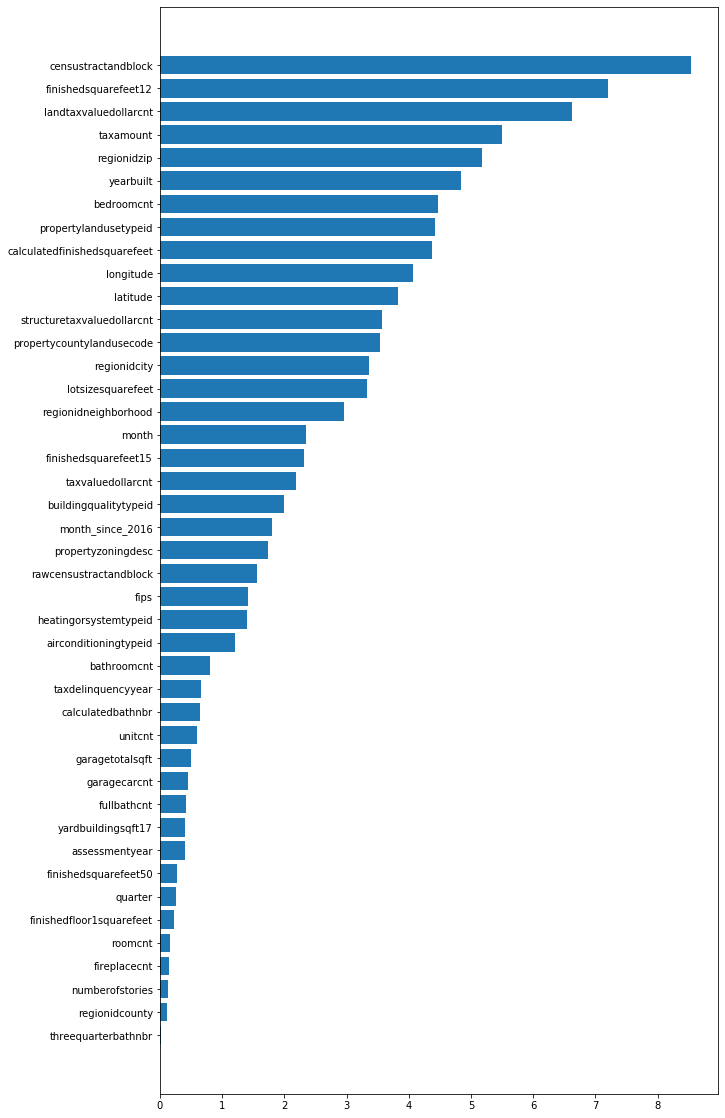

In [24]:
feat_imp = pd.DataFrame(data=train_feats, columns=['features'])
feat_imp['importances'] = regressor.feature_importances_
feat_imp.sort_values(by='importances', ascending=True, inplace=True)
plt.rcParams['figure.figsize'] = (10,20)
plt.barh(y=feat_imp['features'], width=feat_imp['importances'])

In [8]:
# predict 2016 result
test_16 = prop_16.copy()
test_16.insert(0, 'month', 0)
test_16.insert(1, 'month_since_2016', 0)
test_16.insert(2, 'quarter', 4)
test_16 = convert_cat_columns(test_16, cat_feats)
test_month = [(10, 201610), (11, 201611), (12, 201612)]
result_16 = pd.DataFrame()
result_16['parcelid'] = prop_16['parcelid']
for month, col in test_month:
    test_16['month'] = month
    test_16['month_since_2016'] = month
    test_pool = Pool(data=test_16[train_feats], cat_features=cat_feats)
    temp = regressor.predict(test_pool)
    result_16[col] = temp

In [9]:
# predict 2017 result
test_17 = prop_17.copy()
test_17.insert(0, 'month', 0)
test_17.insert(1, 'month_since_2016', 0)
test_17.insert(2, 'quarter', 4)
test_17 = convert_cat_columns(test_17, cat_feats)
test_month = [(10, 201710), (11, 201711), (12, 201712)]
result_17 = pd.DataFrame()
result_17['parcelid'] = prop_17['parcelid']
for month, col in test_month:
    test_17['month'] = month
    test_17['month_since_2016'] = month + 12
    test_pool = Pool(data=test_17[train_feats], cat_features=cat_feats)
    temp = regressor.predict(test_pool)
    result_17[col] = temp

In [10]:
submission = result_16.merge(result_17, on='parcelid', how='left')
submission.iloc[:,1:] = submission.iloc[:, 1:].round(4)
submission.to_csv('submission_1617.csv', index=False)

In [ ]:
# private leaderboard 0.07510. 186th place / 3775 teams. Top 4.9%